# Dans ce notebook le calcul des barycentre est réalisé au moyen de la méthode proposée par M. Cuturi dans sont article "Fast computation of Wasserstein Barycenters".

This github has been of great help and inspiration for the first steps : https://github.com/nicolas-bolle/barycenters

In [1]:
# Imports

#Basics
import numpy as np 
import pandas as pd
import scipy.io
import time
from PIL import Image
import random
import matplotlib.pyplot as plt

#Dataset
mat = scipy.io.loadmat('centers_MNIST.mat')
tableau = mat['affNISTdata'][0][0]
#pics parameters:
nb_pixel_side = 40  
resolution = nb_pixel_side * nb_pixel_side

### Implementing Sinkholn

Let's start with a basic example in 1D.

I, first, artificially build a distance matrix:

In [699]:
# Distance matrix
n = 10
M = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        M[i,j] = abs(i-j)

a and b are the probabilities associated to X and Y, which have the distane matrix as M.

b is the target probability, while a is just initialized below:

In [693]:
# Test
b = np.ones(10) * 0.01
a = np.zeros(10)
b[0] = b[0] + 0.5
a[1] = 0.3
a[2] = 0.7
b[3] = b[3] + 0.4

In [694]:
b

array([0.51, 0.01, 0.01, 0.41, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])

In [701]:
a

array([0. , 0.3, 0.7, 0. , 0. , 0. , 0. , 0. , 0. , 0. ])

Approximation of the transport plan leads to the subsequent approximation of the wasserstein distance

In [696]:
#Approximation: 
0.3 + 0.21*2+0.41+0.01*(1+2+3+4+5+6+7+8)

1.4899999999999998

### Let's get the Sinkhorn method coded:

According to 'Fast Computation Wasserstein Barycenters"

In [230]:
# Hyperparameters
lambda_sinkhorn = 9
iterations = 20

def sinkhorn_descent(a, b, M, lambda_sinkhorn=10, iterations=200):
    """
    lambda and iterations are hyperparameters, 
    iterations could be replaced with a stopping criterion in the futur
    """
    # Keep track of the precision:
    E = np.ones(iterations) * 100
    # Exponential of distances
    K = np.exp(-lambda_sinkhorn * M)

    #Remove zeros in a to avoid division by zeros is PRIMORDIAL :
    n = len(a)
    I = a > 0
    n_I = len(I)
    a = a[I]
    M = M[I,:]
    K = K[I,:]

    # Reshape b to make it a matrix if it s just one list
    if len(np.shape(b)) == 1:
        b = np.reshape(b,(len(b),1))

    K_tild = np.diag(np.reciprocal(a)) @ K

    #initialisation of u, an (n x 1) matrix, with
    n_no_null = len(a)
    u = np.ones((n_no_null,1)) / n_no_null

    # Iterate for u
    # FIXME : see rule of Wolf for the stopping criterion?
    epsilon_sinkhorn = 1
    for iteration in range(iterations) : #epsilon_sinkhorn > precision_sinkhorn : #and iteration < 100:
        # keep track on convergence
        u1 = u 
        
        # calcul
        inv_u = K_tild @ (b * np.reciprocal(K.T @ u))
        u = np.reciprocal(inv_u)
        
        # convergence:
        dist = (u1 - u) /np.linalg.norm(u) # normalized by the 2-norm of u
        epsilon_sinkhorn = np.sqrt( dist.T @ dist ) 
        epsilon_sinkhorn = epsilon_sinkhorn[0,0]
        E[iteration] = epsilon_sinkhorn
        
    print(iteration, '-th, precision : ', epsilon_sinkhorn, "norm u: ", np.linalg.norm(u))

    # Get v from u
    v = b * np.reciprocal( K.T @ u )

    # Get alpha, the subgradient of the Sinkhorn distance
    alpha = np.zeros((len(I),np.shape(b)[1]))
    alpha_I = -1/lambda_sinkhorn * np.log(u) + 1/(n_no_null * lambda_sinkhorn) * sum(np.log(u)) * np.ones((n_no_null,1))
    alpha[I,:] = alpha_I
    
    #Get T, the transport matrix
    T = np.zeros((n_I, n_I))  #modified from (len(I),len(I))
    u_flat = np.reshape(u,(len(u),)) #needed to use np.diag
    v_flat = np.reshape(v,(len(v),)) #needed to use np.diag
    T_I = np.diag(u_flat) @ K @ np.diag(v_flat)
    T[I,:] = T_I

    # Sinkhorn distance ~ Wasserstein distance
    D_S = np.trace(M.T  @ T_I)
    
    # Output: the subgradient, the transport matrix, the distance
    return(alpha, T, D_S, E)

The transport plan associated with our example is the following

In [719]:
T = sinkhorn_descent(a, b, M)[1]
np.round(T, 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.29, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.22, 0.  , 0.01, 0.41, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

In [720]:
D_S = sinkhorn_descent(a, b, M)[2]
D_S

1.4099575712894146

Awesome, this is close to our approximation !! The difference can be explained with the transport plan T.

In [723]:
for lambda_sink in [1, 2, 5, 9, 10, 11, 20, 30]:
    # get the time cost
    start = time.time()
    # calcul the solution
    res = sinkhorn_descent(a, b, M, lambda_sink)
    end = time.time()
    # print the output
    T = res[1][1:3,:]
    D_S = res[2]
    print(f"for lambda = {lambda_sink}, the transport plan is : ")
    print(np.round(T,2))
    print('and the associated distance')
    print(np.round(D_S,2))
    print(f"the calcul took {np.round(end-start, 4)} secondes")

for lambda = 1, the transport plan is : 
[[0.24 0.   0.   0.04 0.   0.   0.   0.   0.   0.  ]
 [0.27 0.01 0.01 0.37 0.01 0.01 0.01 0.01 0.01 0.01]]
and the associated distance
1.51
the calcul took 0.0 secondes
for lambda = 2, the transport plan is : 
[[0.28 0.01 0.   0.01 0.   0.   0.   0.   0.   0.  ]
 [0.23 0.   0.01 0.4  0.01 0.01 0.01 0.01 0.01 0.01]]
and the associated distance
1.43
the calcul took 0.0011 secondes
for lambda = 5, the transport plan is : 
[[0.29 0.01 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.22 0.   0.01 0.41 0.01 0.01 0.01 0.01 0.01 0.01]]
and the associated distance
1.41
the calcul took 0.0012 secondes
for lambda = 9, the transport plan is : 
[[0.29 0.01 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.22 0.   0.01 0.41 0.01 0.01 0.01 0.01 0.01 0.01]]
and the associated distance
1.41
the calcul took 0.0012 secondes
for lambda = 10, the transport plan is : 
[[0.29 0.01 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.22 0.   0.01 0.41 0.01 0.01 0.01 0.01 0.01 0.01]]
an

Be sure u converges, if else, T could not be the correct transport plan and respect the joint proba

This is interesting to see, that for too big lambda, the problem is not resolved since the sum along the i axis does not match the value of the ponderation of a !!

# Let's test with MNIST data

In [3]:
# Number of samples
N_samples = len(tableau[2][0])

# Samples are 40x40 = 1600 length arrays that represent digits in grey scale
pixels = [np.array([a[i] for a in tableau[2]]) for i in range(N_samples)]
atoms = [p/sum(p) for p in pixels] 

# Each array is labelled
int_0_9 = tableau[5][0]

# Dataframe to store the arrays and the labels:
df_digits = pd.DataFrame({'pixels':pixels, 'int_0_9':int_0_9, 'atoms':atoms})
df_digits.head(3)

,pixels,int_0_9,atoms
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Let's build the matrix of distances between digit data:

In [4]:
# Picture resolution 
resolution = nb_pixel_side * nb_pixel_side

## Get M the squared Euclidean distance Matrix between all 40x40 pixels
# To make sure I don't mess up indexing things, I'll set up a list of locations and reshape it into a matrix
# So when I calculate a pairwise distance in the matrix, I can easily associate it to the location in the vector
locations_vec = np.array(range(resolution))
locations_arr = np.reshape(locations_vec, (nb_pixel_side,nb_pixel_side))

M = np.zeros((resolution,resolution))
# Having 4 "for" loops is a bit embarassing, but I'm not trying to think too hard right now
for i1 in range(nb_pixel_side):
    for j1 in range(nb_pixel_side):
        for i2 in range(nb_pixel_side):
            for j2 in range(nb_pixel_side):
                M[locations_arr[i1,j1], locations_arr[i2,j2]] = np.sqrt((i1-i2)**2 + (j1-j2)**2)
            

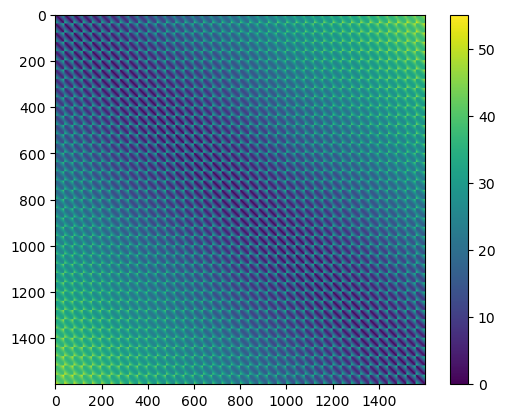

In [171]:
# The plot looks reasonable
plt.imshow(M)
plt.colorbar()
plt.show()

In [34]:
# Number of data
N = 100

# Working data
df_work = df_digits.iloc[:100].sort_values('int_0_9').reset_index()

D = np.zeros((N,N))
for i in range(N):
    a = df_work.atoms[i]
    for j in range(N):
        b = df_work.atoms[j]
        D[i,j] = sinkhorn_descent(a, b, M, 9, 0.1)[2]

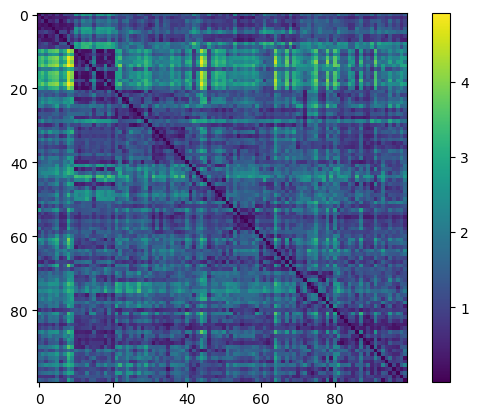

In [35]:
# Plot them
plt.imshow(D)
plt.colorbar()
plt.show()

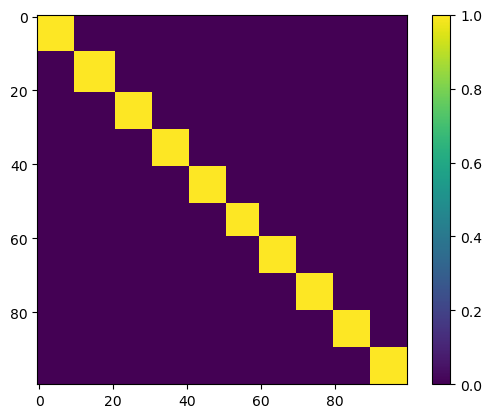

In [36]:
# Compare to when the digits are equal
B = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        B[i,j] = (df_work.int_0_9[i] == df_work.int_0_9[j])

plt.imshow(B)
plt.colorbar()
plt.show()

This looks convincing

Let's try to compare equal numbers :

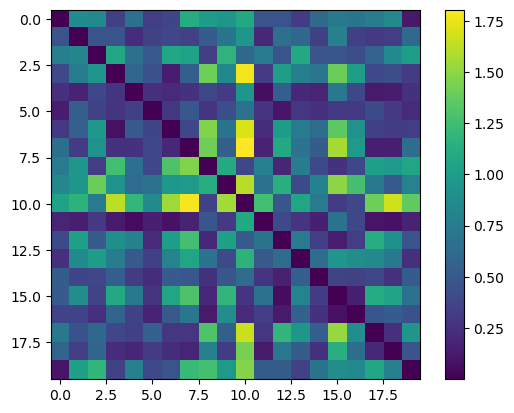

In [293]:
# Number of data
N = 20

# Working data
df_zeros = df_digits.loc[df_digits.int_0_9 == 0].reset_index()
df_work = df_zeros.iloc[:N]

D = np.zeros((N,N))
for i in range(N):
    a = df_work.atoms[i]
    for j in range(N):
        b = df_work.atoms[j]
        D[i,j] = sinkhorn_descent(a, b, M, 9,1)[2]
        
# Plot 
plt.imshow(D)
plt.colorbar()
plt.show()

I would have thought that the distance between the six be homogeneously smaller.

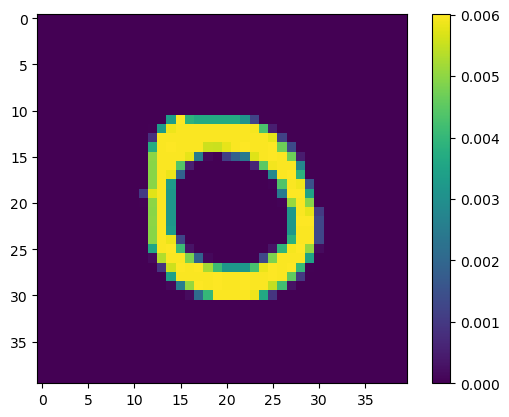

In [294]:
img = np.reshape(df_work.atoms[15], (nb_pixel_side,nb_pixel_side))
plt.imshow(img)
plt.colorbar()
plt.show()

In [40]:
sinkhorn_descent(a, b, M, lambda_sink)[1].shape


(1600, 1600)

## Let's try a regularized gradient descent

Let's find a digit with gradient descent:

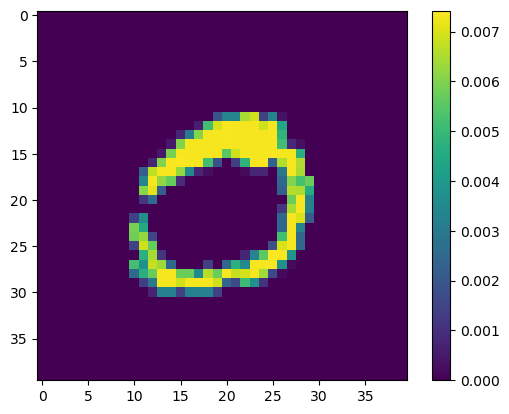

In [581]:
b = df_digits.atoms.iloc[25]
img = np.reshape(b, (nb_pixel_side,nb_pixel_side))
plt.imshow(img)
plt.colorbar()
plt.show()

In [582]:
# Initialisation
steps = 100
a = np.ones(resolution) / resolution
# Keep track
A = np.zeros((resolution,steps+1))
A[:,0] = a


eta = 10**-4

for i in range(steps):
    # Gradient
    alpha = sinkhorn_descent(a, b, M, 10)[0]
    # Reformat to match shape of r and move opposite that direction
    a = a + eta * np.reshape(alpha,np.shape(a))
    # Keep it nonnegative and unit mass
    a = a * (a>0)
    a = a / sum(a)
    # Save it
    A[:,i+1] = a

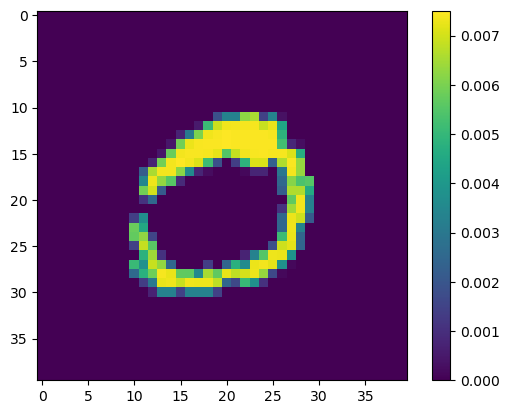

In [583]:
i = 100
img = np.reshape(A[:,i], (nb_pixel_side,nb_pixel_side))
plt.imshow(img)
plt.colorbar()
plt.show()

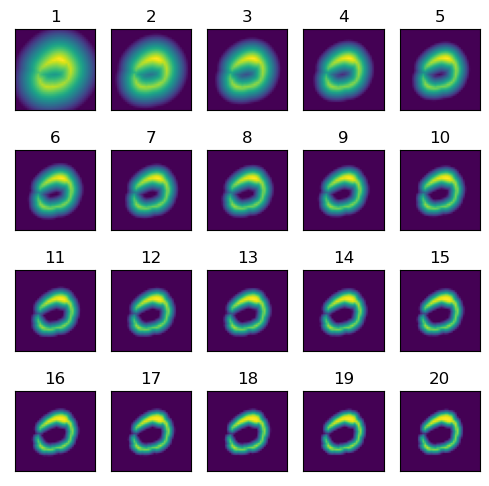

In [584]:
## Plot iterates

# Set up the axes
fig, axs = plt.subplots(4,5,figsize=(6,6))

# Iterate over the plotting locations
i = 0
for ax in axs.ravel():
    i = i + 1
    ax.imshow(np.reshape(A[:,i], (nb_pixel_side,nb_pixel_side))) #, vmin=0, vmax=0.001)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(i))

This is awesome !

The two following calculations show that modifying the eta at the right time increases the convergence speed.

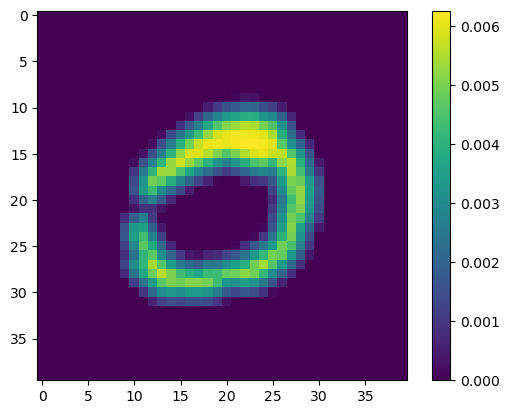

In [585]:
# Initalisation
a = np.ones(resolution) / resolution

# parameters
steps = 20
eta = 10**-4

for i in range(steps):
    # Gradient
    alpha = sinkhorn_descent(a, b, M, 10, 10**-4)[0]
    # Reformat to match shape of r and move opposite that direction
    a = a + eta * np.reshape(alpha,np.shape(a))
    # Keep it nonnegative and unit mass
    a = a * (a>0)
    a = a / sum(a)

img = np.reshape(a, (nb_pixel_side,nb_pixel_side))
plt.imshow(img)
plt.colorbar()
plt.show()

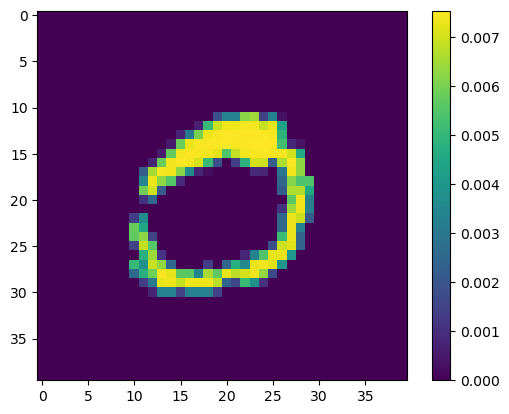

In [314]:
# Initalisation
a = np.ones(resolution) / resolution

# parameters
steps = 10
eta = 10**-3

for i in range(steps):
    # Gradient
    alpha = sinkhorn_descent(a, b, M, 10, 10**-2)[0]
    # Reformat to match shape of r and move opposite that direction
    a = a + eta * np.reshape(alpha,np.shape(a))
    # Keep it nonnegative and unit mass
    a = a * (a>0)
    a = a / sum(a)
    
# new parameters
steps = 10
eta = 10**-4

for i in range(steps):
    # Gradient
    alpha = sinkhorn_descent(a, b, M, 10, 10**-4)[0]
    # Reformat to match shape of r and move opposite that direction
    a = a + eta * np.reshape(alpha,np.shape(a))
    # Keep it nonnegative and unit mass
    a = a * (a>0)
    a = a / sum(a)

img = np.reshape(a, (nb_pixel_side,nb_pixel_side))
plt.imshow(img)
plt.colorbar()
plt.show()


#### Final remarks:
FIXME: once a pixel value is set to zero it never comes back, that is not ideal

Here are some more thoughts:
- Adding noise to things can remove the zero entries and is probably good enough
 - Maybe if I treat division by zero as $+\infty$ then things work out?? I doubt it though
- For speed: check how much faster Regularized Sinkhorn is than Sharp Sinkhorn, since it could help to use the former for the first few iterations for speed (Diffy Sink p. 12 does this)

## Algorithm 1 :  Fast Computation of Wasserstein Barycenters - M. Cuturi

Let's try to get the barycenters of N digits with the gradient descent explained in the Cuturi's paper.

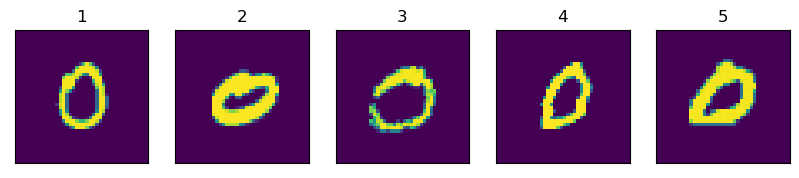

In [240]:
# Number of digits
N = 5

# List of probabilities
b = list( df_digits.loc[df_digits.int_0_9 == 0].reset_index().atoms.iloc[:N] )

# Visualisation
# Set up the axes
fig, axs = plt.subplots(1,N,figsize=(10,10))

# Iterate over the plotting locations
i = 0
for ax in axs.ravel():
    i = i + 1
    ax.imshow(np.reshape(b[i-1], (nb_pixel_side,nb_pixel_side)))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(i))

In [241]:
# Definition of the proximal mapping and proximal updates
# As applied in the Cuturi's paper
def prox_map(a1, alpha, beta, t0):
    a1 = a1 * np.exp(- t0 * beta * alpha)
    a1 = a1 / sum(a1)
    return(a1)

In [242]:
# Algorithm 1
def Kullback_descent(a, b, M, steps1=80, lambda_sinkhorn=10, iterations=200, t=0, t0=-10**-3):
    # Keep track
    steps1_1 = max(1000, steps1)
    A = np.zeros((len(a),steps1_1+1))
    A[:,0] = a
    a1 , a2 = a , a
    # Precision:
    P = np.zeros((steps1_1+1,1))
    P[0] = 100
    
    # Loop until the precision is reached
    i = 0
    precision = 100
    
    
    #FIXME: I can use a stopping criteria instead:
    for i in range(steps1):  #precision > precision_Kullbach or i<2 or P[i-1]<P[i]: # the first steps are precision rising # i<steps1: #
        
        # Learning rate
        beta = (t + 1) / 2
        # Learning 
        a = (1 - 1/beta) * a1 + a2 / beta

        # Subgradient of the sum of the primal problems
        alpha = np.ones(np.shape(a))
        for k in range(len(b)):
            alpha_k = sinkhorn_descent(a, b[k], M, lambda_sinkhorn, iterations)[0]
            alpha_k = np.reshape(alpha_k,np.shape(a))
            alpha = alpha + alpha_k
        alpha = alpha / len(b)

        # Gradient descent, known as the Bregman descent, 
        # used in the Kullback-Leibler case:
        a_c = a1  # to compare to the new a1 and get the distance of the fixed point
        a1 = prox_map(a1, alpha, beta, t0)

        # definition of a2
        a2 = (1 - 1/beta) * a2 + a1 / beta
        
        # reduce the learning rate
        t = t + 1

        # Keep track
        A[:,i+1] = a
        
        # Checking stopping criteria:
        # Is the fixed point close to the function 
        precision = np.sqrt( (a_c - a1).T @ (a_c - a1) )
        P[i+1] = precision
        print(f"Kulback descent {i}-th iteration, precision = {precision}")

    # Output
    return(a, A, P)

199 -th, precision :  0.03130361220159107 norm u:  2.3376835082618073e+127
199 -th, precision :  0.00018432958202686814 norm u:  6.8134074745074e+136
199 -th, precision :  0.03577921244321679 norm u:  1.4788507270442433e+128
199 -th, precision :  0.006796195748809319 norm u:  1.3853699194067935e+144
199 -th, precision :  0.02341052849052847 norm u:  5.577976811979087e+131
Kulback descent 0-th iteration, precision = 6.674239983101788e-05
199 -th, precision :  0.031236186485653395 norm u:  2.264983375661649e+127
199 -th, precision :  0.00024362934751106152 norm u:  6.842777531827154e+136
199 -th, precision :  0.03565580279198348 norm u:  1.4683913150535906e+128
199 -th, precision :  0.006718846972196647 norm u:  1.359372870945737e+144
199 -th, precision :  0.023596394020289964 norm u:  5.5169654816076985e+131
Kulback descent 1-th iteration, precision = 0.00013345541693835002
199 -th, precision :  0.03120217074413796 norm u:  2.229853963537781e+127
199 -th, precision :  0.0002712290949978

199 -th, precision :  0.005059131766559154 norm u:  3.9284031051614855e+144
199 -th, precision :  0.033087842173125354 norm u:  4.400180953194554e+132
Kulback descent 18-th iteration, precision = 0.0012315900453330377
199 -th, precision :  0.02477621902443224 norm u:  7.984375298715342e+125
199 -th, precision :  0.0019081071496277833 norm u:  5.042910114789855e+137
199 -th, precision :  0.03184346397898257 norm u:  2.2017605274671197e+128
199 -th, precision :  0.006002357352183663 norm u:  5.7855302837593265e+144
199 -th, precision :  0.033703861220249265 norm u:  4.960398088544515e+132
Kulback descent 19-th iteration, precision = 0.0012841381731202878
199 -th, precision :  0.023976963254985086 norm u:  5.6067555410860044e+125
199 -th, precision :  0.00047809298819986927 norm u:  6.589198546524485e+137
199 -th, precision :  0.02895369633488522 norm u:  3.402571900629515e+128
199 -th, precision :  0.008279881999946885 norm u:  7.798021240088554e+144
199 -th, precision :  0.0371059351282

199 -th, precision :  0.002307612957141022 norm u:  2.7850830312015832e+134
199 -th, precision :  0.0014180762176822998 norm u:  1.8684964836725725e+126
199 -th, precision :  0.02936208598341347 norm u:  1.3639920261946623e+148
199 -th, precision :  0.012900485916351338 norm u:  2.6654137940380556e+136
Kulback descent 37-th iteration, precision = 0.001252983128621661
199 -th, precision :  0.01786253188659308 norm u:  3.3663812293802744e+122
199 -th, precision :  0.0044988815682713125 norm u:  6.565208365530087e+133
199 -th, precision :  0.0026898386994410675 norm u:  1.1979177615029058e+126
199 -th, precision :  0.02914472034577018 norm u:  1.469462664549867e+148
199 -th, precision :  0.008815865555577968 norm u:  7.022217424264905e+135
Kulback descent 38-th iteration, precision = 0.0012173248617814482
199 -th, precision :  0.017193982451974576 norm u:  2.276273011783697e+122
199 -th, precision :  0.008664202552281593 norm u:  1.2784155154526352e+133
199 -th, precision :  0.00304633173

199 -th, precision :  0.0492697004381676 norm u:  5.592368139417975e+126
Kulback descent 55-th iteration, precision = 0.0007779123598628112
199 -th, precision :  0.009556600005437272 norm u:  1.3632538090872486e+120
199 -th, precision :  0.07116277674544215 norm u:  4.5365505736667904e+122
199 -th, precision :  0.010600362210457326 norm u:  1.0666865120800903e+120
199 -th, precision :  0.007702438346443263 norm u:  5.4685189911929786e+144
199 -th, precision :  0.04710411185348996 norm u:  4.3728383921291946e+126
Kulback descent 56-th iteration, precision = 0.0007550043357248777
199 -th, precision :  0.009384444567861513 norm u:  1.0462864096303911e+120
199 -th, precision :  0.07076436132516696 norm u:  2.0833579725898045e+122
199 -th, precision :  0.00954646578901013 norm u:  6.087676608786678e+119
199 -th, precision :  0.006125067224566988 norm u:  3.708752358091768e+144
199 -th, precision :  0.04472901830447522 norm u:  3.4997066612988005e+126
Kulback descent 57-th iteration, precisi

199 -th, precision :  0.006471446267138988 norm u:  4.712217169023329e+115
199 -th, precision :  0.005199032334673542 norm u:  1.7784040089262207e+141
199 -th, precision :  0.025931268789206208 norm u:  2.5346846211451865e+125
Kulback descent 74-th iteration, precision = 0.0004223586769272374
199 -th, precision :  0.0066023414525627645 norm u:  3.693602282371878e+118
199 -th, precision :  0.1160051466956701 norm u:  3.988300697581713e+116
199 -th, precision :  0.0068881375564173765 norm u:  3.892827167057881e+115
199 -th, precision :  0.004237221009563728 norm u:  1.3241656024731615e+141
199 -th, precision :  0.0256937049327044 norm u:  2.0849143091239576e+125
Kulback descent 75-th iteration, precision = 0.00041083157038232824
199 -th, precision :  0.006566010730896448 norm u:  3.4450783229017984e+118
199 -th, precision :  0.11567495283249976 norm u:  3.1042754426889613e+116
199 -th, precision :  0.007274382647047251 norm u:  3.2398394841993597e+115
199 -th, precision :  0.003517256634

199 -th, precision :  0.0074699167619898385 norm u:  1.8592472908519303e+118
199 -th, precision :  0.08373058621041571 norm u:  1.0508650123940466e+114
199 -th, precision :  0.012298992254019403 norm u:  1.342948407641502e+114
199 -th, precision :  0.0016429267404151828 norm u:  1.1334019606189229e+140
199 -th, precision :  0.045937689260138255 norm u:  3.0985076544591357e+124
Kulback descent 93-th iteration, precision = 0.0002799459354792408
199 -th, precision :  0.00762460375946631 norm u:  1.8152101769155343e+118
199 -th, precision :  0.08629322281614873 norm u:  8.376127194629403e+113
199 -th, precision :  0.019772061576808053 norm u:  8.354416127969222e+113
199 -th, precision :  0.0016453416189228806 norm u:  1.0591344994381127e+140
199 -th, precision :  0.045982890606985516 norm u:  3.0177784316814226e+124
Kulback descent 94-th iteration, precision = 0.00027585531729320504
199 -th, precision :  0.007808933966294768 norm u:  1.7763815544349582e+118
199 -th, precision :  0.08880411

199 -th, precision :  0.001297085180105499 norm u:  4.998383083414638e+139
199 -th, precision :  0.04658818532074618 norm u:  7.266826053825013e+124
Kulback descent 111-th iteration, precision = 0.0002212496462532401
199 -th, precision :  0.010935090418984182 norm u:  1.342465483484858e+118
199 -th, precision :  0.1238223205448538 norm u:  7.250960096712869e+112
199 -th, precision :  0.027205001201776453 norm u:  3.7339180104297766e+111
199 -th, precision :  0.0012588014851957572 norm u:  4.860442815598654e+139
199 -th, precision :  0.04662863421845955 norm u:  8.00170245755212e+124
Kulback descent 112-th iteration, precision = 0.00021836871429818132
199 -th, precision :  0.011093481638261165 norm u:  1.3243898149373518e+118
199 -th, precision :  0.12559228421481664 norm u:  6.723860890927026e+112
199 -th, precision :  0.026419382069633866 norm u:  3.2385930818786387e+111
199 -th, precision :  0.0012206174342441324 norm u:  4.73266582096461e+139
199 -th, precision :  0.0467260657495895

199 -th, precision :  0.013456906785464197 norm u:  1.0539245760991363e+118
199 -th, precision :  0.14768898160412938 norm u:  2.7833289561333847e+112
199 -th, precision :  0.02606272314632991 norm u:  1.2779047272858156e+110
199 -th, precision :  0.0007331928658364951 norm u:  3.383764515514844e+139
199 -th, precision :  0.06299272616262151 norm u:  2.224673054971299e+125
Kulback descent 130-th iteration, precision = 0.0001693783248859679
199 -th, precision :  0.013562528723292128 norm u:  1.0411053731780432e+118
199 -th, precision :  0.14852658088165094 norm u:  2.669820954425943e+112
199 -th, precision :  0.028431260246905166 norm u:  8.871844468337789e+109
199 -th, precision :  0.0007279156133059186 norm u:  3.329726742160082e+139
199 -th, precision :  0.06427155841499155 norm u:  2.151310376272667e+125
Kulback descent 131-th iteration, precision = 0.00016735874334785538
199 -th, precision :  0.013662578348785034 norm u:  1.0285249447996512e+118
199 -th, precision :  0.149319380538

199 -th, precision :  0.0008611716086359952 norm u:  2.6673091791547103e+139
199 -th, precision :  0.07481961372252187 norm u:  8.023255933182101e+124
Kulback descent 148-th iteration, precision = 0.00013685010445863133
199 -th, precision :  0.014477742734668394 norm u:  8.550365426417126e+117
199 -th, precision :  0.15734259911605156 norm u:  1.3510270437741368e+112
199 -th, precision :  0.048261040686604764 norm u:  5.93599490776489e+107
199 -th, precision :  0.0008787624947687659 norm u:  2.638765726758093e+139
199 -th, precision :  0.07495961183137301 norm u:  7.619976687773991e+124
Kulback descent 149-th iteration, precision = 0.0001354021856929538
199 -th, precision :  0.014474077150599321 norm u:  8.46853878808382e+117
199 -th, precision :  0.1575687475635837 norm u:  1.3067352495744974e+112
199 -th, precision :  0.04907801881397005 norm u:  4.860763535720604e+107
199 -th, precision :  0.0008973132825580865 norm u:  2.610761920006587e+139
199 -th, precision :  0.0750766782609887

199 -th, precision :  0.1593947124059882 norm u:  8.420304393993186e+111
199 -th, precision :  0.0568119618510705 norm u:  7.425300680044634e+106
199 -th, precision :  0.001413807205736834 norm u:  2.0997775359334897e+139
199 -th, precision :  0.07526380079039292 norm u:  3.54834913424135e+124
Kulback descent 167-th iteration, precision = 0.00010724238305783381
199 -th, precision :  0.013747488910636011 norm u:  7.14515356137562e+117
199 -th, precision :  0.15945228434865008 norm u:  8.281838729565384e+111
199 -th, precision :  0.056752082767355244 norm u:  7.192272944152978e+106
199 -th, precision :  0.0014545479671649268 norm u:  2.0681250634637658e+139
199 -th, precision :  0.07522151232052827 norm u:  3.417158527002637e+124
Kulback descent 168-th iteration, precision = 0.00010563158836228347
199 -th, precision :  0.01369501398103878 norm u:  7.070311323276163e+117
199 -th, precision :  0.15951236747107939 norm u:  8.154143400782622e+111
199 -th, precision :  0.05665133885320099 nor

199 -th, precision :  0.012813272109371549 norm u:  5.701953880764848e+117
199 -th, precision :  0.16284629928735367 norm u:  7.182459194936819e+111
199 -th, precision :  0.05134384913240608 norm u:  8.68900409223944e+106
199 -th, precision :  0.0021532411066941337 norm u:  1.5925247881689531e+139
199 -th, precision :  0.07420773818333896 norm u:  1.7803243411510356e+124
Kulback descent 186-th iteration, precision = 7.883658515767382e-05
199 -th, precision :  0.012748643970039627 norm u:  5.625396719419183e+117
199 -th, precision :  0.16333930880031006 norm u:  7.197408250835771e+111
199 -th, precision :  0.050948900194837526 norm u:  8.956181361494632e+106
199 -th, precision :  0.002188790635798607 norm u:  1.571145504772448e+139
199 -th, precision :  0.0741444092370637 norm u:  1.7176311415376421e+124
Kulback descent 187-th iteration, precision = 7.772015297947886e-05
199 -th, precision :  0.012682731160922856 norm u:  5.549875899040142e+117
199 -th, precision :  0.1638942353534411 n

199 -th, precision :  0.07309622552986833 norm u:  9.251299205335287e+123
Kulback descent 204-th iteration, precision = 6.120821180473413e-05
199 -th, precision :  0.011506529398571334 norm u:  4.429074520142473e+117
199 -th, precision :  0.1814752233345892 norm u:  9.595843560282062e+111
199 -th, precision :  0.04499938065352412 norm u:  1.562951776427669e+107
199 -th, precision :  0.0028049782518113045 norm u:  1.2505591874179812e+139
199 -th, precision :  0.07303994976419802 norm u:  8.918956156522255e+123
Kulback descent 205-th iteration, precision = 6.032330733518455e-05
199 -th, precision :  0.011441873896892366 norm u:  4.3722421117389667e+117
199 -th, precision :  0.18255619095266748 norm u:  9.815836914613586e+111
199 -th, precision :  0.04478755980293752 norm u:  1.600964091254089e+107
199 -th, precision :  0.0028391024767291965 norm u:  1.235616206839298e+139
199 -th, precision :  0.07298449530453019 norm u:  8.599546792894839e+123
Kulback descent 206-th iteration, precision

199 -th, precision :  0.04319775827597768 norm u:  1.9863173812212936e+107
199 -th, precision :  0.0034370882321614403 norm u:  1.012509645151741e+139
199 -th, precision :  0.07210638179928211 norm u:  4.819483530382127e+123
Kulback descent 223-th iteration, precision = 4.59071190693805e-05
199 -th, precision :  0.01055559825429269 norm u:  3.454496866756414e+117
199 -th, precision :  0.1953852678406696 norm u:  1.1885418723980347e+112
199 -th, precision :  0.04319862598077104 norm u:  1.9922437197669308e+107
199 -th, precision :  0.0034733852279171524 norm u:  1.0008766703327066e+139
199 -th, precision :  0.07205613242988737 norm u:  4.675168055116906e+123
Kulback descent 224-th iteration, precision = 4.5218874110153054e-05
199 -th, precision :  0.010521303020915989 norm u:  3.409498869679669e+117
199 -th, precision :  0.1958738946730551 norm u:  1.1854334348383882e+112
199 -th, precision :  0.043207029651762624 norm u:  1.996562855045973e+107
199 -th, precision :  0.00350977194468535

199 -th, precision :  0.010033228414987843 norm u:  2.7726730074082823e+117
199 -th, precision :  0.20322477564421815 norm u:  9.777419404907832e+111
199 -th, precision :  0.0440792284105473 norm u:  1.8991985281253913e+107
199 -th, precision :  0.004124092249089102 norm u:  8.135100471794577e+138
199 -th, precision :  0.07119521529788887 norm u:  2.9712062345455277e+123
Kulback descent 242-th iteration, precision = 3.478216659280516e-05
199 -th, precision :  0.010006601538251794 norm u:  2.7423474546605234e+117
199 -th, precision :  0.20361164794281272 norm u:  9.5937331660482e+111
199 -th, precision :  0.04415058228807378 norm u:  1.8874344390672284e+107
199 -th, precision :  0.004158809513254579 norm u:  8.042900310107545e+138
199 -th, precision :  0.07115080742067711 norm u:  2.912008766892741e+123
Kulback descent 243-th iteration, precision = 3.4280148841919635e-05
199 -th, precision :  0.009980092141483857 norm u:  2.7126687363177565e+117
199 -th, precision :  0.2039932071918151 

199 -th, precision :  0.07047847381596627 norm u:  2.208447019064848e+123
Kulback descent 260-th iteration, precision = 2.6626946741627852e-05
199 -th, precision :  0.009553859488841276 norm u:  2.285787250925077e+117
199 -th, precision :  0.2103864227166858 norm u:  6.485853735136057e+111
199 -th, precision :  0.045277395200370586 norm u:  1.6554029792405156e+107
199 -th, precision :  0.004724868609343375 norm u:  6.586758483857691e+138
199 -th, precision :  0.07044460974754495 norm u:  2.1800149398218317e+123
Kulback descent 261-th iteration, precision = 2.6226870411753445e-05
199 -th, precision :  0.009530630741777004 norm u:  2.2642732732390115e+117
199 -th, precision :  0.21076111261212607 norm u:  6.329994287979214e+111
199 -th, precision :  0.04532638510881469 norm u:  1.6428263987672868e+107
199 -th, precision :  0.0047525179115272395 norm u:  6.516362320971413e+138
199 -th, precision :  0.07041135576708989 norm u:  2.1525572624935963e+123
Kulback descent 262-th iteration, prec

199 -th, precision :  0.04597746723053307 norm u:  1.4600082401014199e+107
199 -th, precision :  0.005160207292050584 norm u:  5.4583693539057376e+138
199 -th, precision :  0.06992753447872084 norm u:  1.7896050634082812e+123
Kulback descent 279-th iteration, precision = 1.9946455071230334e-05
199 -th, precision :  0.009155203203547513 norm u:  1.9236641396969733e+117
199 -th, precision :  0.21217298931063522 norm u:  3.2186974331802605e+111
199 -th, precision :  0.04602223284983206 norm u:  1.4500463895340493e+107
199 -th, precision :  0.005180813019382945 norm u:  5.4033822492599763e+138
199 -th, precision :  0.06990328821686398 norm u:  1.772444332335456e+123
Kulback descent 280-th iteration, precision = 1.9647125848011293e-05
199 -th, precision :  0.009136753597689489 norm u:  1.906920412580836e+117
199 -th, precision :  0.21195723134656208 norm u:  3.0594279659056936e+111
199 -th, precision :  0.04606937247462812 norm u:  1.440044346052789e+107
199 -th, precision :  0.005201081765

199 -th, precision :  0.00886064354802529 norm u:  1.6493158379571062e+117
199 -th, precision :  0.21248254254037238 norm u:  1.576943324405273e+111
199 -th, precision :  0.047194117398073034 norm u:  1.265120327446721e+107
199 -th, precision :  0.005499382245937327 norm u:  4.5251537187777316e+138
199 -th, precision :  0.06953061684912727 norm u:  1.5056434008620192e+123
Kulback descent 298-th iteration, precision = 1.5083254231796178e-05
199 -th, precision :  0.008846537342398113 norm u:  1.6355815751304278e+117
199 -th, precision :  0.2126882628095913 norm u:  1.5421119805366297e+111
199 -th, precision :  0.047272784799256125 norm u:  1.2548938510351601e+107
199 -th, precision :  0.005514485148702754 norm u:  4.481935830695742e+138
199 -th, precision :  0.06951303542392767 norm u:  1.4925843723929552e+123
Kulback descent 299-th iteration, precision = 1.4868747715949041e-05
199 -th, precision :  0.008832658552167352 norm u:  1.6219890098680068e+117
199 -th, precision :  0.21289848509

199 -th, precision :  0.005736832048468824 norm u:  3.822235661789738e+138
199 -th, precision :  0.06925538807404838 norm u:  1.2904404486570472e+123
Kulback descent 316-th iteration, precision = 1.167132354321666e-05
199 -th, precision :  0.0086294146665956 norm u:  1.410763929364455e+117
199 -th, precision :  0.21637191944734138 norm u:  1.1878212460135512e+111
199 -th, precision :  0.04869733572784338 norm u:  1.0830326962380296e+107
199 -th, precision :  0.005748078461584511 norm u:  3.78745915782786e+138
199 -th, precision :  0.0692424430330739 norm u:  1.2795914223245979e+123
Kulback descent 317-th iteration, precision = 1.1506462117047626e-05
199 -th, precision :  0.008619244363111943 norm u:  1.399412168352871e+117
199 -th, precision :  0.21655083778018477 norm u:  1.17519385088023e+111
199 -th, precision :  0.04877295101378581 norm u:  1.074297679985465e+107
199 -th, precision :  0.005759140694641968 norm u:  3.753091236763495e+138
199 -th, precision :  0.06922972147683085 nor

199 -th, precision :  0.2191094947595928 norm u:  9.971756389293345e+110
199 -th, precision :  0.04996271036292875 norm u:  9.387756814839142e+106
199 -th, precision :  0.00592161678227875 norm u:  3.226141514654014e+138
199 -th, precision :  0.06904457454222934 norm u:  1.1013093784375086e+123
Kulback descent 335-th iteration, precision = 8.904563955762164e-06
199 -th, precision :  0.008464824628155137 norm u:  1.2126857992167816e+117
199 -th, precision :  0.2192350525924662 norm u:  9.882185261291278e+110
199 -th, precision :  0.050027202252963775 norm u:  9.315058615648734e+106
199 -th, precision :  0.005929811883964279 norm u:  3.1982310905633315e+138
199 -th, precision :  0.06903534298039109 norm u:  1.0922884301897118e+123
Kulback descent 336-th iteration, precision = 8.778495525863883e-06
199 -th, precision :  0.008457680652038523 norm u:  1.203217888527739e+117
199 -th, precision :  0.21935824125458941 norm u:  9.793880093625463e+110
199 -th, precision :  0.05009112272686173 no

199 -th, precision :  0.008355242258394418 norm u:  1.0550474681180454e+117
199 -th, precision :  0.22114080195530167 norm u:  8.456000262914884e+110
199 -th, precision :  0.0510957571180637 norm u:  8.117787163510794e+106
199 -th, precision :  0.006055955591709292 norm u:  2.7455805038113285e+138
199 -th, precision :  0.06889517182052039 norm u:  9.440630957020988e+122
Kulback descent 354-th iteration, precision = 6.788072687141518e-06
199 -th, precision :  0.008350221528810826 norm u:  1.0470350317933646e+117
199 -th, precision :  0.22122987655212834 norm u:  8.385573306443403e+110
199 -th, precision :  0.05115025134481438 norm u:  8.056901294347921e+106
199 -th, precision :  0.006061898297833078 norm u:  2.7229583846003175e+138
199 -th, precision :  0.0688886761677282 norm u:  9.365658606661076e+122
Kulback descent 355-th iteration, precision = 6.691548283547763e-06
199 -th, precision :  0.00834530072218702 norm u:  1.0390957283948423e+117
199 -th, precision :  0.22131743731082532 n

199 -th, precision :  0.0687951133366061 norm u:  8.196487915313864e+122
Kulback descent 372-th iteration, precision = 5.240347155490598e-06
199 -th, precision :  0.008275350330789622 norm u:  9.146296066947584e+116
199 -th, precision :  0.22260203271872844 norm u:  7.24345539549132e+110
199 -th, precision :  0.052046919369259315 norm u:  7.048172005723409e+106
199 -th, precision :  0.0061532064481852515 norm u:  2.3543643382153756e+138
199 -th, precision :  0.06879049409792205 norm u:  8.133518151123971e+122
Kulback descent 373-th iteration, precision = 5.16515367051264e-06
199 -th, precision :  0.00827195497582659 norm u:  9.078876764529786e+116
199 -th, precision :  0.22266701896518792 norm u:  7.18629010130632e+110
199 -th, precision :  0.05209208199798301 norm u:  6.996646393820366e+106
199 -th, precision :  0.006157499689395567 norm u:  2.3358544699181662e+138
199 -th, precision :  0.0687859620623919 norm u:  8.071151411053134e+122
Kulback descent 374-th iteration, precision = 5.

199 -th, precision :  0.052786013168745705 norm u:  6.185365228973535e+106
199 -th, precision :  0.006220196095727393 norm u:  2.0484077099148333e+138
199 -th, precision :  0.0687207988493519 norm u:  7.097250064552783e+122
Kulback descent 391-th iteration, precision = 3.974217765386267e-06
199 -th, precision :  0.00822178978323496 norm u:  7.963044534047343e+116
199 -th, precision :  0.22367644454497515 norm u:  6.252329312981204e+110
199 -th, precision :  0.052822559338698456 norm u:  6.141229006456678e+106
199 -th, precision :  0.0062233392247821075 norm u:  2.0329796966062027e+138
199 -th, precision :  0.06871758590302371 norm u:  7.044708004646989e+122
Kulback descent 392-th iteration, precision = 3.916272980187567e-06
199 -th, precision :  0.008219538905393198 norm u:  7.90613610950677e+116
199 -th, precision :  0.2237246272745554 norm u:  6.205277003895168e+110
199 -th, precision :  0.05285864133771481 norm u:  6.097468589740063e+106
199 -th, precision :  0.006226427984320503 no

199 -th, precision :  0.008188105229704767 norm u:  7.011427816381955e+116
199 -th, precision :  0.2244407191749763 norm u:  5.4722669974747154e+110
199 -th, precision :  0.053403429668078 norm u:  5.407891785663892e+106
199 -th, precision :  0.00627143417907599 norm u:  1.7796017546308483e+138
199 -th, precision :  0.06866914131327831 norm u:  6.1782589192407304e+122
Kulback descent 410-th iteration, precision = 2.9980109686567338e-06
199 -th, precision :  0.00818661032613367 norm u:  6.962819596880622e+116
199 -th, precision :  0.22447740110023423 norm u:  5.4327900047215927e+110
199 -th, precision :  0.05343160504214251 norm u:  5.370348992977201e+106
199 -th, precision :  0.006273684524428845 norm u:  1.7667737728690412e+138
199 -th, precision :  0.06866690975814073 norm u:  6.134225554297498e+122
Kulback descent 411-th iteration, precision = 2.9533301611285565e-06
199 -th, precision :  0.008185149930727022 norm u:  6.914631152662993e+116
199 -th, precision :  0.22451354061256953 n

199 -th, precision :  0.0686348821867811 norm u:  5.443797953636231e+122
Kulback descent 428-th iteration, precision = 2.2807081338035096e-06
199 -th, precision :  0.008164964814548826 norm u:  6.155860218946034e+116
199 -th, precision :  0.2250529079675424 norm u:  4.782199806016247e+110
199 -th, precision :  0.053872311315003446 norm u:  4.7461190375294935e+106
199 -th, precision :  0.006308016570812512 norm u:  1.555335102995852e+138
199 -th, precision :  0.06863330553078481 norm u:  5.406380845921058e+122
Kulback descent 429-th iteration, precision = 2.2459006581840772e-06
199 -th, precision :  0.008164025912328818 norm u:  6.114584695602279e+116
199 -th, precision :  0.22508064495609567 norm u:  4.7491442169960396e+110
199 -th, precision :  0.05389336420392671 norm u:  4.7141322371440784e+106
199 -th, precision :  0.006309627673597009 norm u:  1.544587113751207e+138
199 -th, precision :  0.0686317633556073 norm u:  5.369300668092616e+122
Kulback descent 430-th iteration, precision

199 -th, precision :  0.05417745940764111 norm u:  4.214888925434703e+106
199 -th, precision :  0.006317342080872215 norm u:  1.3805726898964168e+138
199 -th, precision :  0.06860566483476398 norm u:  4.7822530807531956e+122
Kulback descent 447-th iteration, precision = 3.2906935576842645e-06
199 -th, precision :  0.008173392527260105 norm u:  5.4600369978939515e+116
199 -th, precision :  0.22550378434138912 norm u:  4.2080810710130516e+110
199 -th, precision :  0.05425996942333026 norm u:  4.172888725164757e+106
199 -th, precision :  0.006359361242669571 norm u:  1.3595111563432168e+138
199 -th, precision :  0.06861514487202826 norm u:  4.761733269689897e+122
Kulback descent 448-th iteration, precision = 4.743218776817371e-06
199 -th, precision :  0.008112143782574225 norm u:  5.340649849492802e+116
199 -th, precision :  0.22556061206598568 norm u:  4.165258558433277e+110
199 -th, precision :  0.05416520354741589 norm u:  4.169267494366742e+106
199 -th, precision :  0.0062932960345321

199 -th, precision :  0.2295184720686072 norm u:  1.369984636321513e+145
199 -th, precision :  0.1417333105467889 norm u:  1.8669162556503e+121
199 -th, precision :  0.063971224731684 norm u:  3.424873494145907e+101
199 -th, precision :  0.04131499072801373 norm u:  1.3425101587624011e+121
199 -th, precision :  0.035116847300291784 norm u:  8.376941437351667e+112
Kulback descent 466-th iteration, precision = 0.05350146727296202
199 -th, precision :  0.2553896962834339 norm u:  1.641620224196997e+145
199 -th, precision :  0.1327923568328007 norm u:  2.0878822129496502e+116
199 -th, precision :  0.11327594463752676 norm u:  6.559780505112088e+133
199 -th, precision :  0.20754126516184299 norm u:  9.252548295802691e+132
199 -th, precision :  0.2834213796245119 norm u:  5.215945086585557e+111
Kulback descent 467-th iteration, precision = 0.07253222536068464
199 -th, precision :  0.0245770007849229 norm u:  2.6649770757752637e+150
199 -th, precision :  0.19661487428082677 norm u:  1.2632692

199 -th, precision :  0.29895434755364053 norm u:  5.376369485730526e+126
199 -th, precision :  0.28596242204521694 norm u:  8.626867394377527e+116
Kulback descent 485-th iteration, precision = 0.07699010870754237
199 -th, precision :  0.0 norm u:  inf
199 -th, precision :  0.24971797975619042 norm u:  8.581554420526092e+142
199 -th, precision :  0.20719048859228661 norm u:  2.558061360001811e+111
199 -th, precision :  0.22758188787581107 norm u:  1.5217767469381694e+145
199 -th, precision :  0.2527895686687427 norm u:  7.1225266706548e+119
Kulback descent 486-th iteration, precision = 0.07710565363176816
199 -th, precision :  0.19063835615666416 norm u:  1.0951973528343757e+146
199 -th, precision :  0.04914279106322868 norm u:  1.3927561494686344e+120
199 -th, precision :  0.1575989592524689 norm u:  9.645609270591124e+144
199 -th, precision :  0.30057879903415263 norm u:  1.1365894900522302e+127
199 -th, precision :  0.2831329605122774 norm u:  7.120415282044705e+116
Kulback descent 

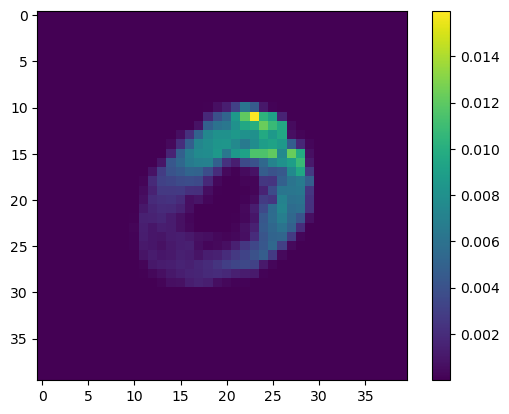

In [272]:
# Initalisation
a = np.ones(resolution) / resolution

# Results:
res6 = Kullback_descent(a, b, M, steps1=500,lambda_sinkhorn=15, iterations=200, t=0, t0=-10**-3)
a6 = res6[0]

# Visualisation of the result
img = np.reshape(a6, (nb_pixel_side,nb_pixel_side))
plt.imshow(img)
plt.colorbar()
plt.show()

Text(0, 0.5, 'distance of the fixed point')

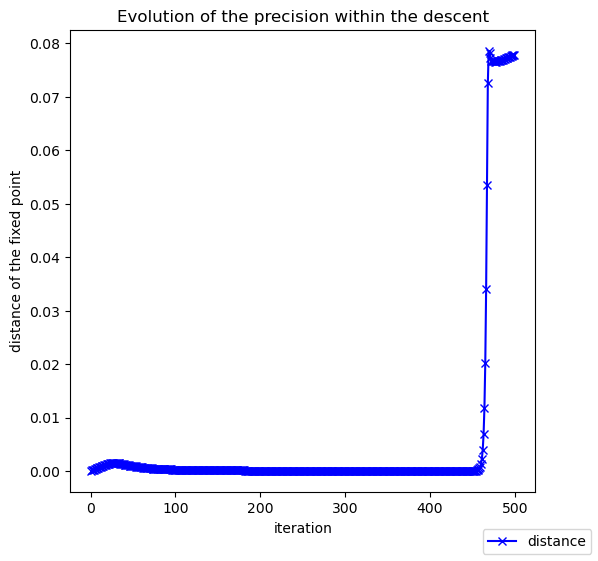

In [273]:
P6 = res6[2]

nb_iterations = [i for i in range(1,500)]
fig, ax1 = plt.subplots(figsize=(6,6))
# ax2 = ax1.twinx()

ax1.plot(nb_iterations, P6[1:500], '-x', color='b', label='distance')
fig.legend(loc='lower right')
plt.title('Evolution of the precision within the descent')
ax1.set_xlabel('iteration')
ax1.set_ylabel("distance of the fixed point")

It is still diverges after the 450 first iterations: that is because the sinkhorn descent does not converge properly! Therefore I double the iterations for the sinkhorn descent for the 50 last iterations of the Algo 1 optimisation !

Lambda is not great enough, that is why the algorithm diverges.

In [260]:
A = res6[1]
a = A[:,450]

399 -th, precision :  0.00570935669499541 norm u:  1.0843458292903722e+117
399 -th, precision :  0.009503812396328701 norm u:  2.688724116333117e+105
399 -th, precision :  0.002219337280962268 norm u:  2.038938879297201e+103
399 -th, precision :  0.014056356785010925 norm u:  3.0105361054871934e+138
399 -th, precision :  0.01695352513584535 norm u:  8.923529124517077e+126
Kulback descent 0-th iteration, precision = 5.648963148605482e-06
399 -th, precision :  0.0057018233164538405 norm u:  1.0779444991915748e+117
399 -th, precision :  0.009478739755553427 norm u:  2.7217076923087067e+105
399 -th, precision :  0.0021885262032763316 norm u:  2.010691166143256e+103
399 -th, precision :  0.014044068766146665 norm u:  2.9703239151978775e+138
399 -th, precision :  0.016883132239246167 norm u:  8.402691942726314e+126
Kulback descent 1-th iteration, precision = 1.117841660272579e-05
399 -th, precision :  0.0056982019455650585 norm u:  1.0746899343273081e+117
399 -th, precision :  0.009465931659

399 -th, precision :  0.01296289343311527 norm u:  1.0510698864553367e+138
399 -th, precision :  0.018815165640693413 norm u:  6.755748209256184e+125
Kulback descent 18-th iteration, precision = 5.4701860387830673e-05
399 -th, precision :  0.005430121385753022 norm u:  4.8160292974760505e+116
399 -th, precision :  0.004210584879779373 norm u:  2.633316634257576e+105
399 -th, precision :  0.0006699083819877846 norm u:  4.115457573565591e+102
399 -th, precision :  0.012843206063691501 norm u:  9.36625509987001e+137
399 -th, precision :  0.019734335559526226 norm u:  6.006401749365777e+125
Kulback descent 19-th iteration, precision = 5.4396016378391216e-05
399 -th, precision :  0.005416920287246814 norm u:  4.3331374467272874e+116
399 -th, precision :  0.003914454193210875 norm u:  2.417411155199183e+105
399 -th, precision :  0.0006262293023421841 norm u:  3.426047749119355e+102
399 -th, precision :  0.01272011246656884 norm u:  8.302242294845698e+137
399 -th, precision :  0.0208053417577

399 -th, precision :  0.005136917390004881 norm u:  3.871253863708054e+115
399 -th, precision :  0.0060012576077744335 norm u:  3.025254038119265e+104
399 -th, precision :  0.034905423021387834 norm u:  4.8126872470069005e+101
399 -th, precision :  0.01079623418481079 norm u:  7.513524793798696e+136
399 -th, precision :  0.046349437119832936 norm u:  1.0486620443374423e+125
Kulback descent 37-th iteration, precision = 4.093861324009476e-05
399 -th, precision :  0.005120719219175842 norm u:  3.372241498208575e+115
399 -th, precision :  0.0061884484667904145 norm u:  2.7627030680891243e+104
399 -th, precision :  0.037683156713834196 norm u:  5.963272316824878e+101
399 -th, precision :  0.010723599682835783 norm u:  6.698541042076522e+136
399 -th, precision :  0.047129207895068755 norm u:  9.556912711328804e+124
Kulback descent 38-th iteration, precision = 4.0400188703996235e-05
399 -th, precision :  0.005104869446711488 norm u:  2.955092032791223e+115
399 -th, precision :  0.006434180985

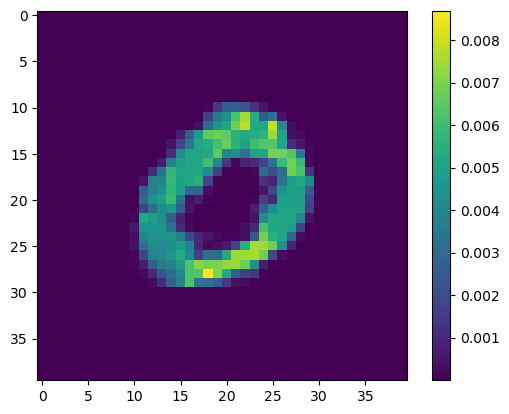

In [261]:
# Initalisation


# Results:
res7 = Kullback_descent(a, b, M, steps1=50 ,lambda_sinkhorn=15, iterations=400, t=0, t0=-10**-3)
a7 = res7[0]

# Visualisation of the result
img = np.reshape(a7, (nb_pixel_side,nb_pixel_side))
plt.imshow(img)
plt.colorbar()
plt.show()

Text(0, 0.5, 'distance of the fixed point')

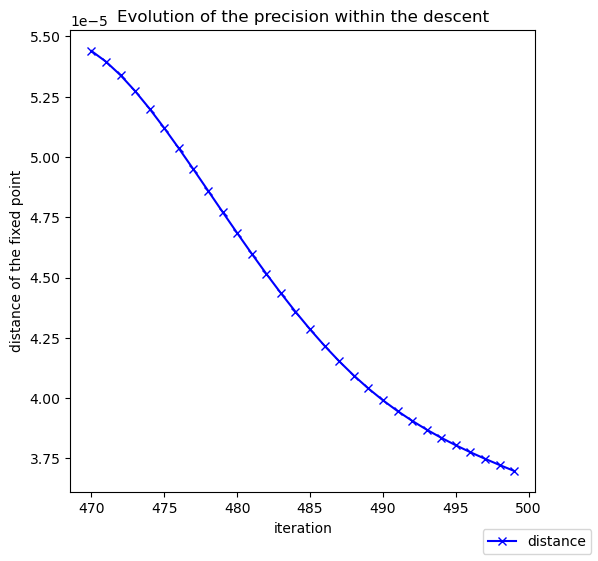

In [271]:
P7 = res7[2]

nb_iterations = [i for i in range(470,500)]
fig, ax1 = plt.subplots(figsize=(6,6))
# ax2 = ax1.twinx()

ax1.plot(nb_iterations, P7[20:50], '-x', color='b', label='distance')
fig.legend(loc='lower right')
plt.title('Evolution of the precision within the descent')
ax1.set_xlabel('iteration')
ax1.set_ylabel("distance of the fixed point")

FIXME: alpha has the sum of its composant that sums to 1, therefore my gradient descente is bounded no ? 

FIXME: this could get parralalized with npI4py for example.

Application where digits are zeros:

The greater is lambda and the longuest take the convergence.

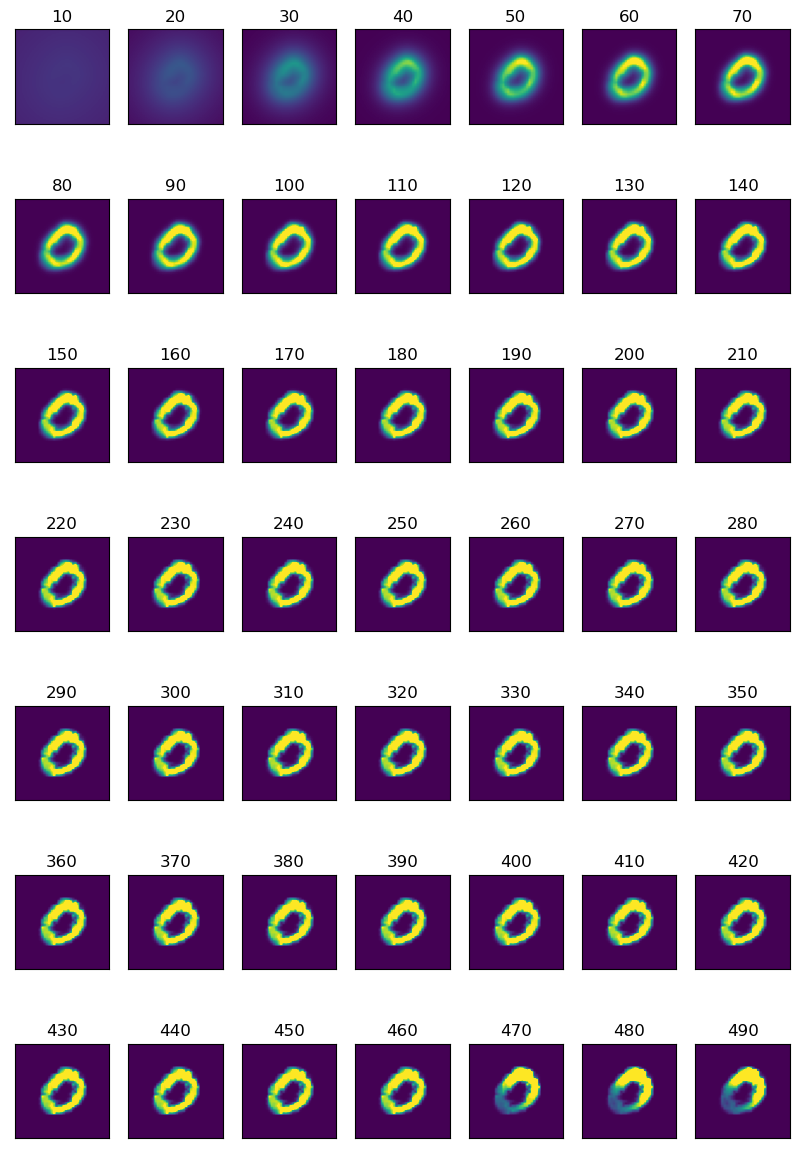

In [281]:
## Plot iterates
A = res6[1]

# Set up the axes
fig, axs = plt.subplots(7,7,figsize=(10,15))

# Iterate over the plotting locations
i = 0
for ax in axs.ravel():
    i = i + 1
    ax.imshow(np.reshape(A[:,i*10], (nb_pixel_side,nb_pixel_side)), vmin=0, vmax=0.005)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(i*10))

But from the 450 we use the second method, therefore the results become:

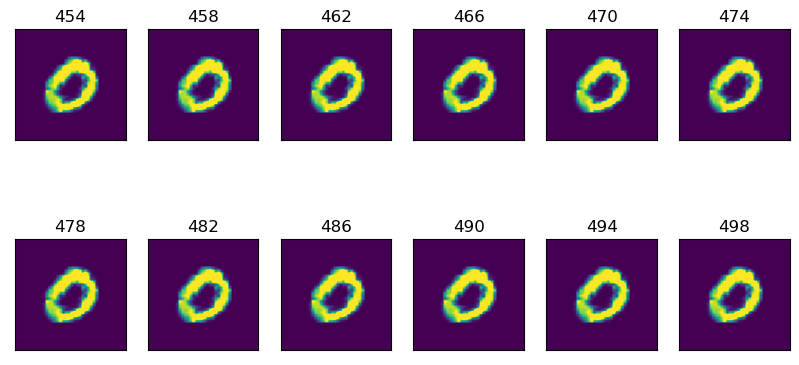

In [280]:
## Plot iterates
A = res7[1]

# Set up the axes
fig, axs = plt.subplots(2,6,figsize=(10,5))

# Iterate over the plotting locations
i = 0
for ax in axs.ravel():
    i = i + 1
    ax.imshow(np.reshape(A[:,i*4], (nb_pixel_side,nb_pixel_side)), vmin=0, vmax=0.005
             )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(450 + i*4))

Let's try with 3's

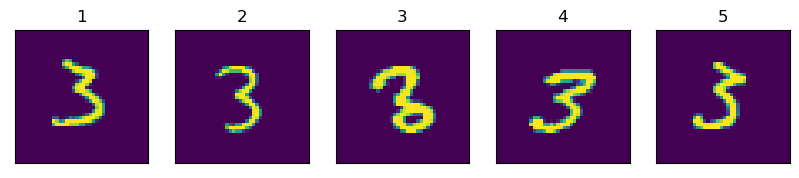

In [282]:
# Number of digits
N = 5

# List of probabilities
b = list( df_digits.loc[df_digits.int_0_9 == 3].reset_index().atoms.iloc[:N] )

# Visualisation
# Set up the axes
fig, axs = plt.subplots(1,N,figsize=(10,10))

# Iterate over the plotting locations
i = 0
for ax in axs.ravel():
    i = i + 1
    ax.imshow(np.reshape(b[i-1], (nb_pixel_side,nb_pixel_side)))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(i))

399 -th, precision :  0.0009108119948398336 norm u:  3.215121696507798e+129
399 -th, precision :  0.004581481459537181 norm u:  2.94572193763663e+135
399 -th, precision :  0.01978881586816206 norm u:  1.4731830491396473e+134
399 -th, precision :  0.0008206093110535588 norm u:  1.071096296289064e+147
399 -th, precision :  0.0029502025930953787 norm u:  2.73386934597724e+145
Kulback descent 0-th iteration, precision = 6.958104635036793e-05
399 -th, precision :  0.0008201428415002708 norm u:  2.6360555779656077e+129
399 -th, precision :  0.0042475067346384975 norm u:  2.6621083431070315e+135
399 -th, precision :  0.018331983125689857 norm u:  1.129525796424729e+134
399 -th, precision :  0.0008850173520782168 norm u:  1.078518737981898e+147
399 -th, precision :  0.0029865217080816504 norm u:  2.618215835542295e+145
Kulback descent 1-th iteration, precision = 0.00013917267728064453
399 -th, precision :  0.0007750008604995065 norm u:  2.390122897714913e+129
399 -th, precision :  0.0040783503

399 -th, precision :  0.005037197342892513 norm u:  1.8780257060759006e+148
399 -th, precision :  0.0036342344000415074 norm u:  2.8117414495650255e+144
Kulback descent 18-th iteration, precision = 0.0013876622328950438
399 -th, precision :  0.007158774442574897 norm u:  4.549962733070721e+126
399 -th, precision :  0.004836810692953313 norm u:  6.2313707549974035e+137
399 -th, precision :  0.003673404832614605 norm u:  6.8718116507971295e+137
399 -th, precision :  0.004448268494915381 norm u:  2.2324985464463812e+148
399 -th, precision :  0.003920925871526105 norm u:  3.180793392387479e+144
Kulback descent 19-th iteration, precision = 0.0014620614353295588
399 -th, precision :  0.006885312456488092 norm u:  4.778174929604125e+126
399 -th, precision :  0.00587723830529195 norm u:  6.814173771332905e+137
399 -th, precision :  0.0036713254611740066 norm u:  2.4577500575109003e+138
399 -th, precision :  0.0036749609043228463 norm u:  2.5539836477465408e+148
399 -th, precision :  0.00414287

399 -th, precision :  0.014794867368030859 norm u:  4.508162834083888e+128
399 -th, precision :  0.01555834311473346 norm u:  8.704604476241545e+129
399 -th, precision :  0.015821067490593112 norm u:  5.028666283565742e+145
399 -th, precision :  0.002709354639775055 norm u:  1.869004457648972e+151
399 -th, precision :  0.013806165998725412 norm u:  3.81455290180602e+141
Kulback descent 37-th iteration, precision = 0.0014131089130102901
399 -th, precision :  0.015633292390895354 norm u:  3.190903913731045e+128
399 -th, precision :  0.014916103437482921 norm u:  4.2904956251322e+129
399 -th, precision :  0.016436523092397598 norm u:  3.8979125061726277e+145
399 -th, precision :  0.003349460955891545 norm u:  2.4572725591542576e+151
399 -th, precision :  0.013865893086088779 norm u:  2.7438107436387908e+141
Kulback descent 38-th iteration, precision = 0.0013529958117976441
399 -th, precision :  0.016005810203361018 norm u:  1.7927574663255834e+128
399 -th, precision :  0.01448623350179510

399 -th, precision :  0.0007444571940879032 norm u:  1.21382276266014e+149
399 -th, precision :  0.020099192791473822 norm u:  1.9204182524653737e+143
Kulback descent 55-th iteration, precision = 0.0008295988167143402
399 -th, precision :  0.01916265064057871 norm u:  8.047186104227216e+125
399 -th, precision :  0.024370107849123815 norm u:  1.9149997427433586e+132
399 -th, precision :  0.005090306557175749 norm u:  8.049819359569453e+139
399 -th, precision :  0.0033611174960347704 norm u:  6.658953252819966e+148
399 -th, precision :  0.019937008688481486 norm u:  2.899539127994752e+143
Kulback descent 56-th iteration, precision = 0.0008074107943638507
399 -th, precision :  0.01996116186520461 norm u:  8.670501424330355e+125
399 -th, precision :  0.023789652871305644 norm u:  2.6559661769861957e+132
399 -th, precision :  0.007065381616425587 norm u:  1.9442434221331053e+139
399 -th, precision :  0.006147496566842486 norm u:  3.24404336767589e+148
399 -th, precision :  0.016382582378312

399 -th, precision :  0.031171044952331892 norm u:  4.315399294800343e+135
399 -th, precision :  0.00720531620716122 norm u:  9.49921541755778e+132
399 -th, precision :  0.018521260021676214 norm u:  1.4483629166290452e+144
399 -th, precision :  0.03833990092010128 norm u:  9.505731800604418e+139
Kulback descent 74-th iteration, precision = 0.0005480621303002105
399 -th, precision :  0.03808812308091309 norm u:  8.548107577172582e+123
399 -th, precision :  0.03125191558755759 norm u:  6.106319058143618e+135
399 -th, precision :  0.008149506896638948 norm u:  6.06110682490016e+132
399 -th, precision :  0.019039148905745224 norm u:  9.916374364675022e+143
399 -th, precision :  0.03890696730637039 norm u:  6.687828296220581e+139
Kulback descent 75-th iteration, precision = 0.0005381399669404564
399 -th, precision :  0.038370960109296984 norm u:  6.12200124781346e+123
399 -th, precision :  0.03149000110705719 norm u:  8.610079926699469e+135
399 -th, precision :  0.009090966841417683 norm u

399 -th, precision :  0.04164595642330723 norm u:  1.265796319477808e+121
399 -th, precision :  0.03571430960491863 norm u:  6.025904142013808e+137
399 -th, precision :  0.011377394817812804 norm u:  3.528727437249652e+130
399 -th, precision :  0.03535910997129328 norm u:  2.871695942130247e+142
399 -th, precision :  0.0491616792455262 norm u:  2.2410181256535468e+138
Kulback descent 93-th iteration, precision = 0.0003976640790448509
399 -th, precision :  0.042334862132664006 norm u:  1.0675348788855784e+121
399 -th, precision :  0.0357412032029259 norm u:  6.971086985125235e+137
399 -th, precision :  0.011423572266049693 norm u:  3.0636545327142267e+130
399 -th, precision :  0.03603834450204864 norm u:  2.638214358323263e+142
399 -th, precision :  0.049681250801106386 norm u:  2.0804958610454595e+138
Kulback descent 94-th iteration, precision = 0.0003915430290324596
399 -th, precision :  0.04297875080949158 norm u:  9.3034122632425e+120
399 -th, precision :  0.03575465893841658 norm u

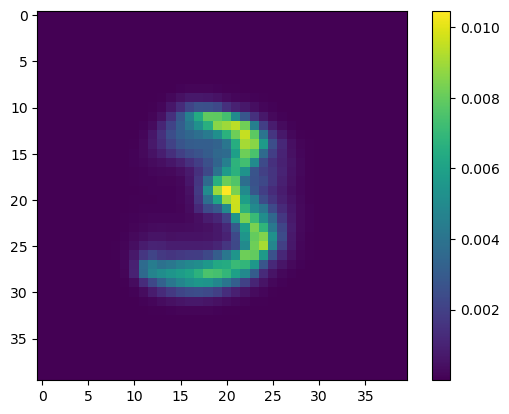

In [283]:
# Initalisation
a = np.ones(resolution) / resolution

# Results:
res = Kullback_descent(a, b, M, steps1=100 ,lambda_sinkhorn=15, iterations=400, t=0, t0=-10**-3)
a = res[0]

# Visualisation of the result
img = np.reshape(a, (nb_pixel_side,nb_pixel_side))
plt.imshow(img)
plt.colorbar()
plt.show()

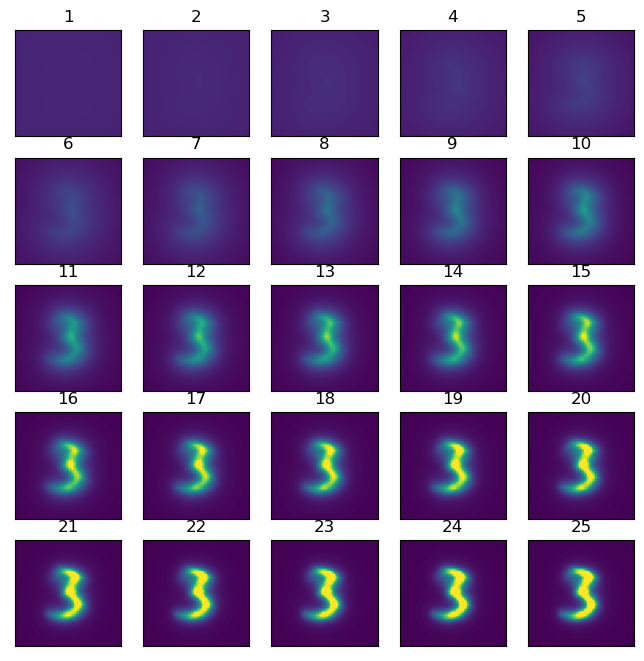

In [570]:
## Plot iterates
A = res[1]

# Set up the axes
fig, axs = plt.subplots(5,5,figsize=(8,8))

# Iterate over the plotting locations
i = 0
for ax in axs.ravel():
    i = i + 1
    ax.imshow(np.reshape(A[:,i*4], (nb_pixel_side,nb_pixel_side)), vmin=0, vmax=0.006)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(i))

The results are beyond my expectations, the starting 3's don't look alike at all and the final result is very clean !!

Last try with the 4's because according to the Sinkhorn distance matrix computed before, these digits don't really look alike.

Indeed some 4's are closed, while other are open, I wonder what will be the shape of the result.

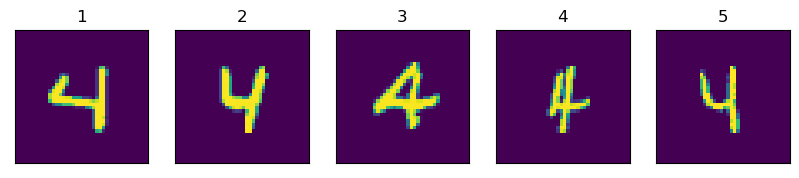

In [4]:
# Number of digits
N = 5

# List of probabilities
b = list( df_digits.loc[df_digits.int_0_9 == 4].reset_index().atoms.iloc[:N] )

# Visualisation
# Set up the axes
fig, axs = plt.subplots(1,N,figsize=(10,10))

# Iterate over the plotting locations
i = 0
for ax in axs.ravel():
    i = i + 1
    ax.imshow(np.reshape(b[i-1], (nb_pixel_side,nb_pixel_side)))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(i))

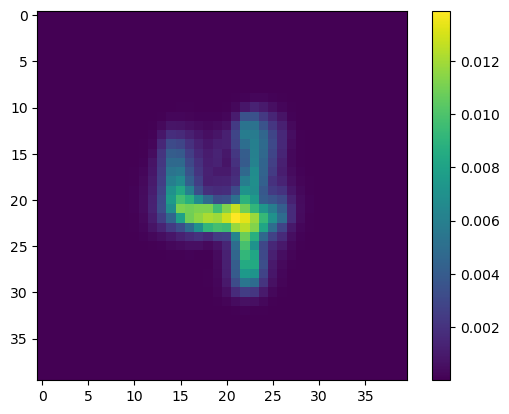

In [576]:
# Initalisation
a = np.ones(resolution) / resolution

# Results:
res = Kullback_descent(a, b, M, steps1=100 ,lambda_sinkhorn=15, iterations=400, t=0, t0=-10**-3)
a = res[0]

# Visualisation of the result
img = np.reshape(a, (nb_pixel_side,nb_pixel_side))
plt.imshow(img)
plt.colorbar()
plt.show()

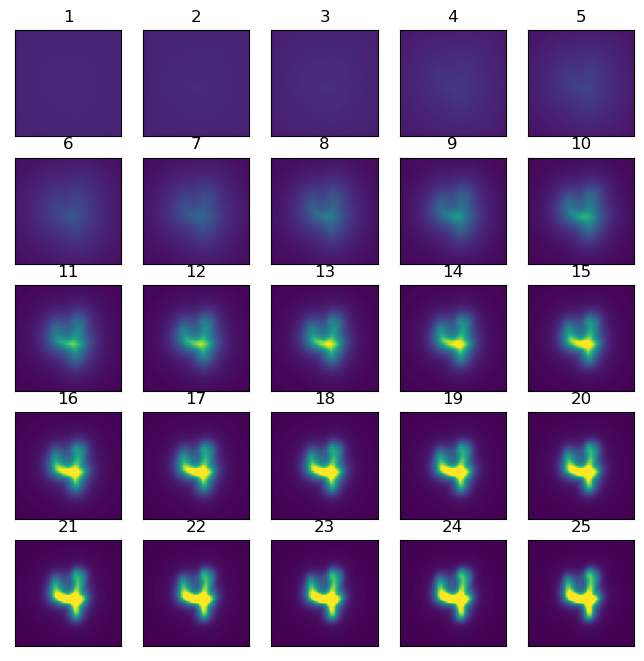

In [577]:
## Plot iterates
A = res[1]

# Set up the axes
fig, axs = plt.subplots(5,5,figsize=(8,8))

# Iterate over the plotting locations
i = 0
for ax in axs.ravel():
    i = i + 1
    ax.imshow(np.reshape(A[:,i*4], (nb_pixel_side,nb_pixel_side)), vmin=0, vmax=0.006)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(i))

#### Conclusions:
There are some parameters that demand more attention to be tuned efficiently:
- lambda
- t0
- t (eventhaugh t = 0 looks to be a sufficient initialisation)

The code takes some time to be computed (around 60s for 100 steps -algo 1- and 400 iterations -sinkhorn gradient).

According to 'Differential Properties of Sinkhorn Approximation for Learning' (Luise), the complexity of the sinhorn gradient computation is O(n x m x lambda/epsilon²) where epsilon define the accuracy of the solution, n = len(a), m = len(b[i]).

### Let's get the support optimized

According to the Cuturi's paper, the optimization on the support is doable only in the Euclidean space. Therefore we need to translate the location of pixels in the Euclidean/canonic space for R².


The following function turn the pixel notation into canonic base notation X (Nx1) to X_can (nb_of_atoms x 2).

to_base_pixel is the inverse of to_base_can.

In [99]:
# Building of a matrix m*2 that stores the atoms of the vector X (resolution x 1):
def to_base_can(X, nb_pixel_side=40):
    # focus on the 1s:
    J = X>0
    
    # initialize
    X_can = np.zeros((sum(J==True),2))
    
    j = 0
    i = 0
    for booleen in J:
        
        # only check ones:
        if booleen:
            # along the x axis 
            abscisse = j // nb_pixel_side
            # storing
            X_can[i,0] = abscisse
            #along the y axis
            X_can[i,1] = j - abscisse * nb_pixel_side
            
            # keep track in X
            i = i + 1
        
        # keep track in J
        j = j + 1
        
    return(X_can) 

# Turn the base can into the pixel base back:
def to_base_pixel(X_can, nb_pixel_side=40):
    X = np.zeros((nb_pixel_side**2))
    for x_ij in X_can:
        loc_pix = int(x_ij[0]) * nb_pixel_side + int(x_ij[1]) 
        #and NOT " loc_pix = int(np.round(x_ij[0]) * nb_pixel_side + np.round(x_ij[1])) " that is less precise
        X[loc_pix] = 1
    return(X)

Let's check the function is working correctly

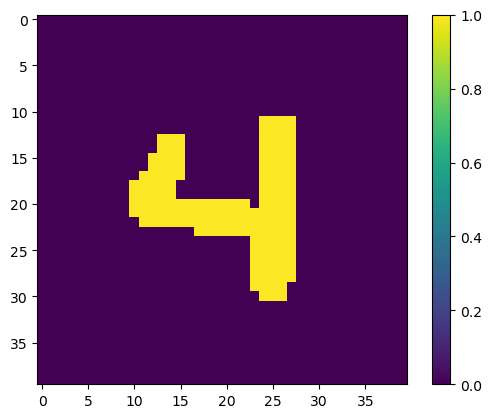

In [100]:
# List of aimed probabilities for a '4'
b = list( df_digits.loc[df_digits.int_0_9 == 4].reset_index().atoms.iloc[:1] )

# Support of b:
Y = np.ones(resolution) * (b[0]>0)

X = Y

# Visualisation of the result
img = np.reshape(to_base_pixel(to_base_can(X)), (nb_pixel_side,nb_pixel_side))
plt.imshow(img)
plt.colorbar()
plt.show()

Ok perfect.

We have the transformation from pixel vectors to Euclidiean base.

### Simple gradient descent on the support according to the Cuturi's method

Let's try a simple gradient descent on the support: I take a '0' and I try to get it back in term of support.

First I generate a random support.

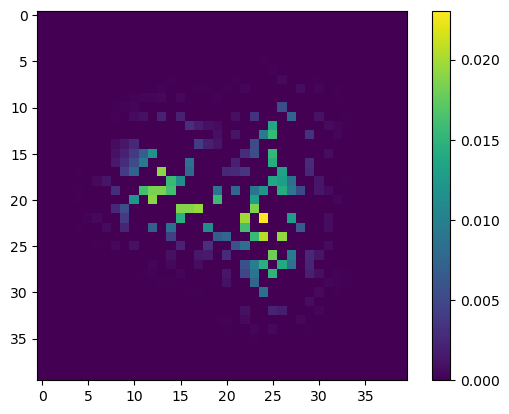

In [80]:
# List of aimed probabilities for a ''
b = list( df_digits.loc[df_digits.int_0_9 == 4].reset_index().atoms.iloc[:1] )

# Support of b:
Y = np.ones(resolution) * (b[0]>0)

# X is a random image with 500 white pixels
X = np.zeros(resolution)
X[:500] = 1
np.random.shuffle(X)

# Kullback_descent parameters:

# a is an optimized probability with Kullback_descent
a = X / sum(X)
a = Kullback_descent(a, b, M, 80)[0]
img = np.reshape(a, (nb_pixel_side,nb_pixel_side))
plt.imshow(img)
plt.colorbar()
plt.show()

This is a visualisation of a on the initial support X and the probability a once it is optimized thanks to the Kullback_descent, for 10 steps.

In [641]:
# X is a random image with 500 white pixels
X = np.zeros(resolution)
X[:500] = 1
np.random.shuffle(X)

# Initialisation
steps2 = 20
theta = 0.2

# Keep track
# in support
l_X = np.zeros((resolution,steps2+1))
l_X[:,0] = X
# in probabilities
A = np.zeros((resolution,steps2+1))

#gradient descent:
for i in range(steps2):
    
    # initialisation
    a = X / sum(X)
    # Kullback descent
    a = Kullback_descent(a, b, M, steps1=100, lambda_sinkhorn=15, iterations=400, t=0, t0=-10**-3)[0]
    # keep track
    A[:,i] = a
    
    #sinkhorn_descent to get T and the gradient for X
    I_X = X>0
    I_Y = Y>0
    T_pix = sinkhorn_descent(a, b[j], M, lambda_sinkhorn=15, iterations=400)[1]
    # selection of the lines and colums of interest
    T_pix = T_pix[I_X,:] # in term of X
    T_pix = T_pix[:,I_Y] # in term of Y
    # In the euclidean space
    YT = to_base_can(Y).T @ T_pix.T

    # Gradient:
    grad = YT @ np.diag(a[I_X]**-1)
    
    # X to Euclidean base:
    X = to_base_can(X)
    
    # Learning of X in the EUCLIDEAN SPACE:
    X = (1 - theta) * X + theta * grad.T

    # Back to the pixel base (to perform a on this new support on the next step)
    X = to_base_pixel(X)
    
    # Keep track
    # back to the pixel space
    l_X[:,i] = X


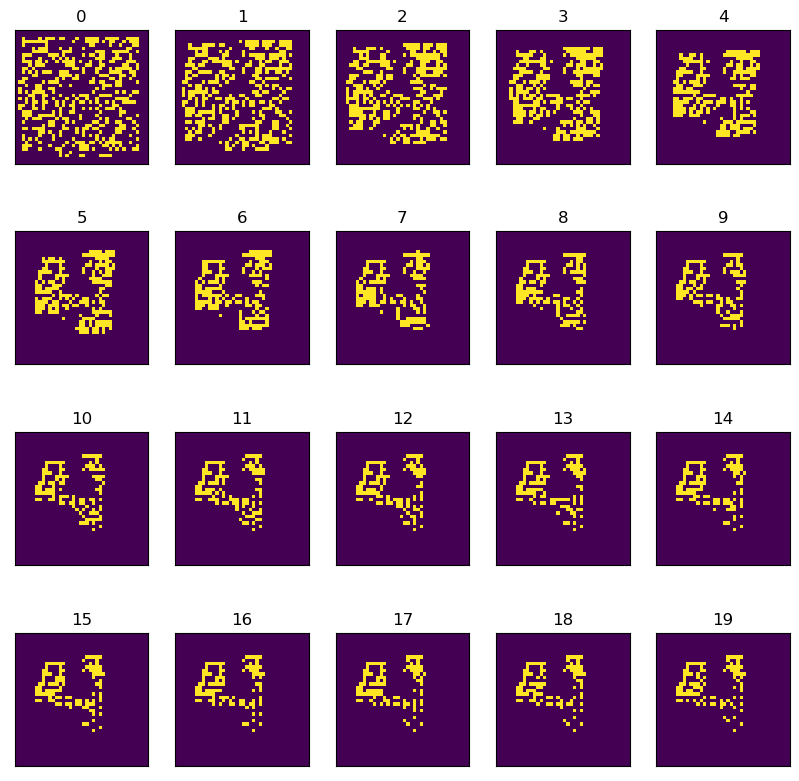

In [643]:
# Visualisation of the results
# Set up the axes
fig, axs = plt.subplots(4,5,figsize=(10,10))

# Iterate over the plotting locations
i = -1
for ax in axs.ravel():
    i = i + 1
    ax.imshow(np.reshape(l_X[:,i], (nb_pixel_side,nb_pixel_side))) #, vmin=0.86, vmax=0.93)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(i))

It is intersting to note that less and less pixels are used iteration after iteration. That is because the gradient follows the direction of the greater probabilities location. In other words, the pixels are superimposed on the same location. 

In fact after the 10th iteration, the support is not improving that much.
Maybe add a stopping criteria would do the work.

FIXME: add a stopping criteria ?

Text(0, 0.5, 'number of pixels')

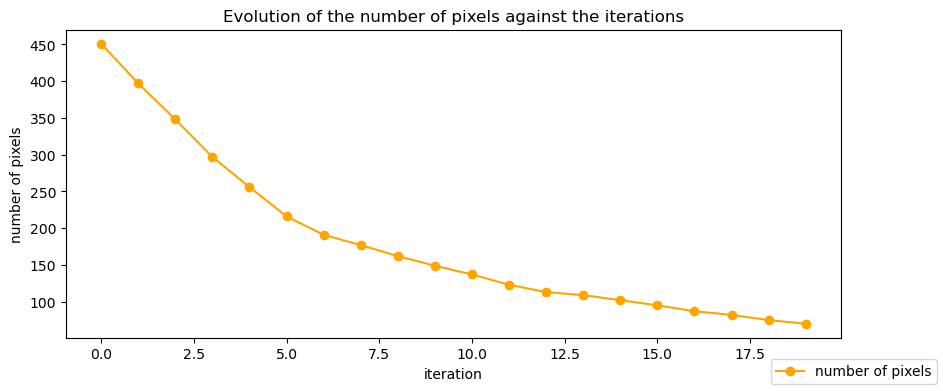

In [533]:
nb_pixels = [len(to_base_can(l_X[:,i])) for i in range(steps)]
nb_iterations = [i for i in range(steps)]
fig, ax1 = plt.subplots(figsize=(10,4))

ax1.plot(nb_iterations, nb_pixels, '-o', color='orange', label='number of pixels')
fig.legend(loc='lower right')
plt.title('Evolution of the number of pixels against the iterations')
ax1.set_xlabel('iteration')
ax1.set_ylabel("number of pixels")

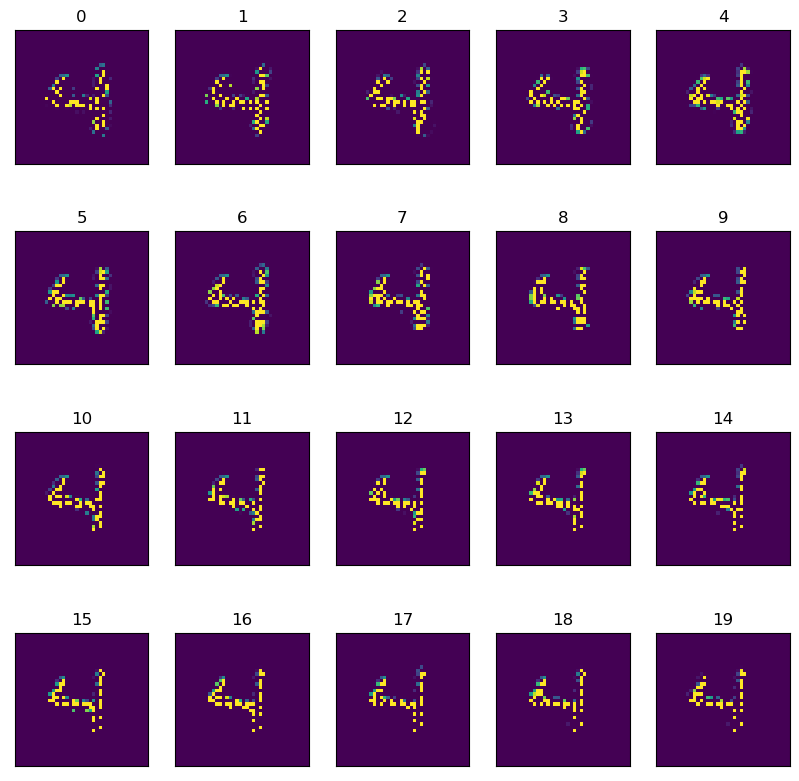

In [642]:
# Visualisation of the results
# Set up the axes
fig, axs = plt.subplots(4,5,figsize=(10,10))

# Iterate over the plotting locations
i = -1
for ax in axs.ravel():
    i = i + 1
    ax.imshow(np.reshape(A[:,i], (nb_pixel_side,nb_pixel_side)), vmin=0.0, vmax=0.01)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(i))

The parameter step1 is very important ! If the Kuhlback descent did not converge enough in probability the results are way less convincing ! 
I put step1 = 100 to be assured to get nice smooth results, but I should use a stopping criteria for a good enough precision to obtain good barycenter approximation in term of support.

If a is precise enough, only a few steps are enough to obtain a very good approximation of the support !

## Cuturi whole algorithm (algorithm 2 cf Cuturis paper)

In [235]:
# Standard parameters: 
# theta=0.2
# steps2=20
# iterations = 200
# steps1 = 100
# t=0
# t0=-10**-2
# lambda_sinkhorn=10
# precision_sinkhorn=10**-5

# This algorithm is presented as 'algorithm 2' in the paper 'Fast Computation of Wasserstein Barycenters' by Cuturi
def Cuturi_support_proba(X, b, Y, M, theta=0.2, steps2=20, step1=100, lambda_sinkhorn=10, iterations=200, t=0, t0=-10**-2, resolution=1600):
    
    # Keep track
    # in support
    l_X = np.zeros((resolution,steps2+1))
    # in probabilities
    A = np.zeros((resolution,steps2+1))
    # gradient:
    G = np.zeros((resolution,steps2+1))

    m = len(b)
    #gradient descent:
    for i in range(steps2):

        # initialisation
        a = X / sum(X)
        # Kullback descent 
        a = Kullback_descent(a, b, M, steps1, lambda_sinkhorn, iterations, t=0, t0=-10**-3)[0]
        # keep track
        A[:,i] = a

        #sinkhorn_descent to get T and the gradient for X
        I_X = X > 0
        # X to Euclidean base:
        X = to_base_can(X)

        #sinkhorn_descent to get T and the gradient for X
        grad = np.zeros(X.shape)
        for j in range(m):
            I_Y = Y[j] > 0
            T_pix = sinkhorn_descent(a, b[j], M, lambda_sinkhorn, iterations)[1]
            # selection of the lines and colums of interest
            T_pix = T_pix[I_X,:] # in term of X
            T_pix = T_pix[:,I_Y] # in term of Y
            # In the euclidean space
            TY = T_pix @ to_base_can(Y[j])

            # Gradient (times m):
            grad = grad + np.diag(a[I_X]**-1) @ TY
        grad = grad / m

        # Learning of X in the EUCLIDEAN SPACE:
        X = (1 - theta) * X + theta * grad 

        # Back to the pixel base (to perform a on this new support on the next step)
        X = to_base_pixel(X)

        # Keep track
        # back to the pixel space
        l_X[:,i] = X
        # grad
        G[:,i] = to_base_pixel(grad)

        # Stay informed:
        print(f"iteration {i}-th of the algorithm 2 of optimization of the support")

    #Output:
    return(X, a, l_X, A) #, G)

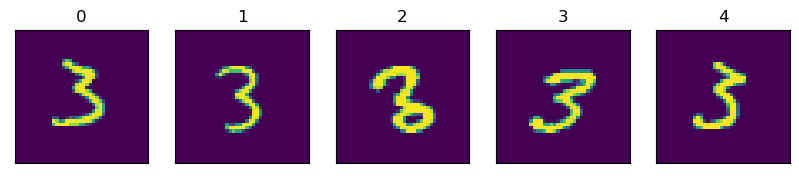

In [286]:
# Input
m = 5
# List of aimed probabilities for a '0'
b = list( df_digits.loc[df_digits.int_0_9 == 3].reset_index().atoms.iloc[:m] )

# Supports of b's:
Y = [np.ones(resolution) * (b[i]>0) for i in range(m)]

# X is a random image with 500 white pixels
X = np.zeros(resolution)
X[:500] = 1
np.random.shuffle(X)

# Visualisation of the inputs
# Set up the axes
fig, axs = plt.subplots(1,5,figsize=(10,10))

# Iterate over the plotting locations
i = -1
for ax in axs.ravel():
    i = i + 1
    ax.imshow(np.reshape(b[i], (nb_pixel_side,nb_pixel_side)))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(i))

In [ ]:
# Output
res2 = Cuturi_support_proba(X, b, Y, M, theta=0.2, steps2=15, step1=100, lambda_sinkhorn=15, iterations=400, t=0, t0=-10**-2)
l_X = res2[2]
A = res2[3]

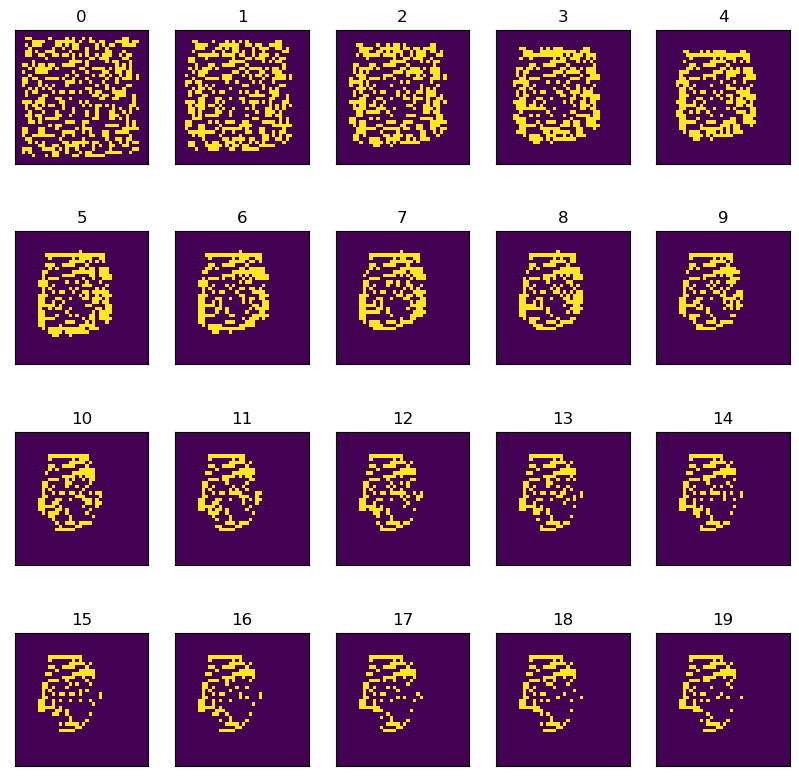

In [222]:
# Visualisation of the results
# Set up the axes
fig, axs = plt.subplots(4,5,figsize=(10,10))

# Iterate over the plotting locations
i = -1
for ax in axs.ravel():
    i = i + 1
    ax.imshow(np.reshape(l_X[:,i], (nb_pixel_side,nb_pixel_side)), vmin=0.0, vmax=0.01)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(i))

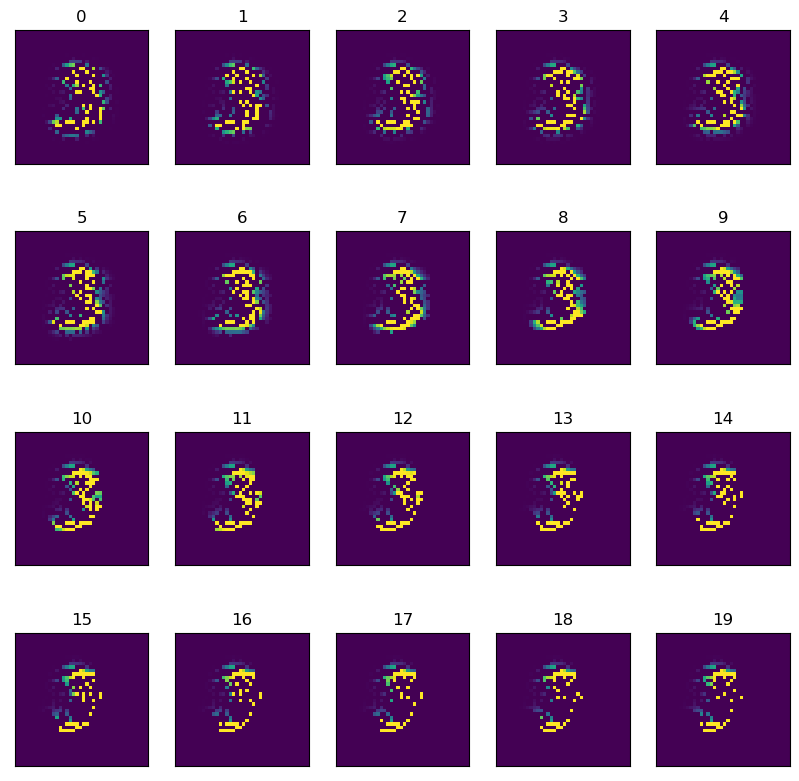

In [223]:
# Visualisation of the results
# Set up the axes
fig, axs = plt.subplots(4,5,figsize=(10,10))

# Iterate over the plotting locations
i = -1
for ax in axs.ravel():
    i = i + 1
    ax.imshow(np.reshape(A[:,i], (nb_pixel_side,nb_pixel_side)), vmin=0.0, vmax=0.01)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(i))

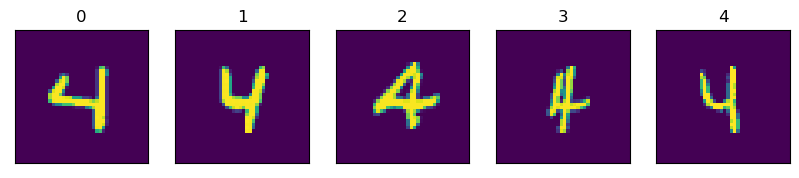

In [285]:
# Input
m = 5
# List of aimed probabilities for a '0'
b = list( df_digits.loc[df_digits.int_0_9 == 4].reset_index().atoms.iloc[:m] )

# Supports of b's:
Y = [np.ones(resolution) * (b[i]>0) for i in range(m)]

# X is a random image with 500 white pixels
X = np.zeros(resolution)
X[:500] = 1
np.random.shuffle(X)

# Visualisation of the inputs
# Set up the axes
fig, axs = plt.subplots(1,5,figsize=(10,10))

# Iterate over the plotting locations
i = -1
for ax in axs.ravel():
    i = i + 1
    ax.imshow(np.reshape(b[i], (nb_pixel_side,nb_pixel_side)))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(i))

199 -th, precision :  0.008309305652508717 norm u:  1.1568296510149499e+84
199 -th, precision :  0.006954477458814192 norm u:  1.5712681071408106e+85
199 -th, precision :  0.0028975933683789428 norm u:  2.192850875802217e+89
199 -th, precision :  0.0038423239333595324 norm u:  6.947712675914076e+91
199 -th, precision :  0.016240950396260195 norm u:  1.3143826490986721e+88
Kulback descent 0-th iteration, precision = 0.0001260203660913189
199 -th, precision :  0.00825189058479273 norm u:  1.072899956112341e+84
199 -th, precision :  0.0069618769971760575 norm u:  1.4697776549474764e+85
199 -th, precision :  0.0028833455571230927 norm u:  2.1470909632180738e+89
199 -th, precision :  0.0038615651601850132 norm u:  6.823548260158134e+91
199 -th, precision :  0.016305558094398143 norm u:  1.1907240049103665e+88
Kulback descent 1-th iteration, precision = 0.00025217426604577095
199 -th, precision :  0.008224190480099532 norm u:  1.033937696514251e+84
199 -th, precision :  0.006965476050912323 

Kulback descent 18-th iteration, precision = 0.002720283019131641
199 -th, precision :  0.008876488724336992 norm u:  3.4118419390891563e+81
199 -th, precision :  0.006492024682919895 norm u:  3.731150440355428e+83
199 -th, precision :  0.002336424411493034 norm u:  9.712067522796051e+88
199 -th, precision :  0.004605041019663587 norm u:  1.4435826001639977e+91
199 -th, precision :  0.010349044364974249 norm u:  1.8902642848679306e+88
Kulback descent 19-th iteration, precision = 0.0028947262371868186
199 -th, precision :  0.010521610015022066 norm u:  3.601467277531184e+81
199 -th, precision :  0.0076350062734850035 norm u:  6.893604706824816e+83
199 -th, precision :  0.002490893610638644 norm u:  9.35480029934104e+88
199 -th, precision :  0.004613274940082629 norm u:  1.1657383106514417e+91
199 -th, precision :  0.010626310902458731 norm u:  1.634741649006572e+88
Kulback descent 20-th iteration, precision = 0.0030679298201796196
199 -th, precision :  0.012279637872786029 norm u:  3.76

Kulback descent 37-th iteration, precision = 0.002995946060591171
199 -th, precision :  0.015064698703390656 norm u:  3.1487813216229876e+69
199 -th, precision :  0.006163613668587479 norm u:  7.649469870662968e+90
199 -th, precision :  0.020455348255056766 norm u:  1.939335918605815e+85
199 -th, precision :  0.003117355726297337 norm u:  6.781153656859414e+86
199 -th, precision :  0.005382372106686603 norm u:  2.381340704553852e+87
Kulback descent 38-th iteration, precision = 0.0028394324949588007
199 -th, precision :  0.013682217502018201 norm u:  7.281229926440126e+68
199 -th, precision :  0.00718569733978088 norm u:  1.2751102295664323e+91
199 -th, precision :  0.022743811818910224 norm u:  9.820333874003275e+84
199 -th, precision :  0.003356302949124414 norm u:  3.3586849610700834e+86
199 -th, precision :  0.005233276309977852 norm u:  3.533480479465164e+87
Kulback descent 39-th iteration, precision = 0.0026801322882441443
199 -th, precision :  0.012890453599767109 norm u:  1.9401

Kulback descent 56-th iteration, precision = 0.0013095199854252523
199 -th, precision :  0.021861909903069816 norm u:  2.8452686615779217e+64
199 -th, precision :  0.031289247521776704 norm u:  2.770149504706193e+90
199 -th, precision :  0.03660442602831238 norm u:  7.215860127230073e+80
199 -th, precision :  0.006256356870967743 norm u:  1.6814102932477908e+84
199 -th, precision :  0.01880941899846261 norm u:  2.7538794901086464e+84
Kulback descent 57-th iteration, precision = 0.0012867061664542918
199 -th, precision :  0.02415056086061823 norm u:  2.105353430717073e+64
199 -th, precision :  0.03164759801968987 norm u:  2.2608179657599286e+90
199 -th, precision :  0.03730994539391805 norm u:  7.380721321601925e+80
199 -th, precision :  0.006339351599303144 norm u:  1.4805165122193536e+84
199 -th, precision :  0.019060213778431836 norm u:  2.033173989208718e+84
Kulback descent 58-th iteration, precision = 0.001264866370336113
199 -th, precision :  0.026946831110471428 norm u:  1.364449

199 -th, precision :  0.035275677005535244 norm u:  1.1332345765417003e+61
199 -th, precision :  0.03082687752512284 norm u:  9.092474941216426e+89
199 -th, precision :  0.036863302785848706 norm u:  6.255670108656494e+80
199 -th, precision :  0.010984748862811696 norm u:  4.7974766297264206e+83
199 -th, precision :  0.022841989776796915 norm u:  3.1220004162240247e+83
Kulback descent 76-th iteration, precision = 0.0009167989262239266
199 -th, precision :  0.03530335522231683 norm u:  1.1198837870568547e+61
199 -th, precision :  0.03089199414844268 norm u:  8.683766672069571e+89
199 -th, precision :  0.03624802389282108 norm u:  6.141097873486982e+80
199 -th, precision :  0.01114940240441633 norm u:  4.593868560463447e+83
199 -th, precision :  0.02315272551473247 norm u:  2.924961580233625e+83
Kulback descent 77-th iteration, precision = 0.0009003410566831162
199 -th, precision :  0.03538062670389987 norm u:  1.111718449506997e+61
199 -th, precision :  0.031002270242791792 norm u:  8.2

Kulback descent 94-th iteration, precision = 0.0006762382249744349
199 -th, precision :  0.04087570402926488 norm u:  9.675054742524176e+60
199 -th, precision :  0.034673967751051346 norm u:  3.7386883077102516e+89
199 -th, precision :  0.027270797622693084 norm u:  1.532566422359017e+80
199 -th, precision :  0.014507773481390327 norm u:  2.2216423143292814e+83
199 -th, precision :  0.02919802111346739 norm u:  6.113697963302981e+82
Kulback descent 95-th iteration, precision = 0.0006646784631992525
199 -th, precision :  0.04129078333676436 norm u:  9.295504895380646e+60
199 -th, precision :  0.034776539278602095 norm u:  3.615223458888807e+89
199 -th, precision :  0.0271433020677331 norm u:  1.4198055555573427e+80
199 -th, precision :  0.014682768712366142 norm u:  2.12478185791191e+83
199 -th, precision :  0.02954903700506829 norm u:  5.5498016731046164e+82
Kulback descent 96-th iteration, precision = 0.0006533067715083726
199 -th, precision :  0.04170748175875676 norm u:  8.880328255

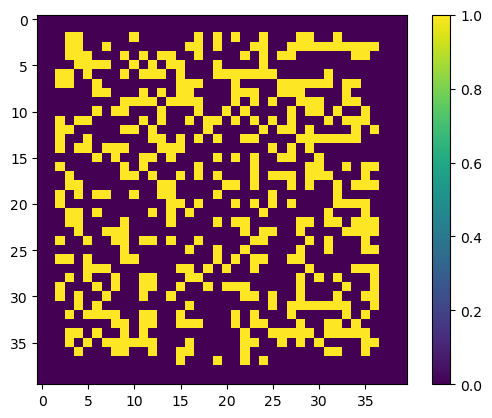

iteration 0-th of the algorithm 2 of optimization of the support
199 -th, precision :  0.016135860034616135 norm u:  4.839410727586605e+74
199 -th, precision :  0.0100607737171672 norm u:  1.7841898870962537e+75
199 -th, precision :  0.006319678495262239 norm u:  5.132170840151801e+79
199 -th, precision :  0.00427525867237842 norm u:  1.1218653777707376e+81
199 -th, precision :  0.014799327655426034 norm u:  2.9943710487604547e+78
Kulback descent 0-th iteration, precision = 0.00011620189034207507
199 -th, precision :  0.016039130756799615 norm u:  4.305044057609795e+74
199 -th, precision :  0.01003216859234626 norm u:  1.6201918219198398e+75
199 -th, precision :  0.006337258774385752 norm u:  4.884819010449279e+79
199 -th, precision :  0.004305496800666167 norm u:  1.0713937941166645e+81
199 -th, precision :  0.014844467580878843 norm u:  2.6941044449372777e+78
Kulback descent 1-th iteration, precision = 0.00023241502265792643
199 -th, precision :  0.015991207223625674 norm u:  4.06370

199 -th, precision :  0.02123256978612048 norm u:  3.0440321983780547e+74
Kulback descent 18-th iteration, precision = 0.00244531260435057
199 -th, precision :  0.006055543858892864 norm u:  3.8058014700889625e+69
199 -th, precision :  0.014068500509507762 norm u:  1.8923716741473764e+71
199 -th, precision :  0.00367752556596621 norm u:  4.847826196603692e+77
199 -th, precision :  0.004946742855888277 norm u:  2.0519740550115808e+79
199 -th, precision :  0.021170312100072777 norm u:  9.131496967192635e+73
Kulback descent 19-th iteration, precision = 0.002603629484377158
199 -th, precision :  0.004409485339245744 norm u:  1.0753672764081432e+69
199 -th, precision :  0.015358002555054834 norm u:  6.075280608428764e+70
199 -th, precision :  0.003113636442791925 norm u:  2.7503407975814555e+77
199 -th, precision :  0.004736998586841848 norm u:  1.297869542002742e+79
199 -th, precision :  0.01913234387725373 norm u:  2.8190379941286404e+73
Kulback descent 20-th iteration, precision = 0.0027

199 -th, precision :  0.0016114696239535107 norm u:  1.4905577746918775e+74
199 -th, precision :  0.007412379063842364 norm u:  2.868747571582419e+68
Kulback descent 37-th iteration, precision = 0.0028570254421723513
199 -th, precision :  0.021478748383367274 norm u:  3.57576149592278e+56
199 -th, precision :  0.007206607896294312 norm u:  1.4942881350953036e+72
199 -th, precision :  0.020746764328106064 norm u:  8.517828734395181e+71
199 -th, precision :  0.001548309661506504 norm u:  7.509295394947973e+73
199 -th, precision :  0.007709789850109715 norm u:  4.042766685329997e+68
Kulback descent 38-th iteration, precision = 0.0026864405901635886
199 -th, precision :  0.022210409345761267 norm u:  1.1905748661299463e+56
199 -th, precision :  0.008816441494405214 norm u:  2.3652390527171202e+72
199 -th, precision :  0.02438309550049414 norm u:  2.297095072121475e+71
199 -th, precision :  0.001302761142256346 norm u:  4.0438962292549345e+73
199 -th, precision :  0.00810250606573025 norm u

199 -th, precision :  0.005741448411680429 norm u:  4.658763215488452e+71
199 -th, precision :  0.017706109217709556 norm u:  2.0932130397981932e+68
Kulback descent 56-th iteration, precision = 0.0011880042099677536
199 -th, precision :  0.04477506741680148 norm u:  2.303063526192534e+50
199 -th, precision :  0.018695674749582464 norm u:  1.5432658941500572e+72
199 -th, precision :  0.03178473281163817 norm u:  7.411793713665287e+67
199 -th, precision :  0.005707194224979843 norm u:  4.1121984032646613e+71
199 -th, precision :  0.01900512218803976 norm u:  1.3029595130583394e+68
Kulback descent 57-th iteration, precision = 0.0011658865006868248
199 -th, precision :  0.046182671375917805 norm u:  1.697709315961249e+50
199 -th, precision :  0.018999918701425707 norm u:  1.3648890454339818e+72
199 -th, precision :  0.032079559058694064 norm u:  5.423489569265006e+67
199 -th, precision :  0.005667971265606343 norm u:  3.6859319455503444e+71
199 -th, precision :  0.020184027255831467 norm u

199 -th, precision :  0.006375662510368956 norm u:  7.510360019373294e+70
199 -th, precision :  0.03270983656268264 norm u:  3.728610779769135e+67
Kulback descent 75-th iteration, precision = 0.0007994419997281447
199 -th, precision :  0.05688932278496732 norm u:  1.6401929580562234e+48
199 -th, precision :  0.021304951751671672 norm u:  2.6720141220971606e+71
199 -th, precision :  0.036669116532613975 norm u:  2.5141707243993647e+67
199 -th, precision :  0.006363986510308486 norm u:  6.794516693679982e+70
199 -th, precision :  0.03302435253575149 norm u:  3.7458804645458737e+67
Kulback descent 76-th iteration, precision = 0.0007839849474600725
199 -th, precision :  0.05725121073479841 norm u:  1.622989067970251e+48
199 -th, precision :  0.021647662128620262 norm u:  2.5668334198983177e+71
199 -th, precision :  0.03693996009164254 norm u:  2.5551019308031203e+67
199 -th, precision :  0.006368085609333857 norm u:  6.166088950663504e+70
199 -th, precision :  0.0333922286808382 norm u:  3

199 -th, precision :  0.007373738404311011 norm u:  1.574671541389533e+70
199 -th, precision :  0.04170513506053913 norm u:  2.438040166032736e+67
Kulback descent 94-th iteration, precision = 0.0005563723453511925
199 -th, precision :  0.06354205121568014 norm u:  1.9519064696718393e+48
199 -th, precision :  0.02883022388956075 norm u:  1.2953756750230658e+71
199 -th, precision :  0.038792378396244824 norm u:  1.2686528682837771e+67
199 -th, precision :  0.007418177488646355 norm u:  1.4563459648835342e+70
199 -th, precision :  0.042037389889828816 norm u:  2.3340233973311527e+67
Kulback descent 95-th iteration, precision = 0.0005459990021348839
199 -th, precision :  0.06380506628815866 norm u:  1.9488671371544528e+48
199 -th, precision :  0.028998386076653202 norm u:  1.2546054510737426e+71
199 -th, precision :  0.038866645398981 norm u:  1.1758931630516146e+67
199 -th, precision :  0.007459908117434064 norm u:  1.346197343100183e+70
199 -th, precision :  0.042374608432552516 norm u: 

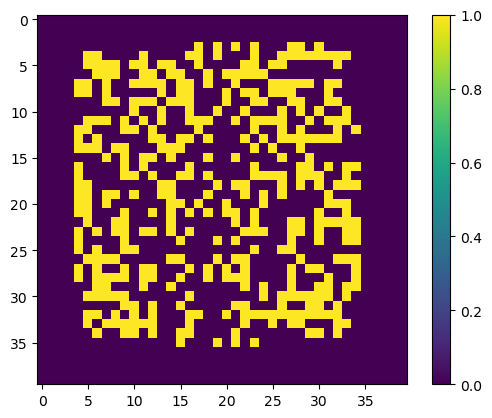

iteration 1-th of the algorithm 2 of optimization of the support
199 -th, precision :  0.024531922619462142 norm u:  5.664652441872959e+65
199 -th, precision :  0.019043028818737512 norm u:  6.830239214422612e+65
199 -th, precision :  0.007188618987203204 norm u:  5.434024784002754e+69
199 -th, precision :  0.005216885558906332 norm u:  1.9423885454263312e+70
199 -th, precision :  0.016452971965267956 norm u:  3.3871963279793555e+68
Kulback descent 0-th iteration, precision = 0.00011325864694591397
199 -th, precision :  0.024492853787876682 norm u:  4.905293865022881e+65
199 -th, precision :  0.01897772141947376 norm u:  5.949999872756377e+65
199 -th, precision :  0.007183784113649536 norm u:  5.167442294069104e+69
199 -th, precision :  0.005224567425374494 norm u:  1.7528522723464333e+70
199 -th, precision :  0.01651056878345876 norm u:  2.990872570089725e+68
Kulback descent 1-th iteration, precision = 0.00022640233931711852
199 -th, precision :  0.02447430688426183 norm u:  4.5678862

199 -th, precision :  0.01339961509218004 norm u:  7.502783859247235e+58
199 -th, precision :  0.021506142294990472 norm u:  8.423634379757459e+59
199 -th, precision :  0.008881032433947245 norm u:  3.0836083599175323e+66
199 -th, precision :  0.005457787044439729 norm u:  1.964425502113494e+67
199 -th, precision :  0.02096087828729973 norm u:  3.870165844360742e+62
Kulback descent 19-th iteration, precision = 0.0024183800257380405
199 -th, precision :  0.009709886524773644 norm u:  1.3139216657909396e+58
199 -th, precision :  0.02125248988953121 norm u:  1.6774029786514494e+59
199 -th, precision :  0.007443407191367705 norm u:  1.1988560779324497e+66
199 -th, precision :  0.005265809505962071 norm u:  9.907549464461654e+66
199 -th, precision :  0.02013533635298466 norm u:  8.624714746574597e+61
Kulback descent 20-th iteration, precision = 0.0025559067223985335
199 -th, precision :  0.006411711804547983 norm u:  2.5247839525229882e+57
199 -th, precision :  0.022262118193956154 norm u: 

199 -th, precision :  0.006552808506093652 norm u:  9.790399556235505e+60
199 -th, precision :  0.020739774706341238 norm u:  6.987492190434166e+58
199 -th, precision :  0.00046214145656598256 norm u:  1.4346975548009668e+61
199 -th, precision :  0.0017567496457247605 norm u:  4.272204889015359e+58
Kulback descent 38-th iteration, precision = 0.0023774806181848375
199 -th, precision :  0.030265374828885243 norm u:  4.9203170047357764e+45
199 -th, precision :  0.008196863668447504 norm u:  1.761895755905088e+61
199 -th, precision :  0.022255063078913544 norm u:  3.008616124023895e+58
199 -th, precision :  3.711618726012189e-05 norm u:  8.785941587076055e+60
199 -th, precision :  0.0013515148735377168 norm u:  5.837520680026343e+58
Kulback descent 39-th iteration, precision = 0.0022291685124648077
199 -th, precision :  0.030777795317960703 norm u:  2.64533418137597e+45
199 -th, precision :  0.010254513006074273 norm u:  2.7430929919475123e+61
199 -th, precision :  0.024297366361015794 no

199 -th, precision :  0.036567599169724616 norm u:  2.0728910036585462e+43
199 -th, precision :  0.019516008385343946 norm u:  2.3289394246673953e+61
199 -th, precision :  0.03127627917694744 norm u:  8.367940369500611e+55
199 -th, precision :  0.008300054854628966 norm u:  1.5041310085019665e+59
199 -th, precision :  0.014198695910611356 norm u:  4.344915898003557e+57
Kulback descent 57-th iteration, precision = 0.001096181885522427
199 -th, precision :  0.03638839893327174 norm u:  1.787359978059777e+43
199 -th, precision :  0.020803530314544964 norm u:  2.0904187017964238e+61
199 -th, precision :  0.03240458644760077 norm u:  7.818926020374984e+55
199 -th, precision :  0.008416003734658348 norm u:  1.454535811724869e+59
199 -th, precision :  0.014412808318209841 norm u:  2.4863065586161653e+57
Kulback descent 58-th iteration, precision = 0.001076111463079501
199 -th, precision :  0.036288625042868325 norm u:  1.5612302831435254e+43
199 -th, precision :  0.02224290153804645 norm u:  

199 -th, precision :  0.030762763476838536 norm u:  8.68474386559052e+59
199 -th, precision :  0.03814233838609238 norm u:  6.214482826365267e+55
199 -th, precision :  0.010000497828217117 norm u:  8.829453353884207e+58
199 -th, precision :  0.018684941984618956 norm u:  5.10084817618823e+55
Kulback descent 76-th iteration, precision = 0.0007209316205194692
199 -th, precision :  0.04054373789878473 norm u:  3.321007495539228e+42
199 -th, precision :  0.030829118205916564 norm u:  8.74455509755161e+59
199 -th, precision :  0.03844480758789286 norm u:  6.208086370443168e+55
199 -th, precision :  0.010059988592058564 norm u:  8.334398571999456e+58
199 -th, precision :  0.018936626790082442 norm u:  4.558117455299532e+55
Kulback descent 77-th iteration, precision = 0.0007084473875743493
199 -th, precision :  0.04080661807931453 norm u:  3.131536780355635e+42
199 -th, precision :  0.03092141267179241 norm u:  8.900915310519743e+59
199 -th, precision :  0.03871648074620198 norm u:  6.1893730

199 -th, precision :  0.044889024492167764 norm u:  1.3563849813570684e+42
199 -th, precision :  0.03304808102369313 norm u:  1.6544216488880174e+60
199 -th, precision :  0.043896389795198575 norm u:  1.6797640317469894e+55
199 -th, precision :  0.010741541429216234 norm u:  2.2369312798729322e+58
199 -th, precision :  0.023203061556802268 norm u:  8.009965526570884e+54
Kulback descent 95-th iteration, precision = 0.0005263367835359493
199 -th, precision :  0.04509128531529059 norm u:  1.299971630922636e+42
199 -th, precision :  0.03302014991938299 norm u:  1.685032392472825e+60
199 -th, precision :  0.04393525250939962 norm u:  1.4196636743378115e+55
199 -th, precision :  0.010758745480616953 norm u:  2.058543428845216e+58
199 -th, precision :  0.023420306048966354 norm u:  7.389551681451063e+54
Kulback descent 96-th iteration, precision = 0.0005177275558535269
199 -th, precision :  0.04528924381275743 norm u:  1.2468517992870758e+42
199 -th, precision :  0.03298083766474368 norm u:  

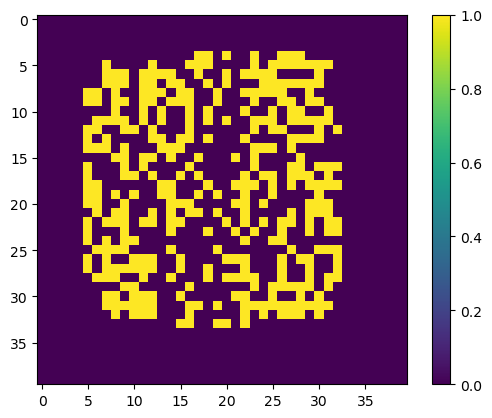

iteration 2-th of the algorithm 2 of optimization of the support
199 -th, precision :  0.03399008702937822 norm u:  1.4355058135252835e+60
199 -th, precision :  0.02258922974670712 norm u:  7.151882848628811e+58
199 -th, precision :  0.017899849391306673 norm u:  1.269637606536666e+63
199 -th, precision :  0.007538506456550145 norm u:  1.1389387003922689e+63
199 -th, precision :  0.020238927952700186 norm u:  1.1219414766471596e+62
Kulback descent 0-th iteration, precision = 0.00011868014404304143
199 -th, precision :  0.03387895158018383 norm u:  1.2036625423530974e+60
199 -th, precision :  0.02252838248386023 norm u:  6.052141262651519e+58
199 -th, precision :  0.01806500284033705 norm u:  1.1360010415258446e+63
199 -th, precision :  0.007570266805352395 norm u:  9.886920114402474e+62
199 -th, precision :  0.020317343082152804 norm u:  9.613972696729778e+61
Kulback descent 1-th iteration, precision = 0.0002369710577729014
199 -th, precision :  0.033822085174433365 norm u:  1.10314786

199 -th, precision :  0.025723046410592268 norm u:  8.900879248014879e+55
Kulback descent 18-th iteration, precision = 0.002155463265888608
199 -th, precision :  0.014034875238819052 norm u:  1.899119382082608e+52
199 -th, precision :  0.025148023961183392 norm u:  6.11567433511356e+51
199 -th, precision :  0.014986221838599594 norm u:  1.0128651746721763e+58
199 -th, precision :  0.006933823200350699 norm u:  3.1616546186319063e+58
199 -th, precision :  0.02534718084746257 norm u:  1.615003224466379e+55
Kulback descent 19-th iteration, precision = 0.00226691743134501
199 -th, precision :  0.022009985037313797 norm u:  8.12926967903902e+51
199 -th, precision :  0.02756127031690646 norm u:  7.736367128529285e+50
199 -th, precision :  0.013261013079740112 norm u:  1.7517104460592807e+57
199 -th, precision :  0.006787208436746074 norm u:  1.1406408831922536e+58
199 -th, precision :  0.02645330557044113 norm u:  2.6671032313785188e+54
Kulback descent 20-th iteration, precision = 0.00237687

199 -th, precision :  0.0010142182387145174 norm u:  2.2847090360506104e+52
199 -th, precision :  0.000715735997912061 norm u:  1.616871987042119e+47
Kulback descent 37-th iteration, precision = 0.0024190019540310465
199 -th, precision :  0.035948418743953915 norm u:  1.1497420043888334e+42
199 -th, precision :  0.00521506406562923 norm u:  1.1705639153749222e+49
199 -th, precision :  0.02413302255235356 norm u:  4.60195597033738e+50
199 -th, precision :  6.32131038538499e-05 norm u:  1.802737594789804e+52
199 -th, precision :  0.00058491423907711 norm u:  2.1351437109306798e+47
Kulback descent 38-th iteration, precision = 0.0023019110306949325
199 -th, precision :  0.036256386836837066 norm u:  3.811239393939971e+41
199 -th, precision :  0.006154981303544186 norm u:  1.8033964705687962e+49
199 -th, precision :  0.024843989911040705 norm u:  3.6505264132719476e+50
199 -th, precision :  0.0010251332097806144 norm u:  1.4657115441186707e+52
199 -th, precision :  0.0003299208459680336 nor

199 -th, precision :  0.0227523406017474 norm u:  2.8702394268865113e+50
199 -th, precision :  0.008980494184168646 norm u:  4.175985458563315e+51
199 -th, precision :  0.00775960076303921 norm u:  1.2956740335476536e+46
Kulback descent 56-th iteration, precision = 0.0011002255011179922
199 -th, precision :  0.047204964362275226 norm u:  6.632636395328571e+38
199 -th, precision :  0.017006186768301262 norm u:  6.36523992435298e+48
199 -th, precision :  0.021376261886426898 norm u:  2.5836638099060197e+50
199 -th, precision :  0.00920163751594994 norm u:  4.214036994243424e+51
199 -th, precision :  0.007761945836241839 norm u:  1.1107239217213391e+46
Kulback descent 57-th iteration, precision = 0.0010801489899670159
199 -th, precision :  0.04836840193734991 norm u:  6.346873652960418e+38
199 -th, precision :  0.017417982936942505 norm u:  5.53150336949715e+48
199 -th, precision :  0.019185191471665447 norm u:  2.2363008853877942e+50
199 -th, precision :  0.009404340802106007 norm u:  4.

199 -th, precision :  0.020465561941223554 norm u:  1.2518354321927417e+48
199 -th, precision :  0.0058670324411425594 norm u:  1.6348613857246358e+47
199 -th, precision :  0.01095891082109108 norm u:  5.3163318717392295e+51
199 -th, precision :  0.007474404427941388 norm u:  8.207846593333775e+44
Kulback descent 75-th iteration, precision = 0.0007263106146779548
199 -th, precision :  0.059269337091679926 norm u:  3.494437141270415e+38
199 -th, precision :  0.020506453813276388 norm u:  1.1749400054785306e+48
199 -th, precision :  0.005994291174562424 norm u:  1.2382314315848491e+47
199 -th, precision :  0.011101435323190731 norm u:  5.350676717674964e+51
199 -th, precision :  0.0074927114803416735 norm u:  7.606626564070124e+44
Kulback descent 76-th iteration, precision = 0.0007110366696866366
199 -th, precision :  0.059587106535319095 norm u:  3.419064205605788e+38
199 -th, precision :  0.020532649063094037 norm u:  1.1084527134010984e+48
199 -th, precision :  0.006155454262614094 no

199 -th, precision :  0.0635565100007218 norm u:  2.3845864262645432e+38
199 -th, precision :  0.020700541769548164 norm u:  6.752935972711357e+47
199 -th, precision :  0.008854609256663641 norm u:  5.133711019573341e+45
199 -th, precision :  0.013260026595086082 norm u:  3.816998142166318e+51
199 -th, precision :  0.008838433728807663 norm u:  4.5390558476097476e+44
Kulback descent 94-th iteration, precision = 0.0005018710817882696
199 -th, precision :  0.06374567921422927 norm u:  2.3405291074569355e+38
199 -th, precision :  0.02074350655870411 norm u:  6.672177726325237e+47
199 -th, precision :  0.008815349922333888 norm u:  4.5533558124532735e+45
199 -th, precision :  0.013338170432057178 norm u:  3.666120624347252e+51
199 -th, precision :  0.008989043185681587 norm u:  4.57427535899329e+44
Kulback descent 95-th iteration, precision = 0.0004927245465935036
199 -th, precision :  0.06393683120123206 norm u:  2.298349166530434e+38
199 -th, precision :  0.020793152231521905 norm u:  6.

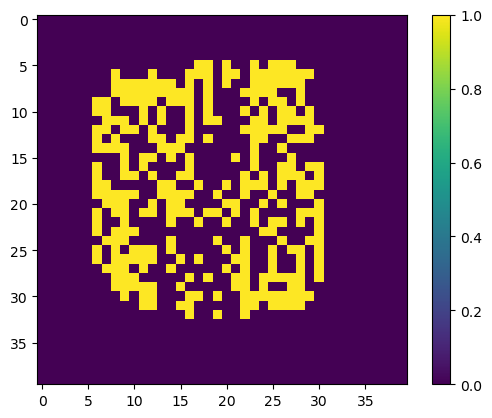

iteration 3-th of the algorithm 2 of optimization of the support
199 -th, precision :  0.04228891101106193 norm u:  2.4939452330886082e+57
199 -th, precision :  0.0245005379303004 norm u:  4.080237662736887e+55
199 -th, precision :  0.017439174283867622 norm u:  2.4804515940720156e+59
199 -th, precision :  0.00899106260007083 norm u:  9.56127223344944e+58
199 -th, precision :  0.02511372955822608 norm u:  5.157228864410798e+58
Kulback descent 0-th iteration, precision = 0.00012920214703875379
199 -th, precision :  0.04241689625775646 norm u:  2.0340177244327944e+57
199 -th, precision :  0.02529219292171592 norm u:  3.453246336060852e+55
199 -th, precision :  0.017350005623303442 norm u:  2.247899760147075e+59
199 -th, precision :  0.008950627412829284 norm u:  8.730870816277402e+58
199 -th, precision :  0.025402691886054086 norm u:  4.4171336851139496e+58
Kulback descent 1-th iteration, precision = 0.0002578062901800702
199 -th, precision :  0.0424720226215572 norm u:  1.83734737620342

199 -th, precision :  0.042792837543763805 norm u:  5.251656904129375e+51
Kulback descent 18-th iteration, precision = 0.002088744845595848
199 -th, precision :  0.021800371358557984 norm u:  3.6648479867075922e+50
199 -th, precision :  0.025905306164736873 norm u:  3.355264035019673e+47
199 -th, precision :  0.02514728665490868 norm u:  1.5153416753664515e+53
199 -th, precision :  0.00871392475757588 norm u:  1.9185672592488804e+53
199 -th, precision :  0.039390557694440366 norm u:  4.328329482406269e+50
Kulback descent 19-th iteration, precision = 0.002165997471928737
199 -th, precision :  0.02118508128484708 norm u:  6.106955827997354e+49
199 -th, precision :  0.031349222588563264 norm u:  3.954957002077175e+46
199 -th, precision :  0.019206929310731154 norm u:  1.3654901399619026e+52
199 -th, precision :  0.00839059496713067 norm u:  4.790210498135676e+52
199 -th, precision :  0.03558796659020989 norm u:  3.74698437380176e+49
Kulback descent 20-th iteration, precision = 0.002237747

199 -th, precision :  0.0010857156285524801 norm u:  1.5266592651934192e+46
199 -th, precision :  0.006365001408336604 norm u:  1.9160112512794713e+37
Kulback descent 37-th iteration, precision = 0.002184872581922513
199 -th, precision :  0.007544367297222866 norm u:  2.5210719261795312e+39
199 -th, precision :  0.0034851918754436485 norm u:  1.0154465453270545e+40
199 -th, precision :  0.024255832511571804 norm u:  4.372315395006424e+44
199 -th, precision :  0.00044800458529404354 norm u:  1.383258418150552e+46
199 -th, precision :  0.006656250302884298 norm u:  1.5977994947599976e+37
Kulback descent 38-th iteration, precision = 0.002097728945559608
199 -th, precision :  0.01862316826400331 norm u:  1.0741678341797743e+39
199 -th, precision :  0.0035869802923449577 norm u:  1.8838136216301655e+40
199 -th, precision :  0.0251373897394933 norm u:  3.8914236946773494e+44
199 -th, precision :  5.72730029903861e-05 norm u:  1.2745636562991208e+46
199 -th, precision :  0.00667042935471142 n

199 -th, precision :  0.02670294645470629 norm u:  2.5106313360074675e+44
199 -th, precision :  0.00858254812805598 norm u:  1.5849172401374673e+46
199 -th, precision :  0.009677510649745372 norm u:  4.871123777227565e+37
Kulback descent 56-th iteration, precision = 0.0010664792807739986
199 -th, precision :  0.061245391485700885 norm u:  3.613106957178029e+36
199 -th, precision :  0.0059170236947801965 norm u:  2.871547343169788e+40
199 -th, precision :  0.02720414397783296 norm u:  2.52476810827189e+44
199 -th, precision :  0.008915637334480392 norm u:  1.571368875428371e+46
199 -th, precision :  0.01039350386299781 norm u:  4.770074032958985e+37
Kulback descent 57-th iteration, precision = 0.001042181381878921
199 -th, precision :  0.06220521955417559 norm u:  3.527672727741547e+36
199 -th, precision :  0.005963680727084796 norm u:  2.72324222970658e+40
199 -th, precision :  0.027308423207034287 norm u:  2.6122488930821326e+44
199 -th, precision :  0.009175464160232488 norm u:  1.54

199 -th, precision :  0.008739294232198956 norm u:  2.103638991473675e+40
199 -th, precision :  0.008782313211822216 norm u:  5.985253278350724e+41
199 -th, precision :  0.0098704324542701 norm u:  9.554606265589022e+45
199 -th, precision :  0.01938240662516421 norm u:  2.4310835610005494e+38
Kulback descent 75-th iteration, precision = 0.0006968952548753934
199 -th, precision :  0.06905831334032442 norm u:  2.7414300287731504e+36
199 -th, precision :  0.008997648961892186 norm u:  2.106486835292323e+40
199 -th, precision :  0.00918612364590745 norm u:  4.035548424727923e+41
199 -th, precision :  0.009809637635557313 norm u:  9.42135254609094e+45
199 -th, precision :  0.019641111373549954 norm u:  2.7850404191560853e+38
Kulback descent 76-th iteration, precision = 0.0006808922573536214
199 -th, precision :  0.06920338406409689 norm u:  2.6543885989850872e+36
199 -th, precision :  0.009235297428601283 norm u:  2.1117180082900102e+40
199 -th, precision :  0.00947915884907126 norm u:  2.7

199 -th, precision :  0.0703791489958391 norm u:  1.0700859687086471e+36
199 -th, precision :  0.007186639188892076 norm u:  2.1327024839989104e+40
199 -th, precision :  0.014781628298135105 norm u:  6.578126675462565e+39
199 -th, precision :  0.010005003773082303 norm u:  6.58442179169982e+45
199 -th, precision :  0.023408512495140945 norm u:  1.467802674290481e+39
Kulback descent 94-th iteration, precision = 0.0004738259563542012
199 -th, precision :  0.07046302761922774 norm u:  1.038497817328919e+36
199 -th, precision :  0.0067633471425644276 norm u:  2.115999653788012e+40
199 -th, precision :  0.015048262040028536 norm u:  5.782741051984718e+39
199 -th, precision :  0.010001355647793052 norm u:  6.347155594005361e+45
199 -th, precision :  0.023493610273781163 norm u:  1.5432308037509273e+39
Kulback descent 95-th iteration, precision = 0.00046567224765609435
199 -th, precision :  0.07048006434835641 norm u:  1.0129132583150825e+36
199 -th, precision :  0.006323653089069732 norm u: 

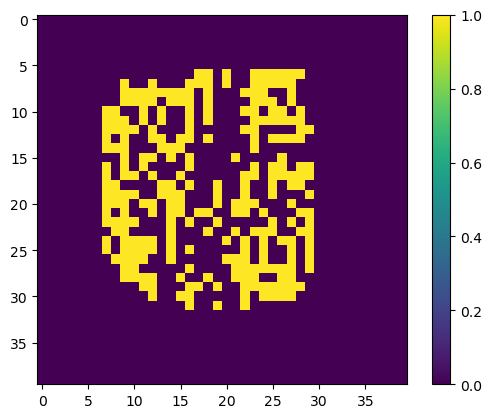

iteration 4-th of the algorithm 2 of optimization of the support
199 -th, precision :  0.04834959574405431 norm u:  2.176919106881959e+53
199 -th, precision :  0.032266751355922975 norm u:  6.2163964094713125e+50
199 -th, precision :  0.014239853000177964 norm u:  2.352957504141305e+54
199 -th, precision :  0.010570632478534582 norm u:  1.8401859241712122e+53
199 -th, precision :  0.03182668969273216 norm u:  9.074855293498443e+53
Kulback descent 0-th iteration, precision = 0.00013699779610171326
199 -th, precision :  0.04832461465041994 norm u:  1.7429049049217226e+53
199 -th, precision :  0.033030158144465284 norm u:  5.080008790826814e+50
199 -th, precision :  0.014606824596087897 norm u:  2.194219200070516e+54
199 -th, precision :  0.010510533931583228 norm u:  1.6556634579365136e+53
199 -th, precision :  0.03233096996633535 norm u:  7.534644756224875e+53
Kulback descent 1-th iteration, precision = 0.00027319281400962913
199 -th, precision :  0.048300564671987 norm u:  1.5601847147

199 -th, precision :  0.044143965674460495 norm u:  2.7987857480754393e+45
Kulback descent 18-th iteration, precision = 0.0019925252414921173
199 -th, precision :  0.02800797308205474 norm u:  7.95154943110156e+46
199 -th, precision :  0.03785452987500047 norm u:  8.355641562260209e+40
199 -th, precision :  0.020530977599407328 norm u:  1.1778634015256937e+46
199 -th, precision :  0.0076769384733503376 norm u:  1.658676911929895e+47
199 -th, precision :  0.04053828232693011 norm u:  2.0968656470963322e+44
Kulback descent 19-th iteration, precision = 0.0020378646027391705
199 -th, precision :  0.028427743629695947 norm u:  9.893392884309885e+45
199 -th, precision :  0.03811516075533447 norm u:  4.1976248916560895e+39
199 -th, precision :  0.01601415033453314 norm u:  1.2443909942341884e+45
199 -th, precision :  0.007295944546727036 norm u:  5.584075275847277e+46
199 -th, precision :  0.0371940360857575 norm u:  1.6433259134032955e+43
Kulback descent 20-th iteration, precision = 0.002077

199 -th, precision :  0.011393859415795633 norm u:  2.3423175237545588e+32
Kulback descent 37-th iteration, precision = 0.001973887725747816
199 -th, precision :  0.004346206476479336 norm u:  1.0566864358909355e+36
199 -th, precision :  0.002498502615746161 norm u:  3.181773572988342e+34
199 -th, precision :  0.02564681993925165 norm u:  2.101213721887788e+38
199 -th, precision :  0.00017276087139642037 norm u:  1.0262116497255569e+41
199 -th, precision :  0.008204113623386399 norm u:  2.800887795739169e+32
Kulback descent 38-th iteration, precision = 0.0019158439686647452
199 -th, precision :  0.0013735548749650383 norm u:  6.294538497324057e+35
199 -th, precision :  0.0026337152999437933 norm u:  5.060858813727897e+34
199 -th, precision :  0.025493025048434335 norm u:  2.3268973945065002e+38
199 -th, precision :  0.0009133732311193138 norm u:  1.0496928987404683e+41
199 -th, precision :  0.007300578520052549 norm u:  4.589877610620904e+32
Kulback descent 39-th iteration, precision =

199 -th, precision :  0.002815144604647197 norm u:  1.0326031742859604e+34
Kulback descent 56-th iteration, precision = 0.0010450870683325166
199 -th, precision :  0.06084557820555076 norm u:  1.392189484252432e+34
199 -th, precision :  0.003996228625741866 norm u:  2.166395394291111e+36
199 -th, precision :  0.019442880225059977 norm u:  1.6061466200298644e+39
199 -th, precision :  0.009228363631013717 norm u:  2.0706461306920127e+41
199 -th, precision :  0.0035013667173810653 norm u:  1.1239057896315873e+34
Kulback descent 57-th iteration, precision = 0.0010222982649858395
199 -th, precision :  0.06114912048468273 norm u:  1.486239406275829e+34
199 -th, precision :  0.004035312657913486 norm u:  2.1879703357483743e+36
199 -th, precision :  0.019422954055333005 norm u:  1.7488412650622808e+39
199 -th, precision :  0.009785365381884691 norm u:  2.1023259206537156e+41
199 -th, precision :  0.004230680931855945 norm u:  1.2090319713441315e+34
Kulback descent 58-th iteration, precision = 

199 -th, precision :  0.014105997721440517 norm u:  9.175003612528724e+33
Kulback descent 75-th iteration, precision = 0.0006728714754590285
199 -th, precision :  0.06202424460857436 norm u:  1.552870349436878e+34
199 -th, precision :  0.017470857722143254 norm u:  5.7411758546791814e+35
199 -th, precision :  0.006635729927503847 norm u:  7.947235767062228e+36
199 -th, precision :  0.014363177524136843 norm u:  1.8038669660262555e+41
199 -th, precision :  0.014392725866214333 norm u:  8.587612781783081e+33
Kulback descent 76-th iteration, precision = 0.0006576636036184003
199 -th, precision :  0.06185011109840013 norm u:  1.4412837305012954e+34
199 -th, precision :  0.01858718744351767 norm u:  5.262112123747243e+35
199 -th, precision :  0.00682601882183589 norm u:  5.490976778713737e+36
199 -th, precision :  0.014289095459931664 norm u:  1.7523259267192086e+41
199 -th, precision :  0.0146406843083723 norm u:  8.034436655314797e+33
Kulback descent 77-th iteration, precision = 0.0006430

199 -th, precision :  0.013125145097023061 norm u:  8.89646014268233e+40
199 -th, precision :  0.01710939747336045 norm u:  2.7406845357207096e+33
Kulback descent 94-th iteration, precision = 0.00044183191781390165
199 -th, precision :  0.06003293207196248 norm u:  4.3843978476667465e+33
199 -th, precision :  0.03144773924886919 norm u:  1.3548176659218156e+35
199 -th, precision :  0.00778722991912142 norm u:  1.119717572334182e+35
199 -th, precision :  0.013107681008682476 norm u:  8.519397529686006e+40
199 -th, precision :  0.01724358957967958 norm u:  2.5788977912324982e+33
Kulback descent 95-th iteration, precision = 0.0004310945874454411
199 -th, precision :  0.05995517174411437 norm u:  4.169534145215364e+33
199 -th, precision :  0.03162592091167267 norm u:  1.2597187448986549e+35
199 -th, precision :  0.007871032067807456 norm u:  9.721685397596985e+34
199 -th, precision :  0.013096241139871694 norm u:  8.158435899089689e+40
199 -th, precision :  0.017379818232018833 norm u:  2.

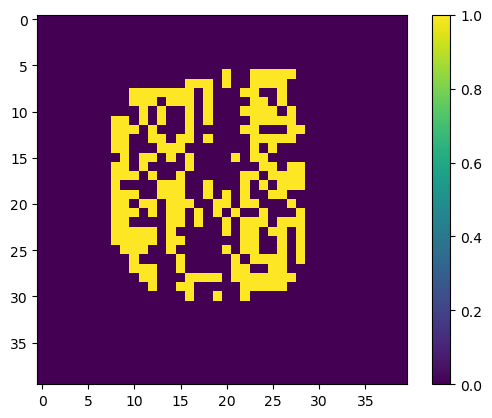

iteration 5-th of the algorithm 2 of optimization of the support
199 -th, precision :  0.049961479830697327 norm u:  1.9279744367960535e+48
199 -th, precision :  0.03077596735382941 norm u:  1.6212440468700495e+45
199 -th, precision :  0.015058229906220836 norm u:  3.6409194018636186e+49
199 -th, precision :  0.014942805834162977 norm u:  3.86775397094072e+48
199 -th, precision :  0.0340237518943007 norm u:  2.389388013237139e+48
Kulback descent 0-th iteration, precision = 0.00014563509039267777
199 -th, precision :  0.049841129873137574 norm u:  1.5439481226600985e+48
199 -th, precision :  0.031271657717696376 norm u:  1.3338041516784892e+45
199 -th, precision :  0.015651808231090292 norm u:  3.3777215751324977e+49
199 -th, precision :  0.01498164802233511 norm u:  3.423854452939803e+48
199 -th, precision :  0.03473362896639738 norm u:  1.973645216976085e+48
Kulback descent 1-th iteration, precision = 0.00029029766001614977
199 -th, precision :  0.04976770766314524 norm u:  1.38276710

Kulback descent 18-th iteration, precision = 0.0019120967211105368
199 -th, precision :  0.042525406101151006 norm u:  7.77066113685739e+45
199 -th, precision :  0.03473259948496546 norm u:  1.201748569320662e+34
199 -th, precision :  0.026766669599938033 norm u:  3.99765464653397e+40
199 -th, precision :  0.010165401896700533 norm u:  4.168944501569325e+41
199 -th, precision :  0.03891178511495868 norm u:  1.870984443698906e+38
Kulback descent 19-th iteration, precision = 0.001915481982081292
199 -th, precision :  0.05045032209584028 norm u:  6.197769918720023e+45
199 -th, precision :  0.012300406583282781 norm u:  5.704131281710503e+33
199 -th, precision :  0.021568015432081 norm u:  2.1721408356035635e+39
199 -th, precision :  0.00895371274228557 norm u:  1.0955615983913574e+41
199 -th, precision :  0.034919871268674636 norm u:  3.175148545736265e+37
Kulback descent 20-th iteration, precision = 0.001908463055116505
199 -th, precision :  0.05771861121004508 norm u:  3.821740176732577

Kulback descent 37-th iteration, precision = 0.0016161878398975344
199 -th, precision :  0.02600671069821121 norm u:  1.361234351887979e+36
199 -th, precision :  0.00951841483698217 norm u:  1.5682514013426437e+29
199 -th, precision :  0.027566886820746348 norm u:  1.1291652296701436e+33
199 -th, precision :  0.0022802004246915146 norm u:  6.203390833960635e+35
199 -th, precision :  0.013100103769255975 norm u:  3.261173712274907e+28
Kulback descent 38-th iteration, precision = 0.0015711593917850685
199 -th, precision :  0.025782853543283038 norm u:  7.814959512541821e+35
199 -th, precision :  0.010895266102499758 norm u:  2.3083490982862508e+29
199 -th, precision :  0.027121539582452076 norm u:  1.2716602548836893e+33
199 -th, precision :  0.0032868934556822154 norm u:  7.184553093623957e+35
199 -th, precision :  0.012206319905041455 norm u:  1.6297810663320768e+28
Kulback descent 39-th iteration, precision = 0.0015239357674204869
199 -th, precision :  0.02478834686900199 norm u:  5.0

Kulback descent 56-th iteration, precision = 0.0009075212853033583
199 -th, precision :  0.0510794387458189 norm u:  2.0232953591392008e+35
199 -th, precision :  0.011010508431821312 norm u:  6.747457714191535e+30
199 -th, precision :  0.026215952395193115 norm u:  2.095082231865463e+34
199 -th, precision :  0.012028300962889512 norm u:  4.367866757045096e+36
199 -th, precision :  0.006742978595790425 norm u:  1.3670925712717088e+28
Kulback descent 57-th iteration, precision = 0.0008884823955051579
199 -th, precision :  0.05387002710662572 norm u:  1.7966363429549196e+35
199 -th, precision :  0.010335305516945236 norm u:  6.975100636012211e+30
199 -th, precision :  0.026639502438498608 norm u:  2.411009828549824e+34
199 -th, precision :  0.012391082926121745 norm u:  4.564735456652977e+36
199 -th, precision :  0.007083382357439962 norm u:  1.3365218474782943e+28
Kulback descent 58-th iteration, precision = 0.0008702194456362767
199 -th, precision :  0.05621464790117382 norm u:  1.58567

Kulback descent 75-th iteration, precision = 0.0006346450378579094
199 -th, precision :  0.06776207836133381 norm u:  2.4759514654441258e+34
199 -th, precision :  0.015067708996960371 norm u:  3.259549134691189e+30
199 -th, precision :  0.006899576355503245 norm u:  6.556812799385717e+32
199 -th, precision :  0.013618526509971834 norm u:  3.977190254002155e+36
199 -th, precision :  0.013676818959477635 norm u:  5.669727055761098e+27
Kulback descent 76-th iteration, precision = 0.0006234984026828115
199 -th, precision :  0.06784855817536431 norm u:  2.2907655150764854e+34
199 -th, precision :  0.015707896413634636 norm u:  3.0535844482166313e+30
199 -th, precision :  0.006850191083843514 norm u:  4.516134457491653e+32
199 -th, precision :  0.013588818385302697 norm u:  3.803025722455218e+36
199 -th, precision :  0.014002851119228325 norm u:  5.536669245733354e+27
Kulback descent 77-th iteration, precision = 0.0006124282495159681
199 -th, precision :  0.06790507040508402 norm u:  2.12525

Kulback descent 94-th iteration, precision = 0.00042349628649311627
199 -th, precision :  0.06730685145025073 norm u:  7.229403467828232e+33
199 -th, precision :  0.029740172583495265 norm u:  7.248580710588647e+29
199 -th, precision :  0.012728621031802893 norm u:  1.667739079022834e+30
199 -th, precision :  0.013459442201402435 norm u:  1.362055532948995e+36
199 -th, precision :  0.020125804496397903 norm u:  3.4645539030010186e+27
Kulback descent 95-th iteration, precision = 0.00041340210205287255
199 -th, precision :  0.06722873875742783 norm u:  6.874648518679237e+33
199 -th, precision :  0.03012652415390965 norm u:  6.700620677734904e+29
199 -th, precision :  0.012941152542291027 norm u:  1.3654714784719648e+30
199 -th, precision :  0.013476115107225699 norm u:  1.2893310672523833e+36
199 -th, precision :  0.020354636903324622 norm u:  3.340329068809507e+27
Kulback descent 96-th iteration, precision = 0.0004036206980119557
199 -th, precision :  0.06714654639713848 norm u:  6.5443

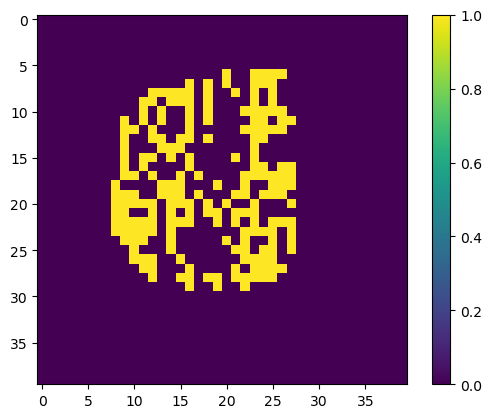

iteration 6-th of the algorithm 2 of optimization of the support
199 -th, precision :  0.00620598184393309 norm u:  7.032744672354228e+47
199 -th, precision :  0.03149224690720636 norm u:  7.36554650190073e+41
199 -th, precision :  0.02001302970340654 norm u:  5.3204012582924115e+45
199 -th, precision :  0.008474443153937335 norm u:  5.421854795621607e+44
199 -th, precision :  0.02776988626729138 norm u:  4.882864156427323e+45
Kulback descent 0-th iteration, precision = 0.00016208130219237007
199 -th, precision :  0.005171903517323237 norm u:  8.021794287590019e+47
199 -th, precision :  0.031549161806027945 norm u:  6.1955107323746015e+41
199 -th, precision :  0.0204745204039699 norm u:  5.114197673546022e+45
199 -th, precision :  0.008579101990524472 norm u:  5.222440420162733e+44
199 -th, precision :  0.028566716156149058 norm u:  4.189861046286138e+45
Kulback descent 1-th iteration, precision = 0.00032333756649904877
199 -th, precision :  0.004736126699109335 norm u:  8.563603005220

Kulback descent 18-th iteration, precision = 0.002005238221692938
199 -th, precision :  0.05215049471159365 norm u:  2.6809164150586967e+45
199 -th, precision :  0.007317795267245997 norm u:  2.3519243299255604e+33
199 -th, precision :  0.039298491531140095 norm u:  7.90901142334059e+38
199 -th, precision :  0.0118856829993606 norm u:  1.0327440219670723e+39
199 -th, precision :  0.04649421288240934 norm u:  1.1383950555523845e+38
Kulback descent 19-th iteration, precision = 0.001971854129822878
199 -th, precision :  0.0566581366422111 norm u:  9.74030568835307e+43
199 -th, precision :  0.006699306098604545 norm u:  3.7280527335188396e+32
199 -th, precision :  0.03294061456061531 norm u:  3.50692821046485e+37
199 -th, precision :  0.011198566712056176 norm u:  2.9769712809251147e+38
199 -th, precision :  0.04260959747555197 norm u:  1.9034738841688482e+37
Kulback descent 20-th iteration, precision = 0.0019240723826899938
199 -th, precision :  0.059232391760064715 norm u:  2.76164490591

199 -th, precision :  0.01904206038400422 norm u:  1.6112054612052487e+27
199 -th, precision :  0.019021081935447527 norm u:  7.510912129105157e+29
199 -th, precision :  0.0021095708566543684 norm u:  3.701452712943618e+33
199 -th, precision :  0.019331132683921295 norm u:  5.462485507086224e+26
Kulback descent 38-th iteration, precision = 0.0013849436336577754
199 -th, precision :  0.01334808129055483 norm u:  6.5103412412044794e+35
199 -th, precision :  0.019632820061246264 norm u:  2.1058216424285316e+27
199 -th, precision :  0.01861045662342386 norm u:  7.606369651477968e+29
199 -th, precision :  0.0026090715508223744 norm u:  5.188078067005779e+33
199 -th, precision :  0.019031062601541738 norm u:  3.2519189899606854e+26
Kulback descent 39-th iteration, precision = 0.0013501435057736682
199 -th, precision :  0.009198572608104178 norm u:  5.234519766016011e+35
199 -th, precision :  0.019650758109048507 norm u:  2.673709494004814e+27
199 -th, precision :  0.018149878561631454 norm u

199 -th, precision :  0.02132205060820847 norm u:  6.670711422513419e+30
199 -th, precision :  0.011427915910071296 norm u:  2.4248336344375474e+35
199 -th, precision :  0.005435951394418686 norm u:  4.62508878413975e+25
Kulback descent 57-th iteration, precision = 0.0008890845677172529
199 -th, precision :  0.057824129859022085 norm u:  1.2543643050891801e+35
199 -th, precision :  0.01377939717362785 norm u:  1.217547746759612e+28
199 -th, precision :  0.02141109206721301 norm u:  7.353946740345652e+30
199 -th, precision :  0.011745706618541749 norm u:  2.5143416437470653e+35
199 -th, precision :  0.006124652002585638 norm u:  4.453039068099211e+25
Kulback descent 58-th iteration, precision = 0.0008730561116543334
199 -th, precision :  0.05822617830012485 norm u:  1.201582411970214e+35
199 -th, precision :  0.0130472929335033 norm u:  1.1744547249086006e+28
199 -th, precision :  0.021547908057611687 norm u:  7.915144160567949e+30
199 -th, precision :  0.012022348559139064 norm u:  2.5

199 -th, precision :  0.024365181173769946 norm u:  8.479772147233307e+30
199 -th, precision :  0.014250851576756785 norm u:  5.722873327770883e+34
199 -th, precision :  0.016570566191325506 norm u:  1.8955227684146113e+25
Kulback descent 76-th iteration, precision = 0.0006185730509575501
199 -th, precision :  0.05540250415427361 norm u:  3.6519435632948264e+34
199 -th, precision :  0.01278863961302061 norm u:  4.837859473160365e+27
199 -th, precision :  0.022656791985235455 norm u:  7.694661301791814e+30
199 -th, precision :  0.014177088518305275 norm u:  5.280714008666673e+34
199 -th, precision :  0.01691039447257925 norm u:  1.8306439737189284e+25
Kulback descent 77-th iteration, precision = 0.0006047247575356419
199 -th, precision :  0.05547259145999498 norm u:  3.33167181358904e+34
199 -th, precision :  0.01375629348501097 norm u:  4.654983319226667e+27
199 -th, precision :  0.02053821682134798 norm u:  6.762108442890964e+30
199 -th, precision :  0.014095328188806579 norm u:  4.88

199 -th, precision :  0.007420357231493149 norm u:  1.9286722440862422e+29
199 -th, precision :  0.012695968979796088 norm u:  1.3366286538659262e+34
199 -th, precision :  0.021150300656443417 norm u:  1.0212185572191065e+25
Kulback descent 95-th iteration, precision = 0.00041616801235497107
199 -th, precision :  0.062249584711279816 norm u:  6.196990610626223e+33
199 -th, precision :  0.027335600683997298 norm u:  1.7548144016241568e+27
199 -th, precision :  0.007444693626828726 norm u:  1.6562411167285126e+29
199 -th, precision :  0.012631607234274249 norm u:  1.2360609690283402e+34
199 -th, precision :  0.021287305267342838 norm u:  9.8577834719235e+24
Kulback descent 96-th iteration, precision = 0.0004089078617375562
199 -th, precision :  0.0625868146764556 norm u:  5.742851095715859e+33
199 -th, precision :  0.02760068926449235 norm u:  1.6600654260216213e+27
199 -th, precision :  0.007471701220800196 norm u:  1.4328316633426013e+29
199 -th, precision :  0.012567178813702845 norm 

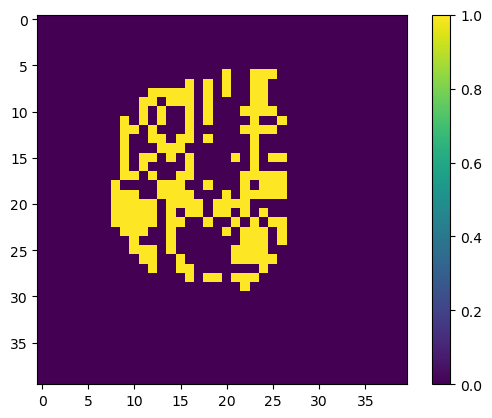

iteration 7-th of the algorithm 2 of optimization of the support
199 -th, precision :  0.02677443976456973 norm u:  4.657775018641813e+49
199 -th, precision :  0.015983166521985455 norm u:  1.1103342004683462e+45
199 -th, precision :  0.007787140831248099 norm u:  1.597569483553394e+48
199 -th, precision :  0.007169428129116214 norm u:  1.3035286963362343e+46
199 -th, precision :  0.012410203191677674 norm u:  8.386223369862402e+47
Kulback descent 0-th iteration, precision = 0.0001818365091651025
199 -th, precision :  0.02837450808851848 norm u:  4.21278470195683e+49
199 -th, precision :  0.01668547281839755 norm u:  1.029146983304994e+45
199 -th, precision :  0.008348870900593604 norm u:  1.6402050314891682e+48
199 -th, precision :  0.007249309708475791 norm u:  1.2665751515408115e+46
199 -th, precision :  0.013041713904393156 norm u:  7.848023325756145e+47
Kulback descent 1-th iteration, precision = 0.00036319403034422123
199 -th, precision :  0.029178826492911796 norm u:  3.99144587

199 -th, precision :  0.05680751407061613 norm u:  5.719529016920016e+33
199 -th, precision :  0.04139003950726788 norm u:  4.103462872025851e+41
199 -th, precision :  0.01634270778558406 norm u:  3.754171838010047e+40
199 -th, precision :  0.057005360745980005 norm u:  1.4779097705990663e+38
Kulback descent 19-th iteration, precision = 0.0022087971015297375
199 -th, precision :  0.04930413565097899 norm u:  7.317401403150999e+43
199 -th, precision :  0.044728879746308195 norm u:  9.519154194461437e+31
199 -th, precision :  0.0338546874659457 norm u:  1.9213961928660999e+40
199 -th, precision :  0.014456208052116058 norm u:  6.614437281842444e+39
199 -th, precision :  0.051703944432087444 norm u:  2.170763081429626e+37
Kulback descent 20-th iteration, precision = 0.002114528315514868
199 -th, precision :  0.05168573957664057 norm u:  1.0704304701245307e+43
199 -th, precision :  0.03178161242318129 norm u:  3.402024440977091e+30
199 -th, precision :  0.025854812990484963 norm u:  1.0297

199 -th, precision :  0.014486660159993558 norm u:  1.91854130883272e+35
199 -th, precision :  0.017339229435903478 norm u:  8.151611196112371e+24
199 -th, precision :  0.021934052013550892 norm u:  1.9765835083591617e+30
199 -th, precision :  0.000887852004866416 norm u:  3.959320074998272e+33
199 -th, precision :  0.01828467242026387 norm u:  1.9135392022842598e+25
Kulback descent 38-th iteration, precision = 0.0012527495746378827
199 -th, precision :  0.013380735657404694 norm u:  1.4804324423368983e+35
199 -th, precision :  0.017862049273417623 norm u:  8.436508203469892e+24
199 -th, precision :  0.022356242615060737 norm u:  1.6300499369496208e+30
199 -th, precision :  0.0012017953488474753 norm u:  4.8660481335226254e+33
199 -th, precision :  0.017968735081080912 norm u:  1.31485025432776e+25
Kulback descent 39-th iteration, precision = 0.0012372170021759303
199 -th, precision :  0.013009394399972686 norm u:  1.2029519241098725e+35
199 -th, precision :  0.01829754208242903 norm u

199 -th, precision :  0.026857651479679515 norm u:  8.688314916275129e+30
199 -th, precision :  0.007550767537982489 norm u:  3.182487835173613e+35
199 -th, precision :  0.014735725110042418 norm u:  5.4029406406666044e+22
Kulback descent 57-th iteration, precision = 0.0009067893566090965
199 -th, precision :  0.05158202721431364 norm u:  4.442783031880961e+34
199 -th, precision :  0.016279516278962913 norm u:  1.760116797460735e+25
199 -th, precision :  0.027783050789032676 norm u:  9.129002351444267e+30
199 -th, precision :  0.007533300324190656 norm u:  3.320611781786993e+35
199 -th, precision :  0.013858137667058288 norm u:  4.350129912117553e+22
Kulback descent 58-th iteration, precision = 0.0008888250716279853
199 -th, precision :  0.05324866792051103 norm u:  4.224717705253529e+34
199 -th, precision :  0.016719930575079988 norm u:  1.6226053117790974e+25
199 -th, precision :  0.028555420396171125 norm u:  9.363522341305281e+30
199 -th, precision :  0.007532321715067285 norm u:  

199 -th, precision :  0.02510747486077581 norm u:  7.404665812415364e+30
199 -th, precision :  0.00794342651653981 norm u:  1.1244513381847705e+35
199 -th, precision :  0.012308340085027871 norm u:  7.209878683429113e+22
Kulback descent 76-th iteration, precision = 0.0005918225715523749
199 -th, precision :  0.06707530067210385 norm u:  1.265498923256743e+34
199 -th, precision :  0.02836909985726112 norm u:  5.098840693438282e+24
199 -th, precision :  0.02339507321926796 norm u:  5.823816410959749e+30
199 -th, precision :  0.007731253946527349 norm u:  1.0397509724024634e+35
199 -th, precision :  0.012626645548843645 norm u:  7.69366001170665e+22
Kulback descent 77-th iteration, precision = 0.0005780226730051143
199 -th, precision :  0.06744933595632975 norm u:  1.1783797700884422e+34
199 -th, precision :  0.02887581613293368 norm u:  5.02005371121398e+24
199 -th, precision :  0.022203828074841232 norm u:  4.3546289985246606e+30
199 -th, precision :  0.007571107419057286 norm u:  9.647

199 -th, precision :  0.024078521433928426 norm u:  4.912262902766444e+28
199 -th, precision :  0.0071569866875030586 norm u:  2.932688258654619e+34
199 -th, precision :  0.015437169444357328 norm u:  1.5526709613650365e+23
Kulback descent 95-th iteration, precision = 0.0003991663106512006
199 -th, precision :  0.0726127508118273 norm u:  4.0386429808735786e+33
199 -th, precision :  0.02914122582880491 norm u:  7.603639233349174e+24
199 -th, precision :  0.024299121433281574 norm u:  4.135033874075212e+28
199 -th, precision :  0.007172558475854783 norm u:  2.73437289982491e+34
199 -th, precision :  0.01546666886809297 norm u:  1.5584863146358167e+23
Kulback descent 96-th iteration, precision = 0.0003927449268732332
199 -th, precision :  0.07281784885757896 norm u:  3.8307574534396855e+33
199 -th, precision :  0.029063382630305473 norm u:  7.726244387956773e+24
199 -th, precision :  0.024517032216504392 norm u:  3.510046167552134e+28
199 -th, precision :  0.007191235508257398 norm u:  2

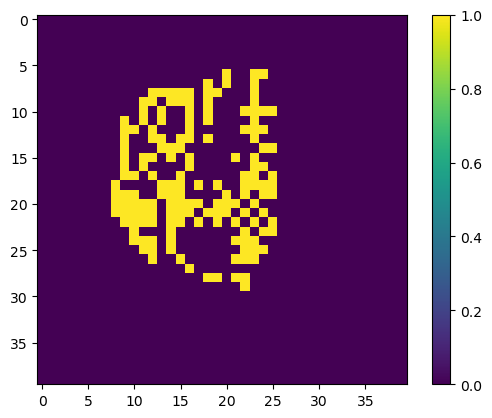

iteration 8-th of the algorithm 2 of optimization of the support
199 -th, precision :  0.0023790811056274347 norm u:  9.271541661197211e+49
199 -th, precision :  0.005565330329289172 norm u:  2.046463895376919e+46
199 -th, precision :  0.0036096476796805637 norm u:  1.783075465176936e+48
199 -th, precision :  0.002806574751017864 norm u:  2.475795991581351e+47
199 -th, precision :  8.650508640389737e-05 norm u:  1.3061971689517974e+49
Kulback descent 0-th iteration, precision = 0.00019943570040119375
199 -th, precision :  0.0021118642193090407 norm u:  1.0270744012875845e+50
199 -th, precision :  0.005758888317359047 norm u:  2.0622362758490112e+46
199 -th, precision :  0.003653860601264974 norm u:  1.845748329745558e+48
199 -th, precision :  0.003152888910373374 norm u:  2.405155296318536e+47
199 -th, precision :  7.82454193719966e-05 norm u:  1.365667263380649e+49
Kulback descent 1-th iteration, precision = 0.00039881314786344526
199 -th, precision :  0.001961635677005043 norm u:  1.

199 -th, precision :  0.09011194291658074 norm u:  5.694345767670206e+42
199 -th, precision :  0.07558760706319365 norm u:  8.75832648185109e+35
199 -th, precision :  0.05147098315010412 norm u:  4.712402315861451e+45
199 -th, precision :  0.022673751114626217 norm u:  1.1903261745980215e+43
199 -th, precision :  0.07853357647111084 norm u:  8.266883035993201e+40
Kulback descent 19-th iteration, precision = 0.00291599353083671
199 -th, precision :  0.03764831027737991 norm u:  2.0410765122428544e+41
199 -th, precision :  0.04975343325963607 norm u:  7.297060401310296e+34
199 -th, precision :  0.06097272989891788 norm u:  1.1396925769621851e+44
199 -th, precision :  0.017882876585295773 norm u:  1.3660683499941575e+42
199 -th, precision :  0.07357987801721755 norm u:  1.9575333915178752e+39
Kulback descent 20-th iteration, precision = 0.0027814712852098308
199 -th, precision :  0.039940437476909424 norm u:  5.868817525386716e+40
199 -th, precision :  0.04874380825822785 norm u:  9.82984

199 -th, precision :  0.0038757463937313767 norm u:  5.864120104758854e+22
199 -th, precision :  0.01938599975940113 norm u:  1.782900319258385e+31
199 -th, precision :  0.0075335480045853566 norm u:  6.593511723331677e+33
199 -th, precision :  0.02255167843676742 norm u:  2.1476754517585656e+24
Kulback descent 38-th iteration, precision = 0.0011611664029769794
199 -th, precision :  0.053341449135987005 norm u:  2.6742811945512786e+33
199 -th, precision :  0.004822308506953379 norm u:  6.7198631971137245e+22
199 -th, precision :  0.02046004350183131 norm u:  1.1746852872562334e+31
199 -th, precision :  0.007861227770019838 norm u:  7.883513469524021e+33
199 -th, precision :  0.02150262824052452 norm u:  1.3734397928217993e+24
Kulback descent 39-th iteration, precision = 0.0011557259191125686
199 -th, precision :  0.05143513132770073 norm u:  2.6263981912157484e+33
199 -th, precision :  0.005224388390675272 norm u:  8.053662042815316e+22
199 -th, precision :  0.021261809243503998 norm u

199 -th, precision :  0.027136076053890887 norm u:  2.248186258470327e+31
199 -th, precision :  0.01088691362550901 norm u:  1.7515827692471998e+35
199 -th, precision :  0.012906496041909864 norm u:  6.966737505157267e+21
Kulback descent 57-th iteration, precision = 0.0009074614150896197
199 -th, precision :  0.06761125748047107 norm u:  4.5919240924375563e+33
199 -th, precision :  0.010353848140390942 norm u:  2.4035705123153557e+24
199 -th, precision :  0.027165270339203993 norm u:  2.4875657882696324e+31
199 -th, precision :  0.011057459338234018 norm u:  2.0191048103387766e+35
199 -th, precision :  0.012745679839145659 norm u:  5.682620938284995e+21
Kulback descent 58-th iteration, precision = 0.0008903821030985911
199 -th, precision :  0.06879569351311897 norm u:  4.332073918994943e+33
199 -th, precision :  0.011147747586475368 norm u:  2.605096780090736e+24
199 -th, precision :  0.027181929031222938 norm u:  2.6813842311871026e+31
199 -th, precision :  0.01125147904942052 norm u:

199 -th, precision :  0.008806739836482688 norm u:  1.778198692849551e+35
199 -th, precision :  0.00934242176583609 norm u:  6.938743592062566e+21
Kulback descent 76-th iteration, precision = 0.0006132407904802198
199 -th, precision :  0.0763601287962746 norm u:  1.426417216147636e+33
199 -th, precision :  0.0202515539018643 norm u:  2.7695703180451996e+24
199 -th, precision :  0.02067698591241506 norm u:  1.0004521579941329e+31
199 -th, precision :  0.00870096593024906 norm u:  1.568156665535616e+35
199 -th, precision :  0.009687427103039988 norm u:  7.137756526311287e+21
Kulback descent 77-th iteration, precision = 0.0006008125248865836
199 -th, precision :  0.07648255283785431 norm u:  1.3390935319014037e+33
199 -th, precision :  0.020292319086589707 norm u:  2.7858426413372127e+24
199 -th, precision :  0.020106637431192807 norm u:  7.058214121743365e+30
199 -th, precision :  0.008615729070106732 norm u:  1.3850082657864787e+35
199 -th, precision :  0.010035851505171786 norm u:  7.3

199 -th, precision :  0.015647144547070724 norm u:  1.2126285770732448e+22
Kulback descent 95-th iteration, precision = 0.0004224692953225793
199 -th, precision :  0.07700252872642868 norm u:  5.8133746431023636e+32
199 -th, precision :  0.014483714876742984 norm u:  3.2326583933083863e+24
199 -th, precision :  0.021796511775888216 norm u:  5.316842188107649e+28
199 -th, precision :  0.0079666122150311 norm u:  2.0253781903867244e+34
199 -th, precision :  0.015906317952968305 norm u:  1.2324012457309845e+22
Kulback descent 96-th iteration, precision = 0.00041504057443975963
199 -th, precision :  0.07697615309968328 norm u:  5.631298017394398e+32
199 -th, precision :  0.014144379488930992 norm u:  3.176636148735483e+24
199 -th, precision :  0.021872160412375757 norm u:  4.509579180103587e+28
199 -th, precision :  0.007964219478200113 norm u:  1.839946668910581e+34
199 -th, precision :  0.016156776094847357 norm u:  1.2506475320802992e+22
Kulback descent 97-th iteration, precision = 0.00

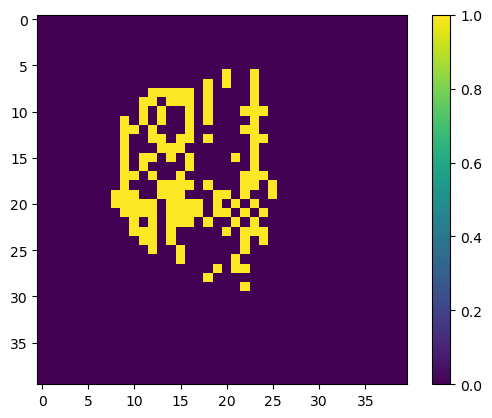

iteration 9-th of the algorithm 2 of optimization of the support
199 -th, precision :  0.004589136450395277 norm u:  4.1660907465735954e+48
199 -th, precision :  0.00418797580057194 norm u:  1.1112142011529335e+46
199 -th, precision :  0.0007376656142077734 norm u:  1.6147296743209942e+48
199 -th, precision :  0.0010377373228809942 norm u:  1.4716928317763e+48
199 -th, precision :  3.542236944461451e-05 norm u:  5.2401491137255445e+48
Kulback descent 0-th iteration, precision = 0.00020760206156924057
199 -th, precision :  0.004679791147503796 norm u:  4.719715490264861e+48
199 -th, precision :  0.004184339306224335 norm u:  1.155391484381517e+46
199 -th, precision :  0.0007648330461208125 norm u:  1.7124675065538693e+48
199 -th, precision :  0.0010663785321827531 norm u:  1.5223414149265678e+48
199 -th, precision :  2.6631126684381623e-05 norm u:  5.698460269785837e+48
Kulback descent 1-th iteration, precision = 0.00041539667920236536
199 -th, precision :  0.00472523962628824 norm u:  

199 -th, precision :  0.018829726670528315 norm u:  1.4159943108916875e+46
199 -th, precision :  0.058514980602233944 norm u:  3.3523766643279786e+46
Kulback descent 18-th iteration, precision = 0.0037194338641505956
199 -th, precision :  0.07037886023140577 norm u:  4.2886597226823214e+45
199 -th, precision :  0.06889413222314822 norm u:  1.783633013638812e+40
199 -th, precision :  0.003495321286296271 norm u:  1.260709342790108e+49
199 -th, precision :  0.022433767204607633 norm u:  3.747869990467621e+45
199 -th, precision :  0.07699322524292225 norm u:  1.395201372167273e+45
Kulback descent 19-th iteration, precision = 0.003760752288623056
199 -th, precision :  0.09053299485255611 norm u:  6.146981502790864e+43
199 -th, precision :  0.06623738314277959 norm u:  2.6825680591748085e+38
199 -th, precision :  0.05559801991827889 norm u:  3.361382864998692e+48
199 -th, precision :  0.0232547845584923 norm u:  6.495022612864162e+44
199 -th, precision :  0.08827836410319846 norm u:  2.0762

199 -th, precision :  0.020472040708298916 norm u:  3.463601187032355e+24
Kulback descent 37-th iteration, precision = 0.0011546665860916708
199 -th, precision :  0.06289313372339085 norm u:  1.3878127918305598e+32
199 -th, precision :  0.013115861657689942 norm u:  7.998778865723913e+20
199 -th, precision :  0.013528630468815835 norm u:  2.290007015667164e+32
199 -th, precision :  0.004193678637131443 norm u:  1.9354847498114633e+34
199 -th, precision :  0.0195428326914995 norm u:  2.578073560232971e+24
Kulback descent 38-th iteration, precision = 0.001153211713893571
199 -th, precision :  0.06000443931676258 norm u:  1.6232666929775477e+32
199 -th, precision :  0.014917467403859309 norm u:  6.810521976569576e+20
199 -th, precision :  0.013815847251759264 norm u:  1.7224591902861904e+32
199 -th, precision :  0.00444428042344116 norm u:  1.8157023945864948e+34
199 -th, precision :  0.018558119891056386 norm u:  1.9642993503341305e+24
Kulback descent 39-th iteration, precision = 0.00115

199 -th, precision :  0.06676640249545894 norm u:  3.2406876056154225e+32
199 -th, precision :  0.026889184922491288 norm u:  9.532469917226862e+21
199 -th, precision :  0.023259582129074394 norm u:  3.214500492155503e+32
199 -th, precision :  0.006506872704908566 norm u:  1.697311550667512e+34
199 -th, precision :  0.010660753221836098 norm u:  8.948420856946329e+22
Kulback descent 57-th iteration, precision = 0.0009782079140547002
199 -th, precision :  0.06848358115867996 norm u:  3.0203483090155254e+32
199 -th, precision :  0.02759936066739625 norm u:  1.0530101027225821e+22
199 -th, precision :  0.02408748642801566 norm u:  3.2026805079614567e+32
199 -th, precision :  0.0065475335042726275 norm u:  1.4873982353327356e+34
199 -th, precision :  0.010449515162604043 norm u:  7.876235695378219e+22
Kulback descent 58-th iteration, precision = 0.0009600820227835622
199 -th, precision :  0.06995087284529104 norm u:  2.783623982809927e+32
199 -th, precision :  0.02818502952478341 norm u:  

199 -th, precision :  0.03322893691284021 norm u:  1.1173229482627817e+22
199 -th, precision :  0.022378622487517527 norm u:  8.118568547201707e+30
199 -th, precision :  0.007712877181825407 norm u:  8.362722079934539e+32
199 -th, precision :  0.016786149987385337 norm u:  5.124106344182347e+21
Kulback descent 76-th iteration, precision = 0.000640756261092183
199 -th, precision :  0.07553616234100272 norm u:  3.4989488831942313e+31
199 -th, precision :  0.03351284348926752 norm u:  1.0907617131210417e+22
199 -th, precision :  0.022703304902798278 norm u:  5.189217968338913e+30
199 -th, precision :  0.00774208932660498 norm u:  7.151210786927897e+32
199 -th, precision :  0.01721388966245269 norm u:  4.1799293274769405e+21
Kulback descent 77-th iteration, precision = 0.0006267932824456966
199 -th, precision :  0.07557811946461294 norm u:  3.204927226809523e+31
199 -th, precision :  0.03382957849079901 norm u:  1.065577819318926e+22
199 -th, precision :  0.023162563518298998 norm u:  3.35

199 -th, precision :  0.0295667554617379 norm u:  2.0856340707324927e+28
199 -th, precision :  0.008455843420536636 norm u:  7.941521813224269e+31
199 -th, precision :  0.01989374634668184 norm u:  1.5720505335144464e+20
Kulback descent 95-th iteration, precision = 0.0003951930203834236
199 -th, precision :  0.07637105972862551 norm u:  1.1510651214224315e+31
199 -th, precision :  0.03936437615746222 norm u:  8.371218641515092e+21
199 -th, precision :  0.029582374913068542 norm u:  1.7370190332858007e+28
199 -th, precision :  0.008574690571066135 norm u:  7.319664224256867e+31
199 -th, precision :  0.019892675467142466 norm u:  1.3989427019245219e+20
Kulback descent 96-th iteration, precision = 0.0003864765004386353
199 -th, precision :  0.07640920628812597 norm u:  1.1067110484135542e+31
199 -th, precision :  0.0392894724488691 norm u:  8.283216375139855e+21
199 -th, precision :  0.029593666477285896 norm u:  1.4585620502015134e+28
199 -th, precision :  0.008684139509500467 norm u:  6

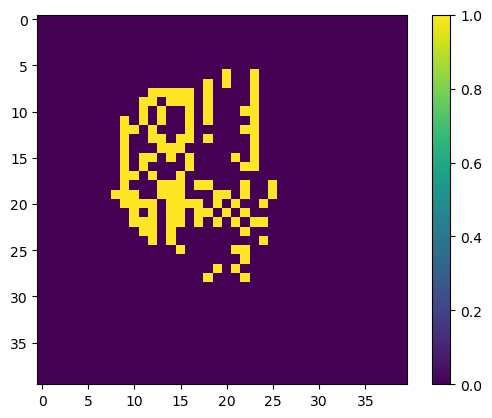

iteration 10-th of the algorithm 2 of optimization of the support
199 -th, precision :  0.003432062051492488 norm u:  5.076863409924228e+47
199 -th, precision :  0.003868138106139342 norm u:  2.8141936655994734e+45
199 -th, precision :  0.0005092784247563883 norm u:  1.0611939806066084e+48
199 -th, precision :  0.0002492248116572692 norm u:  1.2247559517044657e+48
199 -th, precision :  0.0004877783058317235 norm u:  9.483289177498982e+47
Kulback descent 0-th iteration, precision = 0.0002203656008586731
199 -th, precision :  0.0035588497520543175 norm u:  5.704811180967963e+47
199 -th, precision :  0.003990453169067286 norm u:  2.963283254964995e+45
199 -th, precision :  0.0005395685156561421 norm u:  1.1343760215489915e+48
199 -th, precision :  0.0002579387660711202 norm u:  1.2956098096751183e+48
199 -th, precision :  0.0005055380867382866 norm u:  1.040479892161443e+48
Kulback descent 1-th iteration, precision = 0.00044110490866866434
199 -th, precision :  0.0036222261533308073 norm 

199 -th, precision :  0.02007595263155363 norm u:  6.886327978937375e+47
199 -th, precision :  0.03701365145379039 norm u:  3.630227598766894e+48
Kulback descent 18-th iteration, precision = 0.004281942646744071
199 -th, precision :  0.045670871514630146 norm u:  1.943387991663271e+47
199 -th, precision :  0.06360613442540164 norm u:  9.700403360314212e+42
199 -th, precision :  0.003465656563633872 norm u:  8.255919063807869e+48
199 -th, precision :  0.030962549898273482 norm u:  1.846655726679391e+47
199 -th, precision :  0.05361923831546526 norm u:  4.215031197154366e+47
Kulback descent 19-th iteration, precision = 0.004390748087622884
199 -th, precision :  0.05590119685202658 norm u:  1.487798556367341e+46
199 -th, precision :  0.06457732410569773 norm u:  1.8819749939642008e+41
199 -th, precision :  0.0016176683071976528 norm u:  7.573428614227566e+48
199 -th, precision :  0.03603679637286729 norm u:  2.470713912505158e+46
199 -th, precision :  0.06930001289181487 norm u:  2.227948

199 -th, precision :  0.013598879990677434 norm u:  6.291833527143452e+24
Kulback descent 37-th iteration, precision = 0.0013109010105509169
199 -th, precision :  0.05980331061782301 norm u:  1.7664001424697744e+30
199 -th, precision :  0.011524268448534356 norm u:  2.984410137066772e+18
199 -th, precision :  0.01731021746905782 norm u:  1.8016471385760813e+33
199 -th, precision :  0.006829653954640833 norm u:  1.0518929165612167e+35
199 -th, precision :  0.013237848237418214 norm u:  6.915556977781877e+24
Kulback descent 38-th iteration, precision = 0.0012845243466784017
199 -th, precision :  0.06288123088883461 norm u:  2.927900365609907e+30
199 -th, precision :  0.016263783111332256 norm u:  1.7099316939292483e+18
199 -th, precision :  0.01811254220954431 norm u:  1.1405848246151704e+33
199 -th, precision :  0.0068237976727765 norm u:  8.571732989182803e+34
199 -th, precision :  0.012962451373262815 norm u:  7.29843920157149e+24
Kulback descent 39-th iteration, precision = 0.0012666

199 -th, precision :  0.08099429365350973 norm u:  1.726429081079302e+31
199 -th, precision :  0.01917200266415891 norm u:  5.333543329197522e+18
199 -th, precision :  0.024445930158538534 norm u:  7.577815751204184e+32
199 -th, precision :  0.007318810917610173 norm u:  2.6473507211376865e+34
199 -th, precision :  0.010335768680502469 norm u:  1.221723552865592e+23
Kulback descent 57-th iteration, precision = 0.0010681131010885428
199 -th, precision :  0.08238158827676333 norm u:  1.6111358827095076e+31
199 -th, precision :  0.018817299120475996 norm u:  5.855278447279943e+18
199 -th, precision :  0.025003630792822706 norm u:  7.434992260271725e+32
199 -th, precision :  0.007644702408463319 norm u:  2.3733589250839886e+34
199 -th, precision :  0.010341260372912428 norm u:  1.0256132389222393e+23
Kulback descent 58-th iteration, precision = 0.0010557455519490243
199 -th, precision :  0.08360492022035396 norm u:  1.4887474742422528e+31
199 -th, precision :  0.018446067764238284 norm u: 

199 -th, precision :  0.014028838702298544 norm u:  1.15594190674094e+19
199 -th, precision :  0.018355910324376105 norm u:  6.903896663342398e+31
199 -th, precision :  0.011307411792825689 norm u:  1.9148716416681242e+33
199 -th, precision :  0.010778605532324499 norm u:  8.569813335904697e+21
Kulback descent 76-th iteration, precision = 0.0007983185524968569
199 -th, precision :  0.08802853749977929 norm u:  2.2874056094711066e+30
199 -th, precision :  0.013939383649935752 norm u:  1.2048787175454958e+19
199 -th, precision :  0.017195086111579865 norm u:  4.791785453746137e+31
199 -th, precision :  0.011354599856275864 norm u:  1.6547609452045686e+33
199 -th, precision :  0.010941949316161414 norm u:  7.460629957260477e+21
Kulback descent 77-th iteration, precision = 0.0007860139349337078
199 -th, precision :  0.08795011676775431 norm u:  2.0656082222086893e+30
199 -th, precision :  0.013864499205500555 norm u:  1.2567608950366126e+19
199 -th, precision :  0.01631396669206725 norm u:

199 -th, precision :  0.01783572809428352 norm u:  2.2519745789309167e+29
199 -th, precision :  0.011978161670890549 norm u:  1.5368723987972634e+32
199 -th, precision :  0.021848324789587 norm u:  2.4512089368307053e+20
Kulback descent 95-th iteration, precision = 0.0005675385061910333
199 -th, precision :  0.08733611631462447 norm u:  5.793544073616585e+29
199 -th, precision :  0.013481841654139605 norm u:  1.9354188665327088e+19
199 -th, precision :  0.018198624476339714 norm u:  1.830284238113787e+29
199 -th, precision :  0.01200463314824849 norm u:  1.3751545486468412e+32
199 -th, precision :  0.022235733138804996 norm u:  1.9910892892355894e+20
Kulback descent 96-th iteration, precision = 0.0005563581109456967
199 -th, precision :  0.0873292548457436 norm u:  5.54867642720194e+29
199 -th, precision :  0.01358621652064648 norm u:  1.9436844318963253e+19
199 -th, precision :  0.01854756161644345 norm u:  1.499488153967609e+29
199 -th, precision :  0.0120328209335779 norm u:  1.2345

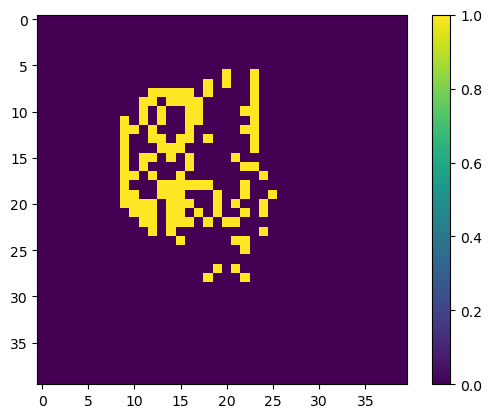

iteration 11-th of the algorithm 2 of optimization of the support
199 -th, precision :  0.002685828844647856 norm u:  1.1727611342929173e+47
199 -th, precision :  0.0014956209862250183 norm u:  1.5744156129278146e+45
199 -th, precision :  5.478815131975667e-05 norm u:  7.445434522355873e+47
199 -th, precision :  0.0003021842851183891 norm u:  6.51860456586872e+47
199 -th, precision :  9.212930021875353e-05 norm u:  2.4739453135894784e+47
Kulback descent 0-th iteration, precision = 0.00022643753399764592
199 -th, precision :  0.0027795919036099205 norm u:  1.307809229498681e+47
199 -th, precision :  0.0015568223291287564 norm u:  1.67743001410407e+45
199 -th, precision :  5.197656438775806e-05 norm u:  8.057024664168418e+47
199 -th, precision :  0.0002953724183141562 norm u:  6.938985683378794e+47
199 -th, precision :  9.666856660571694e-05 norm u:  2.7238976634104077e+47
Kulback descent 1-th iteration, precision = 0.0004533815822778443
199 -th, precision :  0.002826948979282846 norm u:

199 -th, precision :  0.011609772167514616 norm u:  3.187879003398405e+48
199 -th, precision :  0.011043629175012082 norm u:  3.7245919196147165e+49
Kulback descent 18-th iteration, precision = 0.004647613528471296
199 -th, precision :  0.03748383129122187 norm u:  2.6709764399711414e+48
199 -th, precision :  0.03948382942049082 norm u:  1.7699411152302704e+45
199 -th, precision :  0.006851768619855074 norm u:  2.0188798939763875e+49
199 -th, precision :  0.01275223023692865 norm u:  1.3407006356497496e+48
199 -th, precision :  0.02552013550955126 norm u:  1.190587983423455e+49
Kulback descent 19-th iteration, precision = 0.004813732661325374
199 -th, precision :  0.0398454206811723 norm u:  2.4244114793890604e+47
199 -th, precision :  0.05606924444654862 norm u:  1.0319826885333634e+44
199 -th, precision :  0.00615329034742381 norm u:  1.6571355431240134e+49
199 -th, precision :  0.019516335148400395 norm u:  4.606267528464103e+47
199 -th, precision :  0.04252087600524401 norm u:  1.8

199 -th, precision :  0.013813978716932454 norm u:  4.65397032066837e+33
199 -th, precision :  0.00424244427678512 norm u:  9.274150524074832e+32
199 -th, precision :  0.012483088977889092 norm u:  1.0601619604930721e+24
Kulback descent 37-th iteration, precision = 0.0014292459779819613
199 -th, precision :  0.06690226431286847 norm u:  6.387552085913591e+30
199 -th, precision :  0.0058277990745724435 norm u:  7.012793406198346e+17
199 -th, precision :  0.015452343426374984 norm u:  2.3775012586132818e+33
199 -th, precision :  0.003956638612054995 norm u:  4.612516566413971e+32
199 -th, precision :  0.011727922910031755 norm u:  7.733240548749344e+23
Kulback descent 38-th iteration, precision = 0.0013916151510891344
199 -th, precision :  0.07061790959675807 norm u:  1.1773889919835326e+31
199 -th, precision :  0.014848689989762279 norm u:  2.972550424010112e+17
199 -th, precision :  0.01663247846722067 norm u:  1.4915973633186114e+33
199 -th, precision :  0.0032149566967408787 norm u: 

199 -th, precision :  0.002755134779311383 norm u:  1.2340488284022894e+31
199 -th, precision :  0.011455900047861048 norm u:  2.6584921942006256e+23
Kulback descent 56-th iteration, precision = 0.0011592915341017529
199 -th, precision :  0.06542797722270301 norm u:  5.261732057555544e+31
199 -th, precision :  0.023806750532708712 norm u:  2.711167208273054e+16
199 -th, precision :  0.019696606663070996 norm u:  1.720705197690712e+33
199 -th, precision :  0.002910280519579024 norm u:  1.2530027862491758e+31
199 -th, precision :  0.010947716880706337 norm u:  2.3954501657338475e+23
Kulback descent 57-th iteration, precision = 0.0011466256130667587
199 -th, precision :  0.0682712647170786 norm u:  4.550762995659743e+31
199 -th, precision :  0.023238522149773018 norm u:  2.7208025124382964e+16
199 -th, precision :  0.019541800730475088 norm u:  1.7827129376272877e+33
199 -th, precision :  0.0030370552564451024 norm u:  1.282050786523232e+31
199 -th, precision :  0.010550400021931763 norm 

199 -th, precision :  0.0034557124660017794 norm u:  2.060351237507084e+31
199 -th, precision :  0.017205739607244655 norm u:  1.543813388418691e+22
Kulback descent 75-th iteration, precision = 0.0008266038504946888
199 -th, precision :  0.08085881084386079 norm u:  3.291008541353267e+30
199 -th, precision :  0.010223606169434194 norm u:  2.506464036917343e+16
199 -th, precision :  0.00713857318028166 norm u:  7.646517681617324e+31
199 -th, precision :  0.0034634597479535605 norm u:  2.0534704885867562e+31
199 -th, precision :  0.018733305866367553 norm u:  1.2182337594750992e+22
Kulback descent 76-th iteration, precision = 0.0008085277250745508
199 -th, precision :  0.0808522494236945 norm u:  2.991151808467371e+30
199 -th, precision :  0.010207610005179245 norm u:  2.5294330603243852e+16
199 -th, precision :  0.007259842745054131 norm u:  4.635956829064814e+31
199 -th, precision :  0.0034807752912843436 norm u:  2.036767146734243e+31
199 -th, precision :  0.020151624651982763 norm u:

199 -th, precision :  0.028906340351000197 norm u:  2.169964627852452e+19
Kulback descent 94-th iteration, precision = 0.0005452399418992294
199 -th, precision :  0.08127647544535588 norm u:  1.0713372512041478e+30
199 -th, precision :  0.012613578223735872 norm u:  3.880131299680631e+16
199 -th, precision :  0.01660925305115731 norm u:  1.546712744990428e+29
199 -th, precision :  0.004104745083789754 norm u:  1.2604367986123754e+31
199 -th, precision :  0.028345127118657193 norm u:  1.882493408624866e+19
Kulback descent 95-th iteration, precision = 0.0005338375649594323
199 -th, precision :  0.08130047249370971 norm u:  1.0316067514835736e+30
199 -th, precision :  0.012872570786927369 norm u:  3.980612669315393e+16
199 -th, precision :  0.017101749239409485 norm u:  1.2815984615580105e+29
199 -th, precision :  0.004124497097613811 norm u:  1.2163590766497635e+31
199 -th, precision :  0.027896985552175756 norm u:  1.6681039576714914e+19
Kulback descent 96-th iteration, precision = 0.00

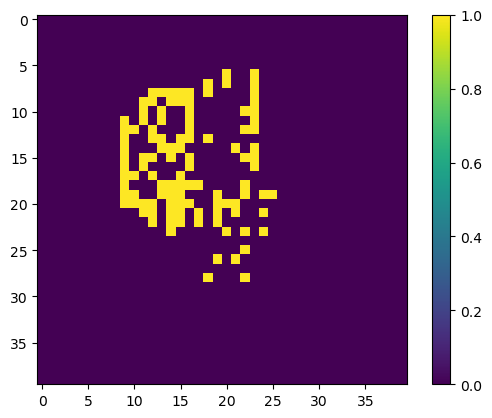

iteration 12-th of the algorithm 2 of optimization of the support
199 -th, precision :  0.0029159527651402626 norm u:  5.917412888383916e+46
199 -th, precision :  0.0010886388344427287 norm u:  1.3666535925926254e+45
199 -th, precision :  0.00014012695915104585 norm u:  8.903240038861744e+47
199 -th, precision :  0.00023973747851769567 norm u:  4.861365232960884e+47
199 -th, precision :  8.310682754936932e-05 norm u:  9.987356374289151e+46
Kulback descent 0-th iteration, precision = 0.0002382264342310433
199 -th, precision :  0.0030741705795937295 norm u:  6.611813227646424e+46
199 -th, precision :  0.0011363029080314786 norm u:  1.4688914230379437e+45
199 -th, precision :  0.00013551993786013026 norm u:  9.695339735729689e+47
199 -th, precision :  0.00023163358307048645 norm u:  5.175997186136349e+47
199 -th, precision :  8.807625526982389e-05 norm u:  1.1030127655926539e+47
Kulback descent 1-th iteration, precision = 0.00047700096419135967
199 -th, precision :  0.00315613006915697 no

199 -th, precision :  0.005522783599509074 norm u:  8.662692884793472e+49
Kulback descent 18-th iteration, precision = 0.004970682239692064
199 -th, precision :  0.030618706992722643 norm u:  5.035804098455231e+49
199 -th, precision :  0.024871612356338828 norm u:  4.703746589480444e+46
199 -th, precision :  0.006189673779181209 norm u:  6.461958354285841e+49
199 -th, precision :  0.008411552881187095 norm u:  2.233746472705296e+48
199 -th, precision :  0.012492779870991526 norm u:  8.091508906062847e+49
Kulback descent 19-th iteration, precision = 0.005179004985460213
199 -th, precision :  0.04327223753361758 norm u:  6.3026751026318e+48
199 -th, precision :  0.043946454852565806 norm u:  6.042925739828823e+45
199 -th, precision :  0.007421207876193388 norm u:  5.45298496785406e+49
199 -th, precision :  0.013327549560908489 norm u:  1.0696065162473084e+48
199 -th, precision :  0.03261879306770259 norm u:  2.7663258907322033e+49
Kulback descent 20-th iteration, precision = 0.0053340845

199 -th, precision :  0.002110168086626553 norm u:  1.8221692750606705e+33
199 -th, precision :  0.013350522751788944 norm u:  2.0323200182935194e+23
Kulback descent 37-th iteration, precision = 0.0016311052510948963
199 -th, precision :  0.06919534781674155 norm u:  8.249716005095717e+30
199 -th, precision :  0.029690179657348725 norm u:  3.057220974074745e+18
199 -th, precision :  0.01458744367112498 norm u:  1.355475770299039e+33
199 -th, precision :  0.0020626777340693437 norm u:  8.841695231858139e+32
199 -th, precision :  0.00919883128149874 norm u:  2.1728339853887056e+22
Kulback descent 38-th iteration, precision = 0.0015823412886193742
199 -th, precision :  0.07091483029185142 norm u:  1.1184527819002233e+31
199 -th, precision :  0.03192643396125102 norm u:  2.499939166354203e+18
199 -th, precision :  0.015043117247594167 norm u:  8.096923178758518e+32
199 -th, precision :  0.0022504984509311645 norm u:  4.866286111788259e+32
199 -th, precision :  0.013337531768081692 norm u: 

199 -th, precision :  0.019120463580215723 norm u:  7.673080480577568e+22
Kulback descent 56-th iteration, precision = 0.0012597072118956305
199 -th, precision :  0.07480767537054367 norm u:  4.7234789640536624e+30
199 -th, precision :  0.03876859831202968 norm u:  3805618385643380.0
199 -th, precision :  0.027889988708950257 norm u:  1.6218646026622263e+32
199 -th, precision :  0.004932144824348787 norm u:  2.1062721250332174e+31
199 -th, precision :  0.019211144885628334 norm u:  7.168055274226946e+22
Kulback descent 57-th iteration, precision = 0.0012380610072178148
199 -th, precision :  0.07666302405588715 norm u:  4.134558032470164e+30
199 -th, precision :  0.03946379849948266 norm u:  3128299658504139.5
199 -th, precision :  0.028435762281722825 norm u:  1.765739901412735e+32
199 -th, precision :  0.004986230297970346 norm u:  2.17069245345138e+31
199 -th, precision :  0.019232529809287652 norm u:  6.57528370971381e+22
Kulback descent 58-th iteration, precision = 0.00121564455166

199 -th, precision :  0.016488784575104522 norm u:  2.6301587424656816e+21
Kulback descent 75-th iteration, precision = 0.0007965996821768265
199 -th, precision :  0.08057196885844457 norm u:  4.267976705954702e+29
199 -th, precision :  0.03213606573120084 norm u:  260883488760940.28
199 -th, precision :  0.009684145517068988 norm u:  7.36466289866374e+31
199 -th, precision :  0.005326335079828402 norm u:  1.8741111339703253e+31
199 -th, precision :  0.01634651954682251 norm u:  2.0182655532890367e+21
Kulback descent 76-th iteration, precision = 0.0007707642308032866
199 -th, precision :  0.08042944178314207 norm u:  3.8601635424947966e+29
199 -th, precision :  0.032150919496542064 norm u:  251418024790399.28
199 -th, precision :  0.008539593561339355 norm u:  4.797806776015855e+31
199 -th, precision :  0.005326675083898057 norm u:  1.8061691880772482e+31
199 -th, precision :  0.016206691115750366 norm u:  1.5663441050965938e+21
Kulback descent 77-th iteration, precision = 0.0007457124

199 -th, precision :  0.015685782778922033 norm u:  1.3185683072305994e+29
199 -th, precision :  0.004454515580651107 norm u:  8.503758224406104e+30
199 -th, precision :  0.015121794540134232 norm u:  8.91947717016335e+19
Kulback descent 95-th iteration, precision = 0.00045012798157809754
199 -th, precision :  0.07908315187769989 norm u:  1.1852792958973414e+29
199 -th, precision :  0.03396368203530209 norm u:  192998448420224.44
199 -th, precision :  0.015992979974633434 norm u:  1.0836481718466757e+29
199 -th, precision :  0.004381707941745348 norm u:  8.130783203825027e+30
199 -th, precision :  0.015115915629125209 norm u:  7.956003987587506e+19
Kulback descent 96-th iteration, precision = 0.0004395922170557957
199 -th, precision :  0.07907272616394244 norm u:  1.1427321553125528e+29
199 -th, precision :  0.03394037007256405 norm u:  194510052815027.34
199 -th, precision :  0.016281351293184507 norm u:  9.001183622666821e+28
199 -th, precision :  0.004310962836554885 norm u:  7.7748

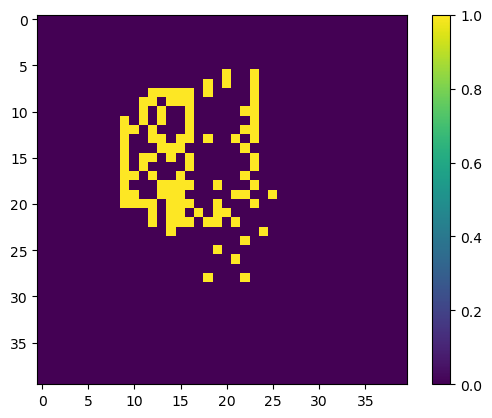

iteration 13-th of the algorithm 2 of optimization of the support
199 -th, precision :  0.0024295979315562114 norm u:  1.4009777324123403e+46
199 -th, precision :  0.0003826254079541023 norm u:  4.181264650608217e+44
199 -th, precision :  0.00015909299241662474 norm u:  2.0605145868601825e+47
199 -th, precision :  0.0004117096895350472 norm u:  1.0329055907837165e+47
199 -th, precision :  6.91021363639924e-05 norm u:  2.693346936759501e+46
Kulback descent 0-th iteration, precision = 0.00023603475020262592
199 -th, precision :  0.002529739311474701 norm u:  1.5547058135999497e+46
199 -th, precision :  0.00040340409560985733 norm u:  4.492600367467988e+44
199 -th, precision :  0.00015718758091586273 norm u:  2.2346900011757954e+47
199 -th, precision :  0.00043383801110790185 norm u:  1.0949198499188845e+47
199 -th, precision :  7.01531236008669e-05 norm u:  2.957331004383079e+46
Kulback descent 1-th iteration, precision = 0.00047262535342750954
199 -th, precision :  0.0025813628645905166

199 -th, precision :  0.0014319493047235538 norm u:  3.218436301524016e+49
Kulback descent 18-th iteration, precision = 0.005115582924677315
199 -th, precision :  0.021395824547556588 norm u:  3.1296110844528545e+49
199 -th, precision :  0.002291874673445165 norm u:  4.343343183607238e+46
199 -th, precision :  0.008927835555245869 norm u:  3.888061086163652e+49
199 -th, precision :  0.0026242123867539777 norm u:  2.4825370279381902e+48
199 -th, precision :  0.0017959950723137146 norm u:  4.905583465964164e+49
Kulback descent 19-th iteration, precision = 0.005390597919983894
199 -th, precision :  0.029567058337094387 norm u:  8.026843562697636e+48
199 -th, precision :  0.011595229022994829 norm u:  3.3034394017424536e+46
199 -th, precision :  0.01046786944017789 norm u:  3.3003550898722504e+49
199 -th, precision :  0.005911909037275102 norm u:  1.6133840885300748e+48
199 -th, precision :  0.0008782220077774637 norm u:  5.45081804269868e+49
Kulback descent 20-th iteration, precision = 0.

199 -th, precision :  0.00728575247927241 norm u:  8.62989164391303e+33
199 -th, precision :  0.015467946936168975 norm u:  4.5500701161486e+25
Kulback descent 37-th iteration, precision = 0.001950446335045047
199 -th, precision :  0.07193776363825344 norm u:  2.522322891676286e+31
199 -th, precision :  0.02213110372993138 norm u:  1.3193954048845327e+18
199 -th, precision :  0.010135017583685289 norm u:  6.59628295079798e+33
199 -th, precision :  0.006004923833006729 norm u:  3.105622395971333e+33
199 -th, precision :  0.014865676598759706 norm u:  4.380336969097686e+25
Kulback descent 38-th iteration, precision = 0.001867401010720143
199 -th, precision :  0.07406538651247206 norm u:  3.069982930603353e+31
199 -th, precision :  0.026812117274166176 norm u:  8.885155761175585e+17
199 -th, precision :  0.011054350833030796 norm u:  3.870620624999318e+33
199 -th, precision :  0.005174733747179791 norm u:  1.3485817249959766e+33
199 -th, precision :  0.01378633687191882 norm u:  3.7607586

199 -th, precision :  0.003955992361526919 norm u:  5.457998192917743e+31
199 -th, precision :  0.00935922596958178 norm u:  3.79596962003858e+23
Kulback descent 56-th iteration, precision = 0.0013085988719963478
199 -th, precision :  0.07943619001795305 norm u:  8.671183099343857e+30
199 -th, precision :  0.03445018523260612 norm u:  1359402702939003.8
199 -th, precision :  0.017479472691734606 norm u:  3.239780729706084e+32
199 -th, precision :  0.004077198500976107 norm u:  5.659748962149989e+31
199 -th, precision :  0.00888882374573859 norm u:  3.094317622821031e+23
Kulback descent 57-th iteration, precision = 0.001281308395268277
199 -th, precision :  0.08063353736285621 norm u:  7.21317293667777e+30
199 -th, precision :  0.035480507709013724 norm u:  1169854165898551.8
199 -th, precision :  0.01709400444819838 norm u:  3.5079849924549245e+32
199 -th, precision :  0.004184046971521616 norm u:  5.875008484935386e+31
199 -th, precision :  0.007904885034904214 norm u:  2.582346510124

199 -th, precision :  0.023843210704113764 norm u:  5.115760097562431e+21
Kulback descent 75-th iteration, precision = 0.0007347579750405597
199 -th, precision :  0.08287705305590111 norm u:  8.325041505187966e+29
199 -th, precision :  0.0327736680451016 norm u:  441853071834746.75
199 -th, precision :  0.01707155418168721 norm u:  1.3376424429427392e+31
199 -th, precision :  0.003996319932586167 norm u:  8.39450385250621e+31
199 -th, precision :  0.025015215668326908 norm u:  3.762824121338473e+21
Kulback descent 76-th iteration, precision = 0.0007107371188210191
199 -th, precision :  0.0828686606735666 norm u:  7.718439676490105e+29
199 -th, precision :  0.03216264749407407 norm u:  450617704259976.1
199 -th, precision :  0.018373723476653586 norm u:  7.907509612169482e+30
199 -th, precision :  0.003959336811309121 norm u:  8.014203430553328e+31
199 -th, precision :  0.02641956806126467 norm u:  2.744852544883278e+21
Kulback descent 77-th iteration, precision = 0.0006880445651297582


199 -th, precision :  0.026978438439967826 norm u:  642391983949517.8
199 -th, precision :  0.025957054679615534 norm u:  1.8534212293127693e+28
199 -th, precision :  0.004509475765135947 norm u:  2.8680065054976503e+31
199 -th, precision :  0.030896257028910273 norm u:  3.810359695694996e+19
Kulback descent 95-th iteration, precision = 0.00043220489271573315
199 -th, precision :  0.082700187609518 norm u:  3.081366547801356e+29
199 -th, precision :  0.026679646831022155 norm u:  653138966500867.6
199 -th, precision :  0.02601105138962498 norm u:  1.5198943571305543e+28
199 -th, precision :  0.0045751226842982145 norm u:  2.727914832522169e+31
199 -th, precision :  0.030806620011006484 norm u:  3.6216454096709812e+19
Kulback descent 96-th iteration, precision = 0.00042245177587027787
199 -th, precision :  0.08269574875030161 norm u:  2.9897422772424636e+29
199 -th, precision :  0.026364653618333473 norm u:  663926157136412.4
199 -th, precision :  0.02605231909894041 norm u:  1.25884735

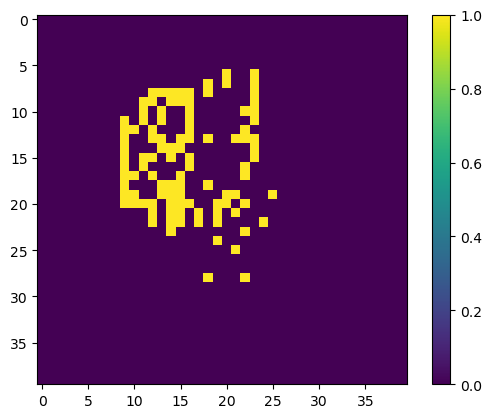

iteration 14-th of the algorithm 2 of optimization of the support
199 -th, precision :  0.0015017482586075197 norm u:  3.7113956021491485e+45
199 -th, precision :  0.0002979738582853623 norm u:  1.550742429499755e+44
199 -th, precision :  0.00016526947866947974 norm u:  7.091230216193565e+46
199 -th, precision :  0.0005234617800822198 norm u:  7.022796606258691e+46
199 -th, precision :  1.554381302898463e-05 norm u:  9.221166201780867e+45
Kulback descent 0-th iteration, precision = 0.00023477003979405244
199 -th, precision :  0.0015662217327875685 norm u:  4.089907430200006e+45
199 -th, precision :  0.0003143374854051973 norm u:  1.6679099452835627e+44
199 -th, precision :  0.00016542266661490412 norm u:  7.698885453349246e+46
199 -th, precision :  0.0005267001057351604 norm u:  7.499847875017766e+46
199 -th, precision :  1.5176342856051782e-05 norm u:  1.0112068392935564e+46
Kulback descent 1-th iteration, precision = 0.00047015189482270343
199 -th, precision :  0.0015994310708766983 

199 -th, precision :  0.00024449862100896826 norm u:  1.200020404315163e+49
Kulback descent 18-th iteration, precision = 0.005213290381912296
199 -th, precision :  0.017458018703440183 norm u:  4.526775199232134e+49
199 -th, precision :  0.0008819694584737754 norm u:  2.2696835329142538e+46
199 -th, precision :  0.002168003331786352 norm u:  2.8697538446454366e+49
199 -th, precision :  0.002384292167437301 norm u:  5.102492369333082e+48
199 -th, precision :  0.00033890536747649956 norm u:  2.0153467270769754e+49
Kulback descent 19-th iteration, precision = 0.005533643006384276
199 -th, precision :  0.02062216943557731 norm u:  1.3925726200858082e+49
199 -th, precision :  0.004052631548173157 norm u:  2.0250013891630915e+46
199 -th, precision :  0.0052742248805382665 norm u:  3.544183494005504e+49
199 -th, precision :  0.0037730470486279978 norm u:  4.158990910877994e+48
199 -th, precision :  0.0010156598619302036 norm u:  2.757733074575685e+49
Kulback descent 20-th iteration, precision

199 -th, precision :  0.005554701486322821 norm u:  8.321122218708661e+33
199 -th, precision :  0.028921813959991636 norm u:  3.6882399456661465e+27
Kulback descent 37-th iteration, precision = 0.0023062794602024105
199 -th, precision :  0.0634939354694816 norm u:  2.7845415826380833e+30
199 -th, precision :  0.01635271699421417 norm u:  4.1426129759490565e+18
199 -th, precision :  0.010355705348343588 norm u:  3.544890355087774e+34
199 -th, precision :  0.0029932073124319565 norm u:  2.562812612364348e+33
199 -th, precision :  0.03005385166362155 norm u:  2.309153109323275e+27
Kulback descent 38-th iteration, precision = 0.0021844846768184606
199 -th, precision :  0.06546857246677797 norm u:  2.9564424954767534e+30
199 -th, precision :  0.022661181992991206 norm u:  2.753784712235804e+18
199 -th, precision :  0.011354218717047178 norm u:  1.8625317687996165e+34
199 -th, precision :  0.0009830371704306737 norm u:  1.0101365875084183e+33
199 -th, precision :  0.03123001222080593 norm u:

199 -th, precision :  0.001041952432114074 norm u:  6.1830337132869e+31
199 -th, precision :  0.017652013652259022 norm u:  1.3314241759994414e+21
Kulback descent 56-th iteration, precision = 0.0013355867030300128
199 -th, precision :  0.07073010441084543 norm u:  3.858984918617124e+30
199 -th, precision :  0.04525422199241182 norm u:  1092426734976775.5
199 -th, precision :  0.015508918603606594 norm u:  1.9101066654553183e+33
199 -th, precision :  0.001269470140026183 norm u:  6.6952801911967435e+31
199 -th, precision :  0.016311641329937218 norm u:  6.284720123560628e+20
Kulback descent 57-th iteration, precision = 0.0012986817790869678
199 -th, precision :  0.07373263118800912 norm u:  3.445102620868095e+30
199 -th, precision :  0.045524500563870945 norm u:  1093340821253872.6
199 -th, precision :  0.015526118021580253 norm u:  1.8650530393796023e+33
199 -th, precision :  0.0014531824531903565 norm u:  7.246478142316021e+31
199 -th, precision :  0.014250364326848026 norm u:  3.0881

199 -th, precision :  0.07887474678286469 norm u:  3.580481433647568e+29
199 -th, precision :  0.026635987156194127 norm u:  548187096188878.0
199 -th, precision :  0.01139046049126465 norm u:  9.011092894659856e+31
199 -th, precision :  0.0034899256928936266 norm u:  1.0822267602226537e+32
199 -th, precision :  0.013853526154115564 norm u:  4.895545249899184e+18
Kulback descent 76-th iteration, precision = 0.0007365062005568374
199 -th, precision :  0.0788329757484531 norm u:  3.2437462612768835e+29
199 -th, precision :  0.025589223764574977 norm u:  532460139943690.0
199 -th, precision :  0.010771790669547499 norm u:  6.515438216667996e+31
199 -th, precision :  0.0036998990013869227 norm u:  1.0557441882997004e+32
199 -th, precision :  0.014751260423182156 norm u:  4.871536276481017e+18
Kulback descent 77-th iteration, precision = 0.0007151684317878129
199 -th, precision :  0.07879521957677314 norm u:  2.9448995883930775e+29
199 -th, precision :  0.024681970530734523 norm u:  5182077

199 -th, precision :  0.018492636576172925 norm u:  337169366519026.2
199 -th, precision :  0.016674331733789374 norm u:  2.393024279442099e+29
199 -th, precision :  0.004699879009261335 norm u:  4.239805479993154e+31
199 -th, precision :  0.017038530166982174 norm u:  3.555261634642105e+18
Kulback descent 95-th iteration, precision = 0.0004357500894405347
199 -th, precision :  0.07967330622355633 norm u:  1.0903906733275888e+29
199 -th, precision :  0.01830870452741975 norm u:  327831315000439.9
199 -th, precision :  0.016902146071901814 norm u:  1.942291536988807e+29
199 -th, precision :  0.004697428072504501 norm u:  3.9948420013444784e+31
199 -th, precision :  0.016696360264545386 norm u:  3.294405487242502e+18
Kulback descent 96-th iteration, precision = 0.0004251954193512201
199 -th, precision :  0.07978892301709996 norm u:  1.0752172419390588e+29
199 -th, precision :  0.018129277731004798 norm u:  318853048703886.44
199 -th, precision :  0.017094899545694327 norm u:  1.595558748

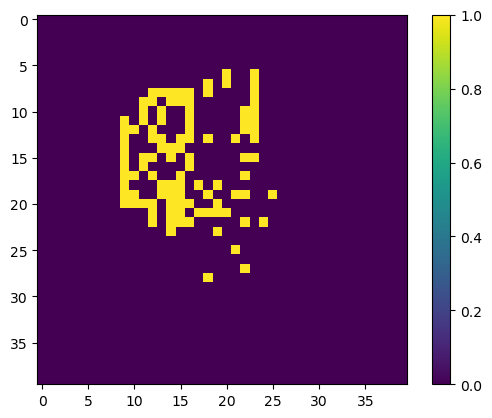

iteration 15-th of the algorithm 2 of optimization of the support
199 -th, precision :  0.001241693300095546 norm u:  1.1017672798865249e+45
199 -th, precision :  0.00024043901765853184 norm u:  3.921025909247791e+43
199 -th, precision :  0.000140589762372912 norm u:  2.6891008058603373e+46
199 -th, precision :  0.0004239042079941876 norm u:  3.828013210791235e+46
199 -th, precision :  8.82473781997158e-06 norm u:  3.3744583908904756e+45
Kulback descent 0-th iteration, precision = 0.0002276264144411606
199 -th, precision :  0.001295101628095893 norm u:  1.2058551050133506e+45
199 -th, precision :  0.0002534661204171733 norm u:  4.1941307776680155e+43
199 -th, precision :  0.00014015035777154274 norm u:  2.9049130462351934e+46
199 -th, precision :  0.0004326629926626531 norm u:  4.0575074406860086e+46
199 -th, precision :  9.545108283138492e-06 norm u:  3.6739004486530526e+45
Kulback descent 1-th iteration, precision = 0.0004558146603888239
199 -th, precision :  0.0013226603773291226 no

199 -th, precision :  0.0007789429498556672 norm u:  2.3676673101987163e+48
199 -th, precision :  0.00040080995766667075 norm u:  2.790823977481164e+48
Kulback descent 18-th iteration, precision = 0.00514439041812292
199 -th, precision :  0.005180186913810964 norm u:  1.4954928569286005e+49
199 -th, precision :  0.0016575481397788894 norm u:  6.163659974625569e+45
199 -th, precision :  0.0020965687096773274 norm u:  1.0040373456555013e+49
199 -th, precision :  0.0014630616438876126 norm u:  2.7569171201043968e+48
199 -th, precision :  0.0004415742475503552 norm u:  4.835965458604646e+48
Kulback descent 19-th iteration, precision = 0.005494803478059969
199 -th, precision :  0.017025866912409628 norm u:  8.36015526959902e+48
199 -th, precision :  0.0011194275512207217 norm u:  6.946855699383922e+45
199 -th, precision :  0.004069474535785454 norm u:  1.33811943371167e+49
199 -th, precision :  0.002350765228784305 norm u:  2.8182912781256903e+48
199 -th, precision :  0.0005749183511484957 

199 -th, precision :  0.015345470562667204 norm u:  1.2199962204070539e+26
Kulback descent 37-th iteration, precision = 0.002661847654034717
199 -th, precision :  0.049788633966136954 norm u:  1.7261869552942574e+30
199 -th, precision :  0.007317464171696587 norm u:  1.2699490410989101e+19
199 -th, precision :  0.004154643324993285 norm u:  4.398232431538221e+34
199 -th, precision :  0.006031120043252948 norm u:  4.555909692418246e+33
199 -th, precision :  0.017892290088292476 norm u:  1.572176841954157e+26
Kulback descent 38-th iteration, precision = 0.002427954427330167
199 -th, precision :  0.05444681527885204 norm u:  2.287438240421546e+30
199 -th, precision :  0.014398935460601735 norm u:  4.374382876013372e+18
199 -th, precision :  0.008308187909384515 norm u:  1.4667767762037855e+34
199 -th, precision :  0.0011334132776980959 norm u:  9.374790315291295e+32
199 -th, precision :  0.018521315402377322 norm u:  1.7866790657544637e+26
Kulback descent 39-th iteration, precision = 0.00

199 -th, precision :  0.038189361822822586 norm u:  287836229264515.8
199 -th, precision :  0.018022637084830942 norm u:  2.5161177668115204e+33
199 -th, precision :  0.003083203449095324 norm u:  2.692044041009203e+31
199 -th, precision :  0.020868091269240493 norm u:  1.8224797454481371e+25
Kulback descent 57-th iteration, precision = 0.001265638425141986
199 -th, precision :  0.07735662902435518 norm u:  9.188806542433811e+29
199 -th, precision :  0.03801623712804426 norm u:  259342816507622.06
199 -th, precision :  0.018060987945247783 norm u:  2.5586554373615246e+33
199 -th, precision :  0.0026475616223076695 norm u:  2.9685830119879224e+31
199 -th, precision :  0.021372515368725382 norm u:  1.4747707335832421e+25
Kulback descent 58-th iteration, precision = 0.0012448590229560386
199 -th, precision :  0.0774563957046898 norm u:  7.725343473846415e+29
199 -th, precision :  0.03781320360309078 norm u:  235855339814443.06
199 -th, precision :  0.01801076522591693 norm u:  2.566381554

199 -th, precision :  0.002525058821855969 norm u:  1.2962547853630227e+32
199 -th, precision :  0.0023963871459233587 norm u:  7.117009636256676e+31
199 -th, precision :  0.024383609611527683 norm u:  2.0516747675598217e+23
Kulback descent 76-th iteration, precision = 0.0008463716824397239
199 -th, precision :  0.07714316546682969 norm u:  9.631087515975497e+28
199 -th, precision :  0.03138086952331787 norm u:  246278446851687.03
199 -th, precision :  0.0021131402567642964 norm u:  8.232374419305387e+31
199 -th, precision :  0.002503340648861977 norm u:  7.018293706154333e+31
199 -th, precision :  0.02400131825454021 norm u:  1.5985454629408744e+23
Kulback descent 77-th iteration, precision = 0.0008256506880939985
199 -th, precision :  0.07723840649879025 norm u:  9.050377731676422e+28
199 -th, precision :  0.03110590593074998 norm u:  255949377960102.4
199 -th, precision :  0.0013196753565781502 norm u:  5.232612013219801e+31
199 -th, precision :  0.0025990321869830686 norm u:  6.882

199 -th, precision :  0.012860350317752374 norm u:  2.4447257668223425e+29
199 -th, precision :  0.003136903688426659 norm u:  3.4355196585202537e+31
199 -th, precision :  0.018190090825740957 norm u:  6.037203513859649e+21
Kulback descent 95-th iteration, precision = 0.0005355367658847577
199 -th, precision :  0.07983635301220907 norm u:  5.442310171105435e+28
199 -th, precision :  0.028150371422139588 norm u:  457028309036721.94
199 -th, precision :  0.013304110388283094 norm u:  1.9991101150315115e+29
199 -th, precision :  0.0031375135126332455 norm u:  3.2839582249314594e+31
199 -th, precision :  0.018050723353023573 norm u:  5.28953785905364e+21
Kulback descent 96-th iteration, precision = 0.0005235283505611692
199 -th, precision :  0.07997467926880995 norm u:  5.376897002035629e+28
199 -th, precision :  0.0280383044274783 norm u:  468682071583697.9
199 -th, precision :  0.013719024768665624 norm u:  1.6485577658443668e+29
199 -th, precision :  0.0031371660633432393 norm u:  3.139

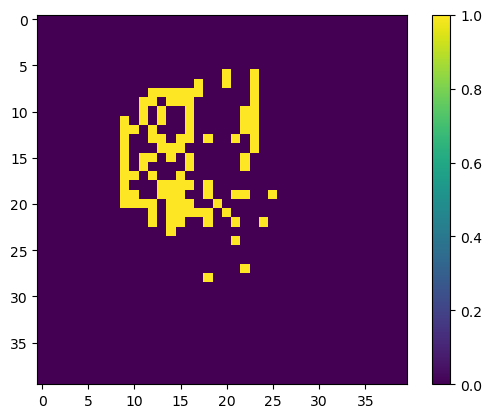

iteration 16-th of the algorithm 2 of optimization of the support
199 -th, precision :  0.0008722835163785399 norm u:  3.7569351978260134e+44
199 -th, precision :  0.0002068137214061773 norm u:  1.2662705785900468e+43
199 -th, precision :  0.0001264861056471002 norm u:  1.0829519823488084e+46
199 -th, precision :  0.00036488077352594435 norm u:  1.313985717311737e+46
199 -th, precision :  1.3106613115675573e-05 norm u:  1.2381297170062201e+45
Kulback descent 0-th iteration, precision = 0.00022424428451022285
199 -th, precision :  0.0009109109787690451 norm u:  4.087957403064661e+44
199 -th, precision :  0.0002173612717577237 norm u:  1.3505815127695798e+43
199 -th, precision :  0.00012613805688354982 norm u:  1.1650247837615225e+46
199 -th, precision :  0.0003708675641648376 norm u:  1.3884721796583222e+46
199 -th, precision :  1.4190699779405581e-05 norm u:  1.3427307571672232e+45
Kulback descent 1-th iteration, precision = 0.00044905059752526613
199 -th, precision :  0.00093099630289

199 -th, precision :  0.0009055073835669529 norm u:  2.2354908895700643e+48
199 -th, precision :  0.0007458808974327202 norm u:  7.803777232932572e+47
199 -th, precision :  0.0006003836519718913 norm u:  8.314080373518281e+47
Kulback descent 18-th iteration, precision = 0.005169887656779885
199 -th, precision :  0.002811372251188631 norm u:  4.5068736667794045e+48
199 -th, precision :  0.0019562568703467413 norm u:  2.1145217656921447e+45
199 -th, precision :  0.001798939840591678 norm u:  3.3449572020019794e+48
199 -th, precision :  0.0013431670737871011 norm u:  9.454786658484991e+47
199 -th, precision :  0.0007562252021985325 norm u:  1.497225891149433e+48
Kulback descent 19-th iteration, precision = 0.005546064175867985
199 -th, precision :  0.010594034124365524 norm u:  5.784156878022811e+48
199 -th, precision :  0.0006221380031958093 norm u:  2.8631794072838044e+45
199 -th, precision :  0.00353918609440649 norm u:  4.5027549786513486e+48
199 -th, precision :  0.001967847175581100

199 -th, precision :  0.008133952851329717 norm u:  1.3030990007340922e+20
199 -th, precision :  0.0015927945090285479 norm u:  3.2668834351844124e+34
199 -th, precision :  0.012245283259269773 norm u:  1.3144854285740105e+35
199 -th, precision :  0.022456178217982396 norm u:  7.439875320168701e+29
Kulback descent 37-th iteration, precision = 0.0028165445837034586
199 -th, precision :  0.06018544717459907 norm u:  1.668351925727972e+30
199 -th, precision :  0.01723299838690479 norm u:  1.3494234205417079e+19
199 -th, precision :  0.005592899814938764 norm u:  8.795174630054136e+33
199 -th, precision :  0.010380025505105991 norm u:  2.5560595649204964e+34
199 -th, precision :  0.017364940716309587 norm u:  4.278680972668596e+28
Kulback descent 38-th iteration, precision = 0.002507349523036667
199 -th, precision :  0.06343333558351684 norm u:  1.9819087050889408e+30
199 -th, precision :  0.022312912749271396 norm u:  3.6253543585672044e+18
199 -th, precision :  0.008175917176225053 norm 

199 -th, precision :  0.017256748138058043 norm u:  4.846446970452998e+32
199 -th, precision :  0.002743894117170975 norm u:  1.0228455513284162e+32
199 -th, precision :  0.01549746033160093 norm u:  3.6031772123010847e+25
Kulback descent 56-th iteration, precision = 0.0013810347003834946
199 -th, precision :  0.07825704985205785 norm u:  1.4560648310924365e+30
199 -th, precision :  0.044561200042365565 norm u:  132946672051893.89
199 -th, precision :  0.01721357977049681 norm u:  5.2540588741476696e+32
199 -th, precision :  0.002851702459466027 norm u:  1.0851968800438708e+32
199 -th, precision :  0.01575459942724574 norm u:  3.042792119038731e+25
Kulback descent 57-th iteration, precision = 0.001362090761749968
199 -th, precision :  0.07838544598770798 norm u:  1.2489425433634404e+30
199 -th, precision :  0.043622027324920154 norm u:  126023132481459.7
199 -th, precision :  0.017023460360066144 norm u:  5.5849163525319686e+32
199 -th, precision :  0.0029498421132887944 norm u:  1.150

199 -th, precision :  0.0028997138061750273 norm u:  1.5172811479524748e+32
199 -th, precision :  0.027534514746298543 norm u:  5.127660379949618e+23
Kulback descent 75-th iteration, precision = 0.0008894416213074902
199 -th, precision :  0.07589201886902602 norm u:  1.0067997649096985e+29
199 -th, precision :  0.027340391773496637 norm u:  178182358794536.3
199 -th, precision :  0.004422076402262521 norm u:  4.284447028877681e+31
199 -th, precision :  0.0028395897004864354 norm u:  1.4490475686626791e+32
199 -th, precision :  0.027880808307480947 norm u:  3.909092383547995e+23
Kulback descent 76-th iteration, precision = 0.0008651007397732871
199 -th, precision :  0.07583619891261056 norm u:  9.049300275860229e+28
199 -th, precision :  0.02691868332105783 norm u:  183292530174801.84
199 -th, precision :  0.005181429892139628 norm u:  2.8113148226055143e+31
199 -th, precision :  0.002782044615540019 norm u:  1.376120317088958e+32
199 -th, precision :  0.028124799413485103 norm u:  2.99

199 -th, precision :  0.07576475736711141 norm u:  3.191388314530421e+28
199 -th, precision :  0.02292768314324182 norm u:  240859860975742.47
199 -th, precision :  0.017481966930792976 norm u:  1.930966087201268e+29
199 -th, precision :  0.0024369578964419125 norm u:  4.145639150126761e+31
199 -th, precision :  0.02403374615897091 norm u:  1.4042662740335142e+22
Kulback descent 95-th iteration, precision = 0.0005282071423839351
199 -th, precision :  0.07579709482273615 norm u:  3.107545491705597e+28
199 -th, precision :  0.022766482849252517 norm u:  242898123280484.03
199 -th, precision :  0.017896666744894738 norm u:  1.634577714165352e+29
199 -th, precision :  0.002434731229543516 norm u:  3.893592450012819e+31
199 -th, precision :  0.02374457204329392 norm u:  1.2687082919435579e+22
Kulback descent 96-th iteration, precision = 0.0005171456094404601
199 -th, precision :  0.07583013652139309 norm u:  3.030278041286099e+28
199 -th, precision :  0.022598974954928148 norm u:  244808151

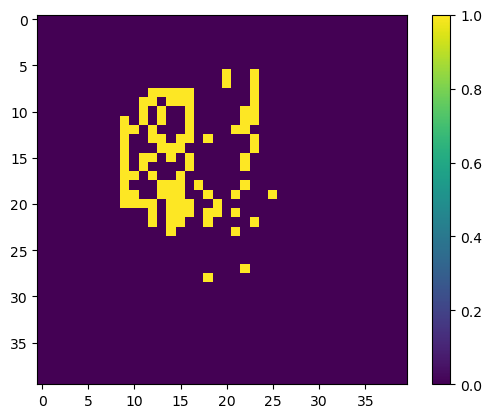

iteration 17-th of the algorithm 2 of optimization of the support
199 -th, precision :  0.00045048433895132514 norm u:  1.359972156568947e+44
199 -th, precision :  0.0003894930502987237 norm u:  7.188314200914752e+42
199 -th, precision :  6.882916476608058e-05 norm u:  7.439380615352851e+45
199 -th, precision :  0.00023274460081062432 norm u:  1.0547770921936413e+46
199 -th, precision :  2.544117345416371e-05 norm u:  7.493883203888041e+44
Kulback descent 0-th iteration, precision = 0.0002271698618772818
199 -th, precision :  0.00047080770363046694 norm u:  1.474536370861362e+44
199 -th, precision :  0.0004036292408857203 norm u:  7.654592456905825e+42
199 -th, precision :  6.81598471061264e-05 norm u:  7.947590070664461e+45
199 -th, precision :  0.00023372073836659354 norm u:  1.1121897333057104e+46
199 -th, precision :  2.693940113567375e-05 norm u:  8.117672168531729e+44
Kulback descent 1-th iteration, precision = 0.0004549101645436274
199 -th, precision :  0.000481444699324455 norm

199 -th, precision :  0.00031018111144011807 norm u:  4.627637208770843e+47
199 -th, precision :  0.0007356275815381474 norm u:  5.270110742113034e+47
Kulback descent 18-th iteration, precision = 0.005253612718491831
199 -th, precision :  0.0055034214565018325 norm u:  1.3907751883070233e+48
199 -th, precision :  0.00149719021113737 norm u:  1.9293569328740323e+45
199 -th, precision :  0.0016941063283561057 norm u:  1.3860150698050636e+48
199 -th, precision :  0.0006292415319686544 norm u:  5.656145285433116e+47
199 -th, precision :  0.0009610261181817795 norm u:  1.0132249787269937e+48
Kulback descent 19-th iteration, precision = 0.005640515441472657
199 -th, precision :  0.003998707633719337 norm u:  3.655425195263566e+48
199 -th, precision :  0.0006066135086921124 norm u:  2.7357462608045857e+45
199 -th, precision :  0.0021651737527270953 norm u:  1.8093992482317435e+48
199 -th, precision :  0.0011723878461679734 norm u:  6.248437467469566e+47
199 -th, precision :  0.001229274033893

199 -th, precision :  0.004369385705376992 norm u:  5.581373993420696e+34
199 -th, precision :  0.009829471251354908 norm u:  7.241125850582533e+34
199 -th, precision :  0.016736959698704253 norm u:  2.0581175430879263e+26
Kulback descent 37-th iteration, precision = 0.0031337276318968263
199 -th, precision :  0.06196866995701019 norm u:  8.676874710965869e+31
199 -th, precision :  0.0238254634388668 norm u:  2.051218491841384e+19
199 -th, precision :  0.007495566005375372 norm u:  1.7592030197952731e+34
199 -th, precision :  0.006961737176447504 norm u:  1.4749149119453334e+34
199 -th, precision :  0.015522206431219047 norm u:  1.2390849485836915e+26
Kulback descent 38-th iteration, precision = 0.0028122251479762855
199 -th, precision :  0.0661720143195956 norm u:  1.0952389787404953e+32
199 -th, precision :  0.028920765473799806 norm u:  4.038560321374751e+18
199 -th, precision :  0.010010719257011714 norm u:  7.245242959271535e+33
199 -th, precision :  0.004812763245413612 norm u:  

199 -th, precision :  0.021356198915287398 norm u:  2.0742243776402638e+23
Kulback descent 56-th iteration, precision = 0.0015051105073306944
199 -th, precision :  0.07347232663179251 norm u:  4.3008450574687616e+30
199 -th, precision :  0.04543843359743425 norm u:  209411844285356.12
199 -th, precision :  0.014148550759820468 norm u:  1.6071172059173322e+33
199 -th, precision :  0.0014366327750523803 norm u:  3.8751051648294615e+31
199 -th, precision :  0.021092835024542175 norm u:  9.955258881971275e+22
Kulback descent 57-th iteration, precision = 0.0014780738994076878
199 -th, precision :  0.07580619703504131 norm u:  3.348890938747253e+30
199 -th, precision :  0.04538479575372851 norm u:  211947523791651.53
199 -th, precision :  0.01415326014328705 norm u:  1.725703093223735e+33
199 -th, precision :  0.0013781140058388589 norm u:  3.948770620091753e+31
199 -th, precision :  0.020622044248132177 norm u:  5.0377838809610986e+22
Kulback descent 58-th iteration, precision = 0.001450065

199 -th, precision :  0.023006360687723583 norm u:  3.8230373255665e+20
Kulback descent 75-th iteration, precision = 0.0009215237085939119
199 -th, precision :  0.07903214900399598 norm u:  1.657641432562742e+29
199 -th, precision :  0.03623403093152969 norm u:  254833906300121.6
199 -th, precision :  0.0013101225870890052 norm u:  1.9715407135831256e+32
199 -th, precision :  0.0007114617786821332 norm u:  2.355022323752577e+31
199 -th, precision :  0.023035002278224925 norm u:  3.289193587507504e+20
Kulback descent 76-th iteration, precision = 0.0008956828462664443
199 -th, precision :  0.07894700474585784 norm u:  1.5139670542902972e+29
199 -th, precision :  0.03569024424953126 norm u:  255257971715452.78
199 -th, precision :  0.0013375218018592092 norm u:  1.3081950388397448e+32
199 -th, precision :  0.0007170723128652832 norm u:  2.227381543161021e+31
199 -th, precision :  0.023040960839722353 norm u:  2.8473524417070386e+20
Kulback descent 77-th iteration, precision = 0.0008703127

199 -th, precision :  0.02201781635395223 norm u:  5.345397854845797e+19
Kulback descent 94-th iteration, precision = 0.0005274883437757188
199 -th, precision :  0.07684386447701734 norm u:  5.739886324313931e+28
199 -th, precision :  0.02351001944566577 norm u:  266171828934467.03
199 -th, precision :  0.015936943431805507 norm u:  4.036798001748623e+29
199 -th, precision :  0.0008948933935956461 norm u:  7.765285626881545e+30
199 -th, precision :  0.02193778829676406 norm u:  4.984316655248485e+19
Kulback descent 95-th iteration, precision = 0.0005126407535786585
199 -th, precision :  0.07672705683171088 norm u:  5.56505943586097e+28
199 -th, precision :  0.02313166450669457 norm u:  265333922010699.3
199 -th, precision :  0.01639816819371873 norm u:  3.294080042493188e+29
199 -th, precision :  0.0009014891563777549 norm u:  7.357898143245395e+30
199 -th, precision :  0.021855861237032898 norm u:  4.6527522987218166e+19
Kulback descent 96-th iteration, precision = 0.00049824849875704

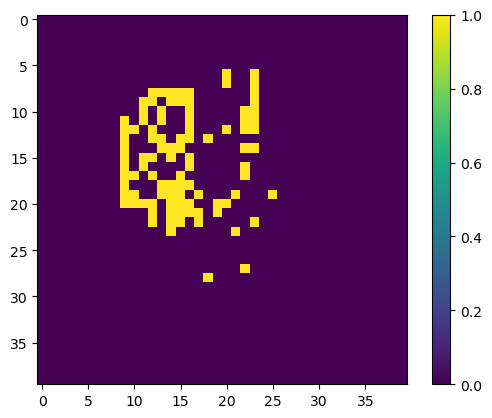

iteration 18-th of the algorithm 2 of optimization of the support
199 -th, precision :  0.00041853575056923875 norm u:  6.156501710089861e+43
199 -th, precision :  0.00035370280786971926 norm u:  3.3912159375046066e+42
199 -th, precision :  5.896343133553602e-05 norm u:  3.498926525146578e+45
199 -th, precision :  0.00022074195566829672 norm u:  4.090356268309691e+45
199 -th, precision :  4.0116740203450176e-05 norm u:  2.8314433269974755e+44
Kulback descent 0-th iteration, precision = 0.0002228151925383827
199 -th, precision :  0.0004372654732644433 norm u:  6.647398336170912e+43
199 -th, precision :  0.0003662286214726449 norm u:  3.598500301315981e+42
199 -th, precision :  5.8077428721936424e-05 norm u:  3.7182843398098696e+45
199 -th, precision :  0.00022298543760019952 norm u:  4.29385706984019e+45
199 -th, precision :  4.207805069315994e-05 norm u:  3.052940550722662e+44
Kulback descent 1-th iteration, precision = 0.00044618140189862
199 -th, precision :  0.00044707045725141846 n

Kulback descent 18-th iteration, precision = 0.005222002301033276
199 -th, precision :  0.005091796604532602 norm u:  4.084644260117195e+47
199 -th, precision :  0.0011487803633630901 norm u:  7.741965712693395e+44
199 -th, precision :  0.0018040634207782105 norm u:  4.133401660338508e+47
199 -th, precision :  0.0004789159260110408 norm u:  1.6665790548209886e+47
199 -th, precision :  0.0011332672561257238 norm u:  2.5372730928403233e+47
Kulback descent 19-th iteration, precision = 0.005624221840559341
199 -th, precision :  0.004814337182625366 norm u:  1.0840933978914496e+48
199 -th, precision :  0.00041600383412761374 norm u:  1.1005369788202168e+45
199 -th, precision :  0.0020511199633535954 norm u:  5.202593120775404e+47
199 -th, precision :  0.0009182006062268745 norm u:  1.9408249585626437e+47
199 -th, precision :  0.0015018785095116055 norm u:  4.627342574689084e+47
Kulback descent 20-th iteration, precision = 0.006028656887075923
199 -th, precision :  0.0031903673717624463 norm

199 -th, precision :  0.013361543855938839 norm u:  7.93828650416877e+26
Kulback descent 37-th iteration, precision = 0.003471977119561808
199 -th, precision :  0.041255781021889766 norm u:  4.932962198655937e+32
199 -th, precision :  0.01855860384617318 norm u:  4.815588221198118e+19
199 -th, precision :  0.005088371275115189 norm u:  1.4270813789259693e+34
199 -th, precision :  0.0035132051915742145 norm u:  1.484137333274974e+34
199 -th, precision :  0.008349517832026952 norm u:  1.0579771606381758e+27
Kulback descent 38-th iteration, precision = 0.003124010781595448
199 -th, precision :  0.04086017786044618 norm u:  2.9570148864854044e+32
199 -th, precision :  0.022351730401876633 norm u:  1.3590449918673183e+19
199 -th, precision :  0.007952325533222577 norm u:  5.0189882990214055e+33
199 -th, precision :  0.0014791960135417206 norm u:  3.842352327746527e+33
199 -th, precision :  0.012752544506333995 norm u:  1.3437373052741425e+27
Kulback descent 39-th iteration, precision = 0.00

199 -th, precision :  0.0028175783030382523 norm u:  3.410548325185769e+31
199 -th, precision :  0.01871553068807546 norm u:  5.192266922737725e+23
Kulback descent 56-th iteration, precision = 0.0015128820133377806
199 -th, precision :  0.06119885024667709 norm u:  8.88275297480123e+30
199 -th, precision :  0.042253967277753775 norm u:  467211109454969.9
199 -th, precision :  0.014624448268967284 norm u:  4.33903333364149e+32
199 -th, precision :  0.0027742700294515242 norm u:  3.6796058455289627e+31
199 -th, precision :  0.0188453517184372 norm u:  4.5723966827821275e+23
Kulback descent 57-th iteration, precision = 0.0014873192722864373
199 -th, precision :  0.06198560430988983 norm u:  7.278410342486202e+30
199 -th, precision :  0.042983718204405205 norm u:  495138817637140.8
199 -th, precision :  0.01551394252614744 norm u:  4.891888734054714e+32
199 -th, precision :  0.002722655180259908 norm u:  3.9762849714634264e+31
199 -th, precision :  0.0189566678630154 norm u:  4.00020073261

199 -th, precision :  0.021211670521707436 norm u:  1.7741142740102063e+22
Kulback descent 75-th iteration, precision = 0.0009027675036701621
199 -th, precision :  0.05978175839035831 norm u:  3.9501228347796546e+29
199 -th, precision :  0.04167256177409689 norm u:  830766587446776.9
199 -th, precision :  0.001864004972340427 norm u:  1.8847699949643685e+31
199 -th, precision :  0.003497111541685817 norm u:  6.227612914825255e+31
199 -th, precision :  0.02091860776033692 norm u:  1.449329087060382e+22
Kulback descent 76-th iteration, precision = 0.000872011324573111
199 -th, precision :  0.05972882448976557 norm u:  3.545712450897912e+29
199 -th, precision :  0.04126791167523304 norm u:  799115648802130.2
199 -th, precision :  0.002786356360866039 norm u:  1.2288736299474558e+31
199 -th, precision :  0.003512523017797905 norm u:  5.950162002691413e+31
199 -th, precision :  0.020539949811590633 norm u:  1.1929930143937113e+22
Kulback descent 77-th iteration, precision = 0.00084192641667

199 -th, precision :  0.01438996325638032 norm u:  1.1393682794741171e+21
Kulback descent 94-th iteration, precision = 0.00047552166883519097
199 -th, precision :  0.06020912475048429 norm u:  9.824767147057473e+28
199 -th, precision :  0.03170559282974204 norm u:  459952834339703.94
199 -th, precision :  0.012785533749988464 norm u:  8.435190454530444e+28
199 -th, precision :  0.003596978629101109 norm u:  1.9055454623085393e+31
199 -th, precision :  0.014200297976641917 norm u:  1.0192949168471221e+21
Kulback descent 95-th iteration, precision = 0.00046240428838715576
199 -th, precision :  0.060254879066163704 norm u:  9.346380794562473e+28
199 -th, precision :  0.0309731744849237 norm u:  453624964252054.3
199 -th, precision :  0.013111364254733911 norm u:  7.118761241989291e+28
199 -th, precision :  0.0035513701054348127 norm u:  1.8004236202438652e+31
199 -th, precision :  0.014023235496579392 norm u:  9.127947846448454e+20
Kulback descent 96-th iteration, precision = 0.0004499003

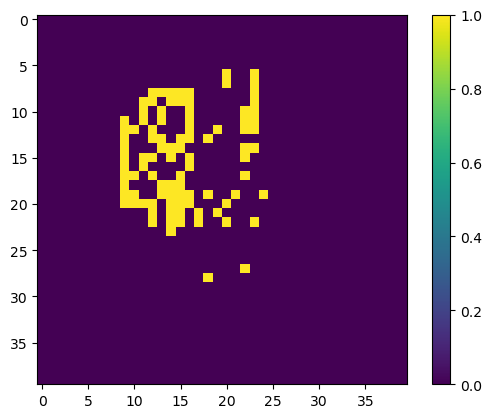

iteration 19-th of the algorithm 2 of optimization of the support


In [237]:
# Output
res2 = Cuturi_support_proba(X, b, Y, M, theta=0.2, steps2=15, step1=100, lambda_sinkhorn=15, iterations=400, t=0, t0=-10**-2)
l_X = res2[2]
A = res2[3]

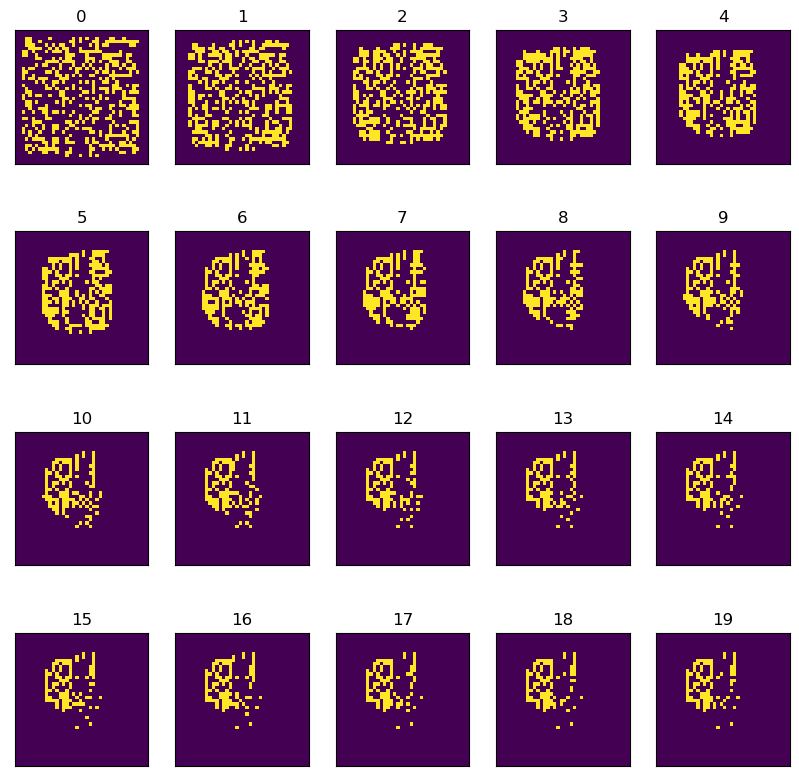

In [238]:
# Visualisation of the results
# Set up the axes
fig, axs = plt.subplots(4,5,figsize=(10,10))

# Iterate over the plotting locations
i = -1
for ax in axs.ravel():
    i = i + 1
    ax.imshow(np.reshape(l_X[:,i], (nb_pixel_side,nb_pixel_side)), vmin=0.0, vmax=0.01)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(i))

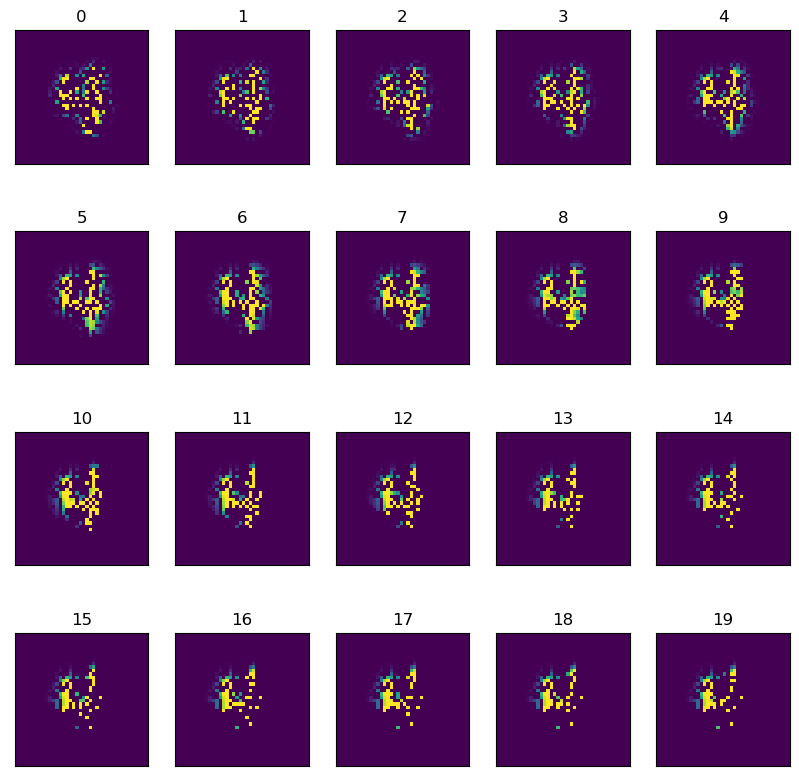

In [239]:
# Visualisation of the results
# Set up the axes
fig, axs = plt.subplots(4,5,figsize=(10,10))

# Iterate over the plotting locations
i = -1
for ax in axs.ravel():
    i = i + 1
    ax.imshow(np.reshape(A[:,i], (nb_pixel_side,nb_pixel_side)), vmin=0.0, vmax=0.01)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(i))

I have the feeling that using a changing theta for each step would be better.

All the algorithms must converge for the algorithm 2 that relies on the others works properly.
Therfore I increase the number of iterations in the sinkhorn descent, in order to be sure it converge.

Using a stopping criteria for the sinkhorn algorithm appears to be a must for optimization.

## Conclusion for the support optimisation:

It is complicated to be satisfied with this optimisation.
When only 1 digit is computed the algorithm is able to find his way through the almost correct position, but because of the to_base_can function some pixels are never reached.

The approximation of the gradient could be also a source of mistake. 
Playing with the parameter theta could be a source of solution ? No it seems that the main point is to be sure that the sinkhorn descent converges precisely enough.

FIXME: some algo could be even more optimized with parralelization and by stocking variable + using Class (object oriented programmation).

FIXME: the code could be compared to the Puccetti method ? Wellington method ?